In [1]:
# Library

import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import shap
import missingno

#statistik
from scipy.stats import chi2_contingency, normaltest

#cleaning
# import country_converter as coco

# FE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
import category_encoders as ce
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import PolynomialFeatures, KBinsDiscretizer
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split, cross_val_score
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, fbeta_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, make_scorer
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn import svm

# Imbalance Dataset
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.over_sampling import RandomOverSampler, SMOTE, SMOTENC

# # Ignore Warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

pd.set_option('display.max_columns', None)

# Revenue Management: Hotel Booking Analysis & Cancellation Prediction
   by Beami Mbani Wibawa

Sumber Data: [hotel_booking](https://www.kaggle.com/datasets/jessemostipak/hotel-booking-demand)

# Business Problem Understanding

## Context
Sebuah perusahaan yang bergerak di bidang perhotelan yang berada di negara Portugal, lebih tepatnya di kota Lisbon ingin mengetahui faktor-faktor apa saja yang dapat membuat seorang customer membatalkan pemesanan kamar hotel. Maka perusahaan merekrut data scientist untuk memanfaatkan data historikal customer yang melakukan pemesanan kamar hotel dengan status "cancel/tidak cancel" yang terjadi di tanggal 1 Juli 2015 sampai dengan 31 Agustus 2017, yang diharapkan dengan memanfaatkan data yang ada tersebut dapat memprediksi kecenderungan customer dengan kebiasaan/perilaku tertentu akan membatalkan pemesanan kamar hotel atau tidak. 

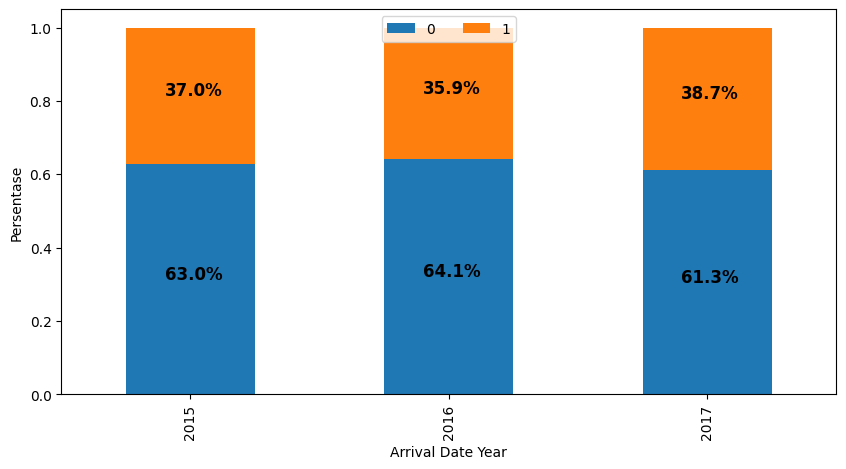

In [2]:
df = pd.read_csv('hotel_bookings.csv')

arrival_date_year_cancel = pd.crosstab(df['arrival_date_year'], df['is_canceled'], normalize = 'index')

arrival_date_year_cancel.plot(kind='bar', 
                        stacked=True, 
                        figsize=(10, 5))

plt.legend(loc='upper center', ncol=9)
plt.xlabel("Arrival Date Year")
plt.ylabel("Persentase")


for n, x in enumerate([*arrival_date_year_cancel.index.values]):
    for (proportion, y_loc) in zip(arrival_date_year_cancel.loc[x],
                                   arrival_date_year_cancel.loc[x].cumsum()):
                
        plt.text(x=n - 0.10,
                 y=(y_loc - proportion) + (proportion / 2),
                 s=f'{np.round(proportion * 100, 1)}%', 
                 color="black",
                 fontsize=12,
                 fontweight="bold")

plt.show()

Berdasarkan data yang dimiliki perusahaan, tingkat persentase pembatalan pemesanan kamar hotel di tahun 2017 adalah sebesar 38.7% yang mengalami peningkatan pembatalan pemesanan kamar hotel dibandingkan tahun 2016 yang hanya sebesar 35.9% dan tahun 2015 sebesar 37%. Tingkat pembatalan pemesanan kamar hotel dapat berdampak pada berkurang/hilangnya revenue pada suatu bisnis perhotelan. Menurut Asosiasi Hotel Portugis, kerugian akibat pembatalan pemesanan kamar hotel bisa mencapai sekitar 3,6 miliar euro, yang diperkirakan bahwa hotel-hotel Portugis bisa mengalami penurunan pendapatan hingga 80% sehubungan dengan angka-angka dari tahun 2019 [hotel revenue](https://www.theportugalnews.com/news/2020-11-11/hotel-revenue-could-drop-by-80-percent/56644). 

Dalam menyiasati revenue agar tidak berkurang/hilang, maka dilakukan upaya melalui revenue management. Revenue management adalah landasan menjalankan bisnis yang sukses dan menguntungkan, terutama di industri perhotelan. Revenue management melibatkan analisis data historikal untuk membantu memprediksi perilaku customer di industri perhotelan serta pendekatan dengan bantuan model prediksi 'cancel'. Kunci utama untuk strategi revenue management yang efektif adalah memiliki cara untuk membuat perkiraan yang tepat tentang kemungkinan kebiasaan customer yang membatalkan pemesanan kamar hotel, ini dapat terdiri dari pemesanan masa lalu dan informasi data customer lainnya. Dengan memprediksi perilaku customer yang akan membatalkan pemesanan kamar hotel diharapkan nantinya dapat digunakan terbatas untuk kalangan staff management hotel yang berupa website/aplikasi mobile, untuk membedakan reservasi yang diprediksi akan dibatalkan sehingga nantinya reservasi yang diprediksi akan dibatalkan tersebut dapat ditawarkan kembali kepada customer lain yang lebih potensial agar kamar tidak menjadi kosong/sia-sia dan mendapatkan keuntungan revenue dari F&B service melalui customer potensial yang menginap. Kemudian dengan adanya analisis historikal data berupa pemesanan kamar hotel yang dibatalkan maupun tidak, dapat membantu staff management hotel dalam menetapkan penyusunan anggaran yang lebih terkontrol di masa mendatang untuk Departemen Food and Beverage (F&B), Departemen Housekeeping, dan Departemen Personalia. Tujuan akhir dari revenue & Budget management adalah untuk memiliki kamar yang tepat untuk customer yang tepat pada waktu dan tempat yang tepat. Ketika ini terjadi, revenue hotel akan cenderung maksimal & budget planning dapat terkontrol, dan pada akhirnya berpengaruh pada profit hotel [budget planning](https://www.studocu.com/id/document/universitas-nusa-mandiri/science/41258620-simple/30127587).

## Target
- 0 : Tidak cancel
- 1 : Cancel 

## Problem Statement

Pembatalan pemesanan kamar hotel akan berdampak kepada:
1. mismanagement hotel service
2. pendapatan harian turun ketika kamar tidak dapat dipesan ulang oleh customer lain

Maka perlu untuk memastikan pemesanan kamar hotel yang akan dibatalkan sehingga pemesanan yang diprediksi akan dibatalkan tersebut dapat ditawarkan kembali kepada customer lain yang lebih potensial agar kamar tidak menjadi kosong/sia-sia dan mendapatkan keuntungan revenue dari F&B service melalui customer potensial yang menginap. Hal tersebut akan memberikan keuntungan jangka panjang pada perusahaan seperti pengaruhnya terhadap profit perusahaan. 

Namun tantangannya adalah jika kita tidak tahu pemesanan kamar hotel mana yang akan dibatalkan, maka akan cenderung terjadi tingkat hunian kamar yang tidak bisa diprediksi karena kamar yang ditawarkan kembali/tidak ditawarkan kembali, dimana ini dapat membuat revenue berkurang/hilang pada usaha perhotelan. 

## Goal

Berdasarkan permasalahan, perusahaan ingin memiliki kemampuan untuk:
1.  memprediksi kemungkinan seorang customer akan membatalkan pemesanan kamar hotel dari platform dengan membangun model machine learning klasifikasi, dengan target nilai metric evaluation sebesar 0.70, sehingga perusahaan dapat memfokuskan strategi kebijakan pembatalan menggunakan tenggat waktu pembatalan sehingga kamar yang akan dibatalkan dapat dialihkan kepada customer lain yang lebih berpotensi, agar kamar tidak menjadi kosong/sia-sia dan mendapatkan revenue dari F&B service.
2. serta untuk mengetahui faktor/variabel pemesanan kamar hotel yang dibatalkan dan tidak dari platform mereka, sehingga staff management hotel dapat membuat perencanaan anggaran yang lebih terkontrol untuk departemen personalia, departemen housekeeping dan departemen F&B.

## Analytic Approach

Saya akan melakukan analisis data eksplorasi untuk menemukan pola pemesanan kamar hotel yang dibatalkan dan tidak sehingga dapat membantu staff management hotel dalam menentukan perencanaan anggaran. kemudian saya akan membangun model machine learning klasifikasi yang akan membantu perusahaan untuk dapat memprediksi probabilitas seorang customer akan membatalkan pemesanan kamar hotel di platform mereka dengan target nilai metric evaluation sebesar 0.70.

## Confussion Metric

![](https://txt.cohere.ai/content/images/2022/06/feature.png)

- TN = diprediksi tidak cancel dan aktualnya memang tidak cancel 
- FP = diprediksi cancel padahal aktualnya tidak cancel
- FN = diprediksi tidak cancel padahal aktualnya cancel
- TP = diprediksi cancel dan aktualnya memang cancel

- Metric Evaluation

Type 1 error : False Positive  
Konsekuensi: mismanagement hotel service karena diprediksi cancel padahal aktualnya tidak cancel

Skenario:
Jika model memprediksi pemesanan kamar hotel dibatalkan dan sudah menjual kamar ke customer lain, tetapi kemudian customer asli tidak membatalkan dan datang ke hotel di tanggal mereka check in, lalu tidak ada kamar yang tersedia pada saat itu untuk customer asli atau ada kamar yang tersedia tetapi dengan kelas lebih rendah, maka reputasi hotel akan rusak. Namun jika kamar yang tersedia adalah kelas yang lebih tinggi dengan harga yang lebih mahal, maka hotel akan mengalami kerugian revenue dari menjual kamar yang lebih mahal itu dengan harga yang lebih murah.


Type 2 error : False Negative  
Konsekuensi: Revenue hotel akan hilang karena diprediksi tidak cancel padahal aktualnya cancel

Skenario:
Jika model memprediksi pemesanan kamar hotel tidak dibatalkan, tetapi customer tidak datang, maka hotel akan mengalami kerugian berupa revenue yang hilang karena hotel tidak menjual kamar kepada customer potensial lainnya dan hotel tidak akan mendapatkan revenue penjualan dari hotel service berupa F&B dan revenue dari hotel service lainnya.

Berdasarkan konsekuensi diatas, saya merasa kerugian dari konsekuensi FN lebih besar daripada kerugian dari konsekuensi FP. saya perlu meminimalisir bagian False Negative. Maka metric yang akan saya gunakan adalah recall.

## Data Understanding

- Sumber dataset : [hotel](https://www.sciencedirect.com/science/article/pii/S2352340918315191#s0005)
- Dataset merupakan data dari perusahaan perhotelan di Lisbon, Portugal
- Setiap baris data mempresentasikan informasi mengenai pemesanan kamar hotel melalui platform hotel tentang tanggal reservasi, tanggal kedatangan, status reservasi, jumlah tipe tamu yang melakukan reservasi (anak-anak, bayi, dewasa), negara asal customer, pemesanan melalui tour agent/tour operator, serta keadaan 'service' yang dipesan customer
- Setiap baris data terjadi pada tanggal 1 Juli 2015 sampai dengan 31 Agustus 2017

### Attribute Information

| Attribute | Data Type | Data Type | Description |
| --- | --- | --- | --- |
| hotel | Text | nominal | Tipe Hotel |
| is_canceled | Int | discrete | 0 : Tidak cancel, 1 : cancel |
| lead_time | Int | discrete | Selisih hari pada saat pemesanan hingga tanggal kedatangan |
| arrival_date_year | Int | discrete | Tahun tanggal kedatangan |
| arrival_date_month | Text | nominal |Bulan tanggal kedatangan |
| arrival_date_week_number | Int | discrete | Jumlah per minggu dari tahun untuk tanggal kedatangan |
| arrival_date_day_of_month | Int | discrete | Hari tanggal kedatangan |
| stays_in_weekend_nights | Int | discrete | Jumlah malam per akhir pekan (Sabtu atau Minggu) tamu menginap atau memesan untuk menginap di hotel |
| stays_in_week_nights | Int | discrete | Jumlah malam non weekend per minggu (Senin hingga Jumat) tamu menginap atau memesan untuk menginap di hotel
| adults | Int | discrete | Jumlah orang dewasa |
| children | Int | discrete | Jumlah anak-anak |
| babies | Int | discrete | Jumlah bayi |
| meal | Text | nominal | Jenis makanan yang dipesan. Kategori disajikan dalam paket makanan perhotelan standar: Undefined/SC - tidak ada paket makanan; BB - Tempat Tidur & Sarapan; HB - Half board (sarapan dan satu kali makan lainnya - biasanya makan malam); FB - Full board (sarapan, makan siang dan makan malam)|
| country | Text | nominal | Negara asal customer |
| market_segment | Text | nominal | Penunjukan segmen pasar. Dalam kategori, istilah "TA" berarti "Tour Agent" dan "TO" berarti "Tour Operator" |
| distribution_channel | Text | nominal | Saluran distribusi pemesanan. Istilah "TA" berarti "Tour Agent" dan "TO" berarti "Tour Operator" |
| is_repeated_guest | Int | discrete | Nilai yang menunjukkan apakah nama pemesanan berasal dari tamu berulang (1) atau tidak (0) |
| previous_cancellations | Int | discrete | Jumlah pemesanan sebelumnya yang dibatalkan oleh pelanggan sebelum pemesanan saat ini |
| previous_bookings_not_canceled | Int | discrete | Jumlah pemesanan sebelumnya yang tidak dibatalkan oleh pelanggan sebelum pemesanan saat ini |
| reserved_room_type | Text | nominal | Kode tipe kamar yang dipesan. Kode disajikan alih-alih penunjukan karena alasan anonimitas |
| assigned_room_type | Text | nominal | Kode untuk jenis kamar yang ditetapkan untuk pemesanan. Terkadang tipe kamar yang ditetapkan berbeda dari tipe kamar yang dipesan karena alasan operasional hotel (misalnya, overbooking) atau atas permintaan pelanggan |
| booking_changes | Int | discrete | Jumlah perubahan/amandemen yang dilakukan pada pemesanan dari saat pemesanan dimasukkan di sistem hingga saat check-in atau pembatalan |
| deposit_type | Text | nominal |Indikasi jika pelanggan melakukan deposit untuk menjamin pemesanan: No Deposit - tidak ada deposit yang dilakukan; Non Refund - deposit dibuat dalam nilai total biaya menginap; Refundable - deposit dibuat dengan nilai di bawah total biaya menginap |
| agent | Float | nominal | ID biro perjalanan yang melakukan pemesanan |
| company | Float | nominal | ID perusahaan/badan yang melakukan pemesanan atau bertanggung jawab untuk membayar pemesanan. ID disajikan alih-alih penunjukan karena alasan anonimitas |
| days_in_waiting_list | Int | discrete | Jumlah hari pemesanan berada dalam daftar tunggu sebelum dikonfirmasi ke pelanggan |
| customer_type | Text | nominal | Jenis pemesanan : Contract - apabila pemesanan memiliki jatah atau jenis kontrak lain yang terkait dengannya; Group - ketika pemesanan dikaitkan dengan grup; Transient - ketika pemesanan bukan bagian dari grup atau contract, dan tidak terkait dengan pemesanan transient lainnya; Transient-party - ketika pemesanan bersifat sementara, tetapi terkait dengan setidaknya pemesanan sementara lainnya |
| adr | Float | continuous | Tarif Harian Rata-Rata, Dihitung dengan membagi jumlah semua transaksi penginapan dengan jumlah total malam menginap |
| required_car_parking_spaces | Int | discrete | Jumlah tempat parkir mobil yang dibutuhkan oleh pelanggan |
| total_of_special_requests | Int | discrete | Jumlah permintaan khusus yang dibuat oleh pelanggan (misalnya tempat tidur twin atau lantai atas) |
| reservation_status | Text | nominal | Reservasi status terakhir: Canceled - pemesanan dibatalkan oleh pelanggan; Check-Out - pelanggan telah check-in tetapi sudah berangkat; No-Show - pelanggan tidak melakukan check-in dan menginformasikan alasannya kepada pihak hotel |
| reservation_status_date | Text | discrete | Tanggal saat status terakhir ditetapkan. Variabel ini dapat digunakan bersama dengan ReservationStatus untuk mengetahui kapan pemesanan dibatalkan atau kapan pelanggan check-out dari hotel |

# Data Cleaning

In [3]:
# cek 5 baris pertama
df.head()

hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  Resort Hotel            0        342               2015               July   
1  Resort Hotel            0        737               2015               July   
2  Resort Hotel            0          7               2015               July   
3  Resort Hotel            0         13               2015               July   
4  Resort Hotel            0         14               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   
1                        27                          1   
2                        27                          1   
3                        27                          1   
4                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  children  babies  \
0                        0                     0       2       0.0       0   
1                        0                     0       2       0.0       0   
2                        0                     1       1       0.0       0   
3                        0                     1       1       0.0       0   
4                        0                     2       2       0.0       0   

  meal country market_segment distribution_channel  is_repeated_guest  \
0   BB     PRT         Direct               Direct                  0   
1   BB     PRT         Direct               Direct                  0   
2   BB     GBR         Direct               Direct                  0   
3   BB     GBR      Corporate            Corporate                  0   
4   BB     GBR      Online TA                TA/TO                  0   

   previous_cancellations  previous_bookings_not_canceled reserved_room_type  \
0                       0                               0                  C   
1                       0                               0                  C   
2                       0                               0                  A   
3                       0                               0                  A   
4                       0                               0                  A   

  assigned_room_type  booking_changes deposit_type  agent  company  \
0                  C                3   No Deposit    NaN      NaN   
1                  C                4   No Deposit    NaN      NaN   
2                  C                0   No Deposit    NaN      NaN   
3                  A                0   No Deposit  304.0      NaN   
4                  A                0   No Deposit  240.0      NaN   

   days_in_waiting_list customer_type   adr  required_car_parking_spaces  \
0                     0     Transient   0.0                            0   
1                     0     Transient   0.0                            0   
2                     0     Transient  75.0                            0   
3                     0     Transient  75.0                            0   
4                     0     Transient  98.0                            0   

   total_of_special_requests reservation_status reservation_status_date  
0                          0          Check-Out              2015-07-01  
1                          0          Check-Out              2015-07-01  
2                          0          Check-Out              2015-07-02  
3                          0          Check-Out              2015-07-02  
4                          1          Check-Out              2015-07-03

In [4]:
# Datatype dan Menghitung jumlah dari kolom
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [5]:
# Data wrangling
def Check (x):
    Type=[]
    Count=[]
    Sample=[]
    MissVal=[]
    for i in x.columns:
        Sample.append(x[i].unique()[:10])
        Count.append(x[i].nunique())
        Type.append(x[i].dtype)
        MissVal.append(x[i].isna().sum())
    pd.set_option('display.max_colwidth', None)
    check=pd.DataFrame({
        'Columns':df.columns,
        'Dtype':Type,
        'Nunique':Count,
        'Missing Value':MissVal,
        'Unique':Sample
    })
    return check

In [6]:
Check(df)

Columns    Dtype  Nunique  Missing Value  \
0                            hotel   object        2              0   
1                      is_canceled    int64        2              0   
2                        lead_time    int64      479              0   
3                arrival_date_year    int64        3              0   
4               arrival_date_month   object       12              0   
5         arrival_date_week_number    int64       53              0   
6        arrival_date_day_of_month    int64       31              0   
7          stays_in_weekend_nights    int64       17              0   
8             stays_in_week_nights    int64       35              0   
9                           adults    int64       14              0   
10                        children  float64        5              4   
11                          babies    int64        5              0   
12                            meal   object        5              0   
13                         country   object      177            488   
14                  market_segment   object        8              0   
15            distribution_channel   object        5              0   
16               is_repeated_guest    int64        2              0   
17          previous_cancellations    int64       15              0   
18  previous_bookings_not_canceled    int64       73              0   
19              reserved_room_type   object       10              0   
20              assigned_room_type   object       12              0   
21                 booking_changes    int64       21              0   
22                    deposit_type   object        3              0   
23                           agent  float64      333          16340   
24                         company  float64      352         112593   
25            days_in_waiting_list    int64      128              0   
26                   customer_type   object        4              0   
27                             adr  float64     8879              0   
28     required_car_parking_spaces    int64        5              0   
29       total_of_special_requests    int64        6              0   
30              reservation_status   object        3              0   
31         reservation_status_date   object      926              0   

                                                                                                                      Unique  
0                                                                                                 [Resort Hotel, City Hotel]  
1                                                                                                                     [0, 1]  
2                                                                                    [342, 737, 7, 13, 14, 0, 9, 85, 75, 23]  
3                                                                                                         [2015, 2016, 2017]  
4                                    [July, August, September, October, November, December, January, February, March, April]  
5                                                                                   [27, 28, 29, 30, 31, 32, 33, 34, 35, 36]  
6                                                                                            [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  
7                                                                                            [0, 1, 2, 4, 3, 6, 13, 8, 5, 7]  
8                                                                                           [0, 1, 2, 3, 4, 5, 10, 11, 8, 6]  
9                                                                                        [2, 1, 3, 4, 40, 26, 50, 27, 55, 0]  
10                                                                                           [0.0, 1.0, 2.0, 10.0, 3.0, nan]  
11                                                                                                          [0, 1, 2, 10, 9]  
12                              

Berdasarkan pengamatan unique value, terdapat value 'Undefined' pada kolom 'meal', 'market_segment' dan 'distribution_channel'

In [7]:
# melihat 'undefined' pada kolom 'market_segment', dan 'distribution_channel'
und= (df['market_segment']=='Undefined')|(df['distribution_channel']=='Undefined')
df[und]

hotel  is_canceled  lead_time  arrival_date_year  \
14594  Resort Hotel            0        103               2015   
40600    City Hotel            1          2               2015   
40667    City Hotel            1          1               2015   
40679    City Hotel            1          1               2015   
41160    City Hotel            1          8               2015   

      arrival_date_month  arrival_date_week_number  arrival_date_day_of_month  \
14594               July                        28                          5   
40600             August                        32                          3   
40667             August                        32                          5   
40679             August                        32                          5   
41160             August                        33                         13   

       stays_in_weekend_nights  stays_in_week_nights  adults  children  \
14594                        2                     3       2       1.0   
40600                        1                     0       2       NaN   
40667                        0                     2       2       NaN   
40679                        0                     2       3       NaN   
41160                        2                     5       2       NaN   

       babies meal country market_segment distribution_channel  \
14594       0   HB     PRT         Direct            Undefined   
40600       0   BB     PRT      Undefined            Undefined   
40667       0   BB     PRT         Direct            Undefined   
40679       0   BB     PRT      Undefined            Undefined   
41160       0   BB     PRT      Online TA            Undefined   

       is_repeated_guest  previous_cancellations  \
14594                  0                       0   
40600                  0                       0   
40667                  0                       0   
40679                  0                       0   
41160                  0                       0   

       previous_bookings_not_canceled reserved_room_type assigned_room_type  \
14594                               0                  A                  A   
40600                               0                  B                  B   
40667                               0                  B                  B   
40679                               0                  B                  B   
41160                               0                  B                  B   

       booking_changes deposit_type  agent  company  days_in_waiting_list  \
14594                0   No Deposit    NaN      NaN                     0   
40600                0   No Deposit    NaN      NaN                     0   
40667                0   No Deposit   14.0      NaN                     0   
40679                0   No Deposit    NaN      NaN                     0   
41160                0   No Deposit    9.0      NaN                     0   

         customer_type    adr  required_car_parking_spaces  \
14594        Transient  112.7                            1   
40600  Transient-Party   12.0                            0   
40667  Transient-Party   12.0                            0   
40679  Transient-Party   18.0                            0   
41160  Transient-Party   76.5                            0   

       total_of_special_requests reservation_status reservation_status_date  
14594                          2          Check-Out              2015-07-10  
40600                          1           Canceled              2015-08-01  
40667                          1           Canceled              2015-08-04  
40679                          2           Canceled              2015-08-04  
41160                          1           Canceled              2015-08-09

karena jumlah baris 'undefined' dari kolom 'market_segment', dan 'distribution_channel' hanya sedikit dan saya tidak memiliki domain knowledge untuk mengisi baris tersebut, maka akan saya drop baris tersebut 

In [8]:
df=df[~und]

In [9]:
df[und]

Empty DataFrame
Columns: [hotel, is_canceled, lead_time, arrival_date_year, arrival_date_month, arrival_date_week_number, arrival_date_day_of_month, stays_in_weekend_nights, stays_in_week_nights, adults, children, babies, meal, country, market_segment, distribution_channel, is_repeated_guest, previous_cancellations, previous_bookings_not_canceled, reserved_room_type, assigned_room_type, booking_changes, deposit_type, agent, company, days_in_waiting_list, customer_type, adr, required_car_parking_spaces, total_of_special_requests, reservation_status, reservation_status_date]
Index: []

Berdasarkan pengamatan unique value, terdapat tipe 'meal' SC dan 'undefined', yang dimana berdasarkan [sumber data](https://www.sciencedirect.com/science/article/pii/S2352340918315191#s0005) bahwa SC dan Undefined adalah sama. Maka saya akan mengubah Undefined menjadi SC.

In [10]:
# melihat jumlah dari tipe 'meal'
df['meal'].value_counts()

BB           92306
HB           14462
SC           10650
Undefined     1169
FB             798
Name: meal, dtype: int64

In [11]:
# mengubah undefined menjadi SC
def sc_un(i):
    if i == 'Undefined':
        x='SC'
        return x
    else:
        x=i
    return x
df['meal'] = df['meal'].apply(sc_un)

In [12]:
# Cek kembali type meal dan jumlah
df['meal'].value_counts()


BB    92306
HB    14462
SC    11819
FB      798
Name: meal, dtype: int64

In [13]:
# Menampilkan statistik deskriptif dari numerical variable
df.describe()

is_canceled      lead_time  arrival_date_year  \
count  119385.000000  119385.000000      119385.000000   
mean        0.370398     104.014809        2016.156603   
std         0.482913     106.863734           0.707451   
min         0.000000       0.000000        2015.000000   
25%         0.000000      18.000000        2016.000000   
50%         0.000000      69.000000        2016.000000   
75%         1.000000     160.000000        2017.000000   
max         1.000000     737.000000        2017.000000   

       arrival_date_week_number  arrival_date_day_of_month  \
count             119385.000000              119385.000000   
mean                  27.164996                  15.798643   
std                   13.605391                   8.780765   
min                    1.000000                   1.000000   
25%                   16.000000                   8.000000   
50%                   28.000000                  16.000000   
75%                   38.000000                  23.000000   
max                   53.000000                  31.000000   

       stays_in_weekend_nights  stays_in_week_nights         adults  \
count            119385.000000         119385.000000  119385.000000   
mean                  0.927596              2.500306       1.856389   
std                   0.998618              1.908296       0.579263   
min                   0.000000              0.000000       0.000000   
25%                   0.000000              1.000000       2.000000   
50%                   1.000000              2.000000       2.000000   
75%                   2.000000              3.000000       2.000000   
max                  19.000000             50.000000      55.000000   

            children         babies  is_repeated_guest  \
count  119385.000000  119385.000000      119385.000000   
mean        0.103882       0.007949           0.031914   
std         0.398555       0.097438           0.175771   
min         0.000000       0.000000           0.000000   
25%         0.000000       0.000000           0.000000   
50%         0.000000       0.000000           0.000000   
75%         0.000000       0.000000           0.000000   
max        10.000000      10.000000           1.000000   

       previous_cancellations  previous_bookings_not_canceled  \
count           119385.000000                   119385.000000   
mean                 0.087121                        0.137103   
std                  0.844354                        1.497468   
min                  0.000000                        0.000000   
25%                  0.000000                        0.000000   
50%                  0.000000                        0.000000   
75%                  0.000000                        0.000000   
max                 26.000000                       72.000000   

       booking_changes          agent      company  days_in_waiting_list  \
count    119385.000000  103048.000000  6797.000000         119385.000000   
mean          0.221133      86.694841   189.266735              2.321246   
std           0.652318     110.775127   131.655015             17.595083   
min           0.000000       1.000000     6.000000              0.000000   
25%           0.000000       9.000000    62.000000              0.000000   
50%           0.000000      14.000000   179.000000              0.000000   
75%           0.000000     229.000000   270.000000              0.000000   
max          21.000000     535.000000   543.000000            391.000000   

                 adr  required_car_parking_spaces  total_of_special_requests  
count  119385.000000                119385.000000              119385.000000  
mean      101.833450                     0.062512                   0.571328  
std        50.534866                     0.245281                   0.792791  
min        -6.380000                     0.000000                   0.000000  
25%        69.290000                     0.000000                   0.000000  
50%        94.59000

In [14]:
# Menampilkan statistik deskriptif dari categorical variable
df.describe(include='O')

hotel arrival_date_month    meal country market_segment  \
count       119385             119385  119385  118897         119385   
unique           2                 12       4     177              7   
top     City Hotel             August      BB     PRT      Online TA   
freq         79326              13873   92306   48585          56476   

       distribution_channel reserved_room_type assigned_room_type  \
count                119385             119385             119385   
unique                    4                 10                 12   
top                   TA/TO                  A                  A   
freq                  97870              85993              74052   

       deposit_type customer_type reservation_status reservation_status_date  
count        119385        119385             119385                  119385  
unique            3             4                  3                     926  
top      No Deposit     Transient          Check-Out              2015-10-21  
freq         104636         89612              75165                    1461

Berdasarkan statistik deskriptif terdapat pengamatan seperti:
1. pada kolom 'Adults' yang menjelaskan mengenai jumlah orang dewasa, pada nilai minimumnya ada angka 0. Hal tersebut tidak mungkin terjadi jika kita ingin memesan kamar hotel tanpa adanya seseorang yang sudah cukup umur untuk memesan kamar hotel. Maka saya coba analisis tamu hotel lebih lanjut dari kolom 'Adults', 'babies' dan 'children'. 
2. pada kolom 'Adr' yang menjelaskan Tarif Harian Rata-Rata, Dihitung dengan membagi jumlah semua transaksi penginapan dengan jumlah total malam menginap, pada nilai minimumnya adalah -6.380000. Hal tersebut tidak mungkin terjadi karena seharusnya tarif harian rata-rata tidak menghasilkan nilai minus. Maka saya akan drop nilai minus tersebut.

### Analisis Tamu Hotel

In [15]:
# melihat jumlah tamu yang kosong
filter=(df['children']==0) & (df['adults']==0) & (df['babies']==0)
df[filter]

hotel  is_canceled  lead_time  arrival_date_year  \
2224    Resort Hotel            0          1               2015   
2409    Resort Hotel            0          0               2015   
3181    Resort Hotel            0         36               2015   
3684    Resort Hotel            0        165               2015   
3708    Resort Hotel            0        165               2015   
...              ...          ...        ...                ...   
115029    City Hotel            0        107               2017   
115091    City Hotel            0          1               2017   
116251    City Hotel            0         44               2017   
116534    City Hotel            0          2               2017   
117087    City Hotel            0        170               2017   

       arrival_date_month  arrival_date_week_number  \
2224              October                        41   
2409              October                        42   
3181             November                        47   
3684             December                        53   
3708             December                        53   
...                   ...                       ...   
115029               June                        26   
115091               June                        26   
116251               July                        28   
116534               July                        28   
117087               July                        30   

        arrival_date_day_of_month  stays_in_weekend_nights  \
2224                            6                        0   
2409                           12                        0   
3181                           20                        1   
3684                           30                        1   
3708                           30                        2   
...                           ...                      ...   
115029                         27                        0   
115091                         30                        0   
116251                         15                        1   
116534                         15                        2   
117087                         27                        0   

        stays_in_week_nights  adults  children  babies meal country  \
2224                       3       0       0.0       0   SC     PRT   
2409                       0       0       0.0       0   SC     PRT   
3181                       2       0       0.0       0   SC     ESP   
3684                       4       0       0.0       0   SC     PRT   
3708                       4       0       0.0       0   SC     PRT   
...                      ...     ...       ...     ...  ...     ...   
115029                     3       0       0.0       0   BB     CHE   
115091                     1       0       0.0       0   SC     PRT   
116251                     1       0       0.0       0   SC     SWE   
116534                     5       0       0.0       0   SC     RUS   
117087                     2       0       0.0       0   BB     BRA   

       market_segment distribution_channel  is_repeated_guest  \
2224        Corporate            Corporate                  0   
2409        Corporate            Corporate                  0   
3181           Groups                TA/TO                  0   
3684           Groups                TA/TO                  0   
3708           Groups                TA/TO                  0   
...               ...                  ...                ...   
115029      Online TA                TA/TO                  0   
115091  Complementary               Direct                  0   
116251      Online TA                TA/TO                  0   
116534      Online TA                TA/TO                  0   
117087  Offline TA/TO                TA/TO                  0   

        previous_cancellations  previous_bookings_not_canceled  \
2224                         0                               0   
2409                         0        

In [16]:
# Drop baris jumlah tamu yang 0
df=df[~filter]

In [17]:
df[filter]

Empty DataFrame
Columns: [hotel, is_canceled, lead_time, arrival_date_year, arrival_date_month, arrival_date_week_number, arrival_date_day_of_month, stays_in_weekend_nights, stays_in_week_nights, adults, children, babies, meal, country, market_segment, distribution_channel, is_repeated_guest, previous_cancellations, previous_bookings_not_canceled, reserved_room_type, assigned_room_type, booking_changes, deposit_type, agent, company, days_in_waiting_list, customer_type, adr, required_car_parking_spaces, total_of_special_requests, reservation_status, reservation_status_date]
Index: []

In [18]:
filter=(df['children']==0) & (df['adults']==0) & (df['babies']==0)

In [19]:
# cek kembali jumlah baris
df.shape

(119205, 32)

Kemudian saya ingin mengetahui apakah ada pemesanan dengan 0 orang dewasa tetapi memiliki anak/bayi.

In [20]:
df[(df['adults'] == 0) & ((df['children'] != 0) | (df['babies'] != 0))] [['adults', 'children', 'babies']] 

adults  children  babies
40984        0       3.0       0
41048        0       2.0       0
41446        0       2.0       0
41952        0       2.0       0
45158        0       2.0       0
...        ...       ...     ...
117204       0       2.0       0
117274       0       2.0       0
117303       0       2.0       0
117453       0       2.0       0
118200       0       3.0       0

[223 rows x 3 columns]

Terdapat beberapa pemesanan dengan 0 orang dewasa tetapi memiliki anak/bayi.

In [21]:
# Drop jumlah baris 'Adults' yang 0
df.drop(labels = df[df['adults'] == 0].index, axis = 0, inplace = True)
df[df['adults'] == 0]

Empty DataFrame
Columns: [hotel, is_canceled, lead_time, arrival_date_year, arrival_date_month, arrival_date_week_number, arrival_date_day_of_month, stays_in_weekend_nights, stays_in_week_nights, adults, children, babies, meal, country, market_segment, distribution_channel, is_repeated_guest, previous_cancellations, previous_bookings_not_canceled, reserved_room_type, assigned_room_type, booking_changes, deposit_type, agent, company, days_in_waiting_list, customer_type, adr, required_car_parking_spaces, total_of_special_requests, reservation_status, reservation_status_date]
Index: []

In [22]:
# Mengecek kembali jumlah baris 'adults' yang 0
df[(df['adults'] == 0) & ((df['children'] != 0) | (df['babies'] != 0))] [['adults', 'children', 'babies']] 

Empty DataFrame
Columns: [adults, children, babies]
Index: []

In [23]:
# Data jumlah baris 'adults' yang 0 sudah terhapus. Mari kita cek kembali jumlah baris dan kolom setelah di drop
df.shape

(118982, 32)

### Drop Tarif Rata-rata Harian (adr) yang minus

In [24]:
# Melihat nilai adr yang minus
df[df['adr'] <0]

hotel  is_canceled  lead_time  arrival_date_year  \
14969  Resort Hotel            0        195               2017   

      arrival_date_month  arrival_date_week_number  arrival_date_day_of_month  \
14969              March                        10                          5   

       stays_in_weekend_nights  stays_in_week_nights  adults  children  \
14969                        4                     6       2       0.0   

       babies meal country market_segment distribution_channel  \
14969       0   BB     GBR         Groups               Direct   

       is_repeated_guest  previous_cancellations  \
14969                  1                       0   

       previous_bookings_not_canceled reserved_room_type assigned_room_type  \
14969                               2                  A                  H   

       booking_changes deposit_type  agent  company  days_in_waiting_list  \
14969                2   No Deposit  273.0      NaN                     0   

         customer_type   adr  required_car_parking_spaces  \
14969  Transient-Party -6.38                            0   

       total_of_special_requests reservation_status reservation_status_date  
14969                          0          Check-Out              2017-03-15

In [25]:
# Drop nilai adr yang minus
df.drop(labels = df[df['adr'] < 0].index, axis = 0, inplace = True)
df[df['adr'] < 0]

Empty DataFrame
Columns: [hotel, is_canceled, lead_time, arrival_date_year, arrival_date_month, arrival_date_week_number, arrival_date_day_of_month, stays_in_weekend_nights, stays_in_week_nights, adults, children, babies, meal, country, market_segment, distribution_channel, is_repeated_guest, previous_cancellations, previous_bookings_not_canceled, reserved_room_type, assigned_room_type, booking_changes, deposit_type, agent, company, days_in_waiting_list, customer_type, adr, required_car_parking_spaces, total_of_special_requests, reservation_status, reservation_status_date]
Index: []

In [26]:
# Menampilkan kembali statistik deskriptif dari numerical variable
df.describe()

is_canceled      lead_time  arrival_date_year  \
count  118981.000000  118981.000000      118981.000000   
mean        0.370740     104.073180        2016.156403   
std         0.483005     106.891537           0.707716   
min         0.000000       0.000000        2015.000000   
25%         0.000000      18.000000        2016.000000   
50%         0.000000      69.000000        2016.000000   
75%         1.000000     160.000000        2017.000000   
max         1.000000     737.000000        2017.000000   

       arrival_date_week_number  arrival_date_day_of_month  \
count             118981.000000              118981.000000   
mean                  27.164110                  15.797262   
std                   13.599029                   8.781103   
min                    1.000000                   1.000000   
25%                   16.000000                   8.000000   
50%                   28.000000                  16.000000   
75%                   38.000000                  23.000000   
max                   53.000000                  31.000000   

       stays_in_weekend_nights  stays_in_week_nights         adults  \
count            118981.000000         118981.000000  118981.000000   
mean                  0.926921              2.499021       1.862676   
std                   0.995238              1.897754       0.570064   
min                   0.000000              0.000000       1.000000   
25%                   0.000000              1.000000       2.000000   
50%                   1.000000              2.000000       2.000000   
75%                   2.000000              3.000000       2.000000   
max                  19.000000             50.000000      55.000000   

            children         babies  is_repeated_guest  \
count  118981.000000  118981.000000      118981.000000   
mean        0.100428       0.007951           0.031543   
std         0.390217       0.097475           0.174780   
min         0.000000       0.000000           0.000000   
25%         0.000000       0.000000           0.000000   
50%         0.000000       0.000000           0.000000   
75%         0.000000       0.000000           0.000000   
max        10.000000      10.000000           1.000000   

       previous_cancellations  previous_bookings_not_canceled  \
count           118981.000000                   118981.000000   
mean                 0.087342                        0.137333   
std                  0.845714                        1.499554   
min                  0.000000                        0.000000   
25%                  0.000000                        0.000000   
50%                  0.000000                        0.000000   
75%                  0.000000                        0.000000   
max                 26.000000                       72.000000   

       booking_changes          agent      company  days_in_waiting_list  \
count    118981.000000  102721.000000  6766.000000         118981.000000   
mean          0.218522      86.888027   189.133461              2.325682   
std           0.638081     110.846466   131.585964             17.614634   
min           0.000000       1.000000     6.000000              0.000000   
25%           0.000000       9.000000    62.000000              0.000000   
50%           0.000000      14.000000   178.000000              0.000000   
75%           0.000000     229.000000   270.000000              0.000000   
max          18.000000     535.000000   543.000000            391.000000   

                 adr  required_car_parking_spaces  total_of_special_requests  
count  118981.000000                118981.000000              118981.000000  
mean      102.011330                     0.062649                   0.570612  
std        50.447114                     0.245535                   0.792393  
min         0.000000                     0.000000                   0.000000  
25%        69.500000                     0.000000                   0.000000  
50%        95.00000

### Missing Value Handling

In [27]:
# Cek Missing Value
df.isna().sum().sort_values(ascending=False)

company                           112215
agent                              16260
country                              478
hotel                                  0
previous_cancellations                 0
reservation_status                     0
total_of_special_requests              0
required_car_parking_spaces            0
adr                                    0
customer_type                          0
days_in_waiting_list                   0
deposit_type                           0
booking_changes                        0
assigned_room_type                     0
reserved_room_type                     0
previous_bookings_not_canceled         0
is_repeated_guest                      0
is_canceled                            0
distribution_channel                   0
market_segment                         0
meal                                   0
babies                                 0
children                               0
adults                                 0
stays_in_week_ni

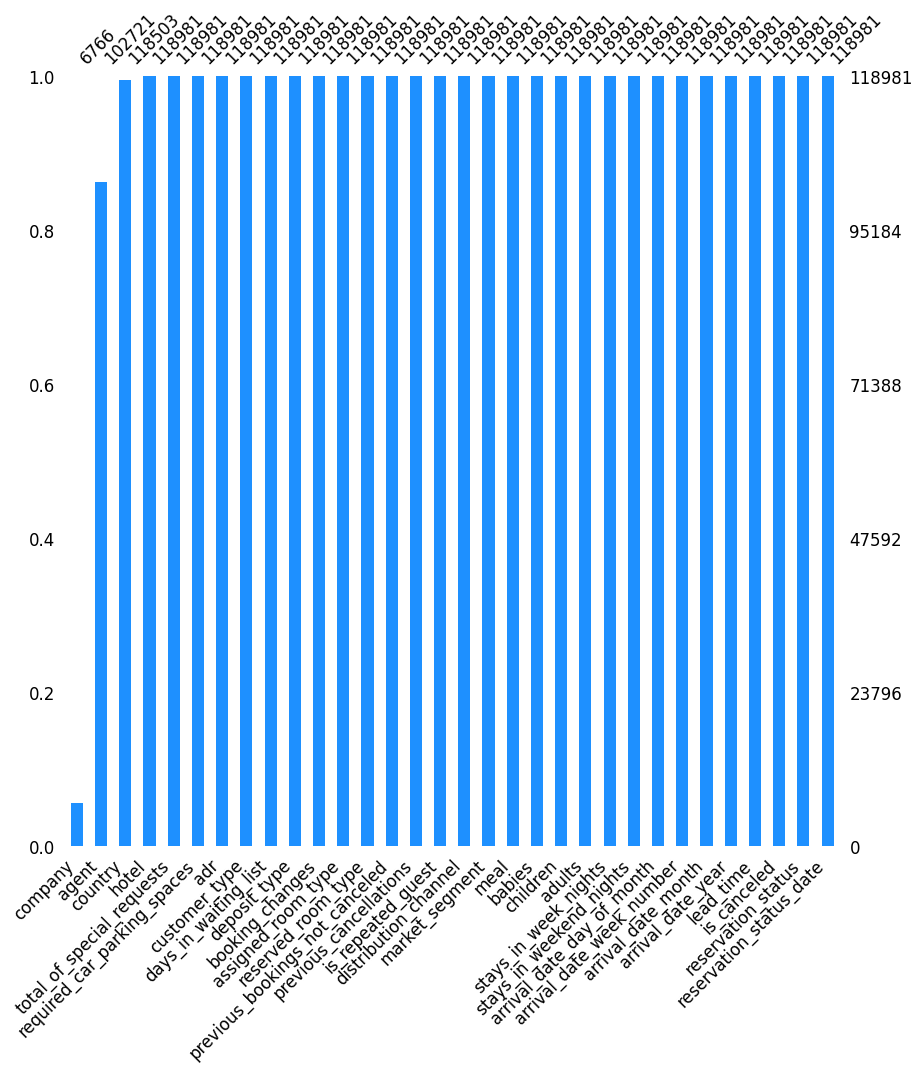

In [28]:
missingno.bar(df,color="dodgerblue", sort="ascending", figsize=(10,10), fontsize=12);

kolom company, country, dan agent memiliki missing values/data yang hilang.
- kolom company yang menjelaskan mengenai ID perusahaan yang melakukan reservasi memiliki missing value sangat banyak sekali (terlihat dari bar), dimana saya tidak memiliki domain knowledge untuk mengisi missing value tersebut. Serta kolom company ini yang merupakan tipe data kategorikal bisa saja diisi dengan modus (nilai yang sering muncul), namun tidak akan saya lakukan karena terlalu banyak, sehingga saya akan drop kolom company.
- kolom agent yang menjelaskan mengenai ID biro perjalanan yang melakukan reservasi, missing valuenya tidak terlalu begitu banyak dibandingkan dengan kolom company maka akan saya isi dengan modus.
- kolom country yang menjelaskan mengenai kota customer berasal, yang merupakan data kategorikal, missing valuenya sedikit maka akan saya isi dengan modus.

In [29]:
# Drop kolom company 
df.drop(columns = ['company'], axis=1, inplace=True)

In [30]:
# Mengisi missing value yang ada di kolom agent dengan 'modus'
df['agent'].fillna(df['agent'].mode()[0], inplace=True) 

In [31]:
# Mengisi missing value yang ada di kolom country dengan 'modus'
df['country'].fillna(df['country'].mode()[0], inplace=True) 

In [32]:
df.isna().sum().sort_values(ascending=False)

hotel                             0
is_repeated_guest                 0
reservation_status                0
total_of_special_requests         0
required_car_parking_spaces       0
adr                               0
customer_type                     0
days_in_waiting_list              0
agent                             0
deposit_type                      0
booking_changes                   0
assigned_room_type                0
reserved_room_type                0
previous_bookings_not_canceled    0
previous_cancellations            0
distribution_channel              0
is_canceled                       0
market_segment                    0
country                           0
meal                              0
babies                            0
children                          0
adults                            0
stays_in_week_nights              0
stays_in_weekend_nights           0
arrival_date_day_of_month         0
arrival_date_week_number          0
arrival_date_month          

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118981 entries, 0 to 119389
Data columns (total 31 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           118981 non-null  object 
 1   is_canceled                     118981 non-null  int64  
 2   lead_time                       118981 non-null  int64  
 3   arrival_date_year               118981 non-null  int64  
 4   arrival_date_month              118981 non-null  object 
 5   arrival_date_week_number        118981 non-null  int64  
 6   arrival_date_day_of_month       118981 non-null  int64  
 7   stays_in_weekend_nights         118981 non-null  int64  
 8   stays_in_week_nights            118981 non-null  int64  
 9   adults                          118981 non-null  int64  
 10  children                        118981 non-null  float64
 11  babies                          118981 non-null  int64  
 12  meal            

In [34]:
# mengubah data type kolom agent dari float to object
# karena kolom agent menjelaskan mengenai ID biro perjalanan yang melakukan reservasi berarti merupakan tipe kategorikal dalam penulisan format angka
df['agent'] = df['agent'].astype('object', errors='ignore')

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118981 entries, 0 to 119389
Data columns (total 31 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           118981 non-null  object 
 1   is_canceled                     118981 non-null  int64  
 2   lead_time                       118981 non-null  int64  
 3   arrival_date_year               118981 non-null  int64  
 4   arrival_date_month              118981 non-null  object 
 5   arrival_date_week_number        118981 non-null  int64  
 6   arrival_date_day_of_month       118981 non-null  int64  
 7   stays_in_weekend_nights         118981 non-null  int64  
 8   stays_in_week_nights            118981 non-null  int64  
 9   adults                          118981 non-null  int64  
 10  children                        118981 non-null  float64
 11  babies                          118981 non-null  int64  
 12  meal            

## Duplicate Value Handling

In [36]:
# melihat data duplikat
df[df.duplicated(keep=False)]

hotel  is_canceled  lead_time  arrival_date_year  \
4       Resort Hotel            0         14               2015   
5       Resort Hotel            0         14               2015   
21      Resort Hotel            0         72               2015   
22      Resort Hotel            0         72               2015   
39      Resort Hotel            0         70               2015   
...              ...          ...        ...                ...   
119352    City Hotel            0         63               2017   
119353    City Hotel            0         63               2017   
119354    City Hotel            0         63               2017   
119372    City Hotel            0        175               2017   
119373    City Hotel            0        175               2017   

       arrival_date_month  arrival_date_week_number  \
4                    July                        27   
5                    July                        27   
21                   July                        27   
22                   July                        27   
39                   July                        27   
...                   ...                       ...   
119352             August                        35   
119353             August                        35   
119354             August                        35   
119372             August                        35   
119373             August                        35   

        arrival_date_day_of_month  stays_in_weekend_nights  \
4                               1                        0   
5                               1                        0   
21                              1                        2   
22                              1                        2   
39                              2                        2   
...                           ...                      ...   
119352                         31                        0   
119353                         31                        0   
119354                         31                        0   
119372                         31                        1   
119373                         31                        1   

        stays_in_week_nights  adults  children  babies meal country  \
4                          2       2       0.0       0   BB     GBR   
5                          2       2       0.0       0   BB     GBR   
21                         4       2       0.0       0   BB     PRT   
22                         4       2       0.0       0   BB     PRT   
39                         3       2       0.0       0   HB     ROU   
...                      ...     ...       ...     ...  ...     ...   
119352                     3       3       0.0       0   BB     SWE   
119353                     3       3       0.0       0   BB     SWE   
119354                     3       3       0.0       0   BB     SWE   
119372                     3       1       0.0       0   BB     NLD   
119373                     3       1       0.0       0   BB     NLD   

       market_segment distribution_channel  is_repeated_guest  \
4           Online TA                TA/TO                  0   
5           Online TA                TA/TO                  0   
21             Direct               Direct                  0   
22             Direct               Direct                  0   
39             Direct               Direct                  0   
...               ...                  ...                ...   
119352      Online TA                TA/TO                  0   
119353      Online TA                TA/TO                  0   
119354      Online TA                TA/TO                  0   
119372  Offline TA/TO                TA/TO                  0   
119373  Offline TA/TO                TA/TO                  0   

        previous_cancellations  previous_bookings_not_canceled  \
4                            0                               0   
5                            0        

In [37]:
print(f"Terdapat data duplikat sebanyak {df.duplicated().sum()} baris. Maka akan saya drop")

Terdapat data duplikat sebanyak 32003 baris. Maka akan saya drop


In [38]:
# Cek dan hapus data duplikat
print(f"Data sebelumnya berjumlah {df.shape}, setelah data duplikat di drop menjadi {df.drop_duplicates().shape}")
df = df.drop_duplicates()

Data sebelumnya berjumlah (118981, 31), setelah data duplikat di drop menjadi (86978, 31)


# Outlier

In [39]:
dfnum = df.select_dtypes(exclude='object').columns
dfnum

Index(['is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_week_number', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes',
       'days_in_waiting_list', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests'],
      dtype='object')

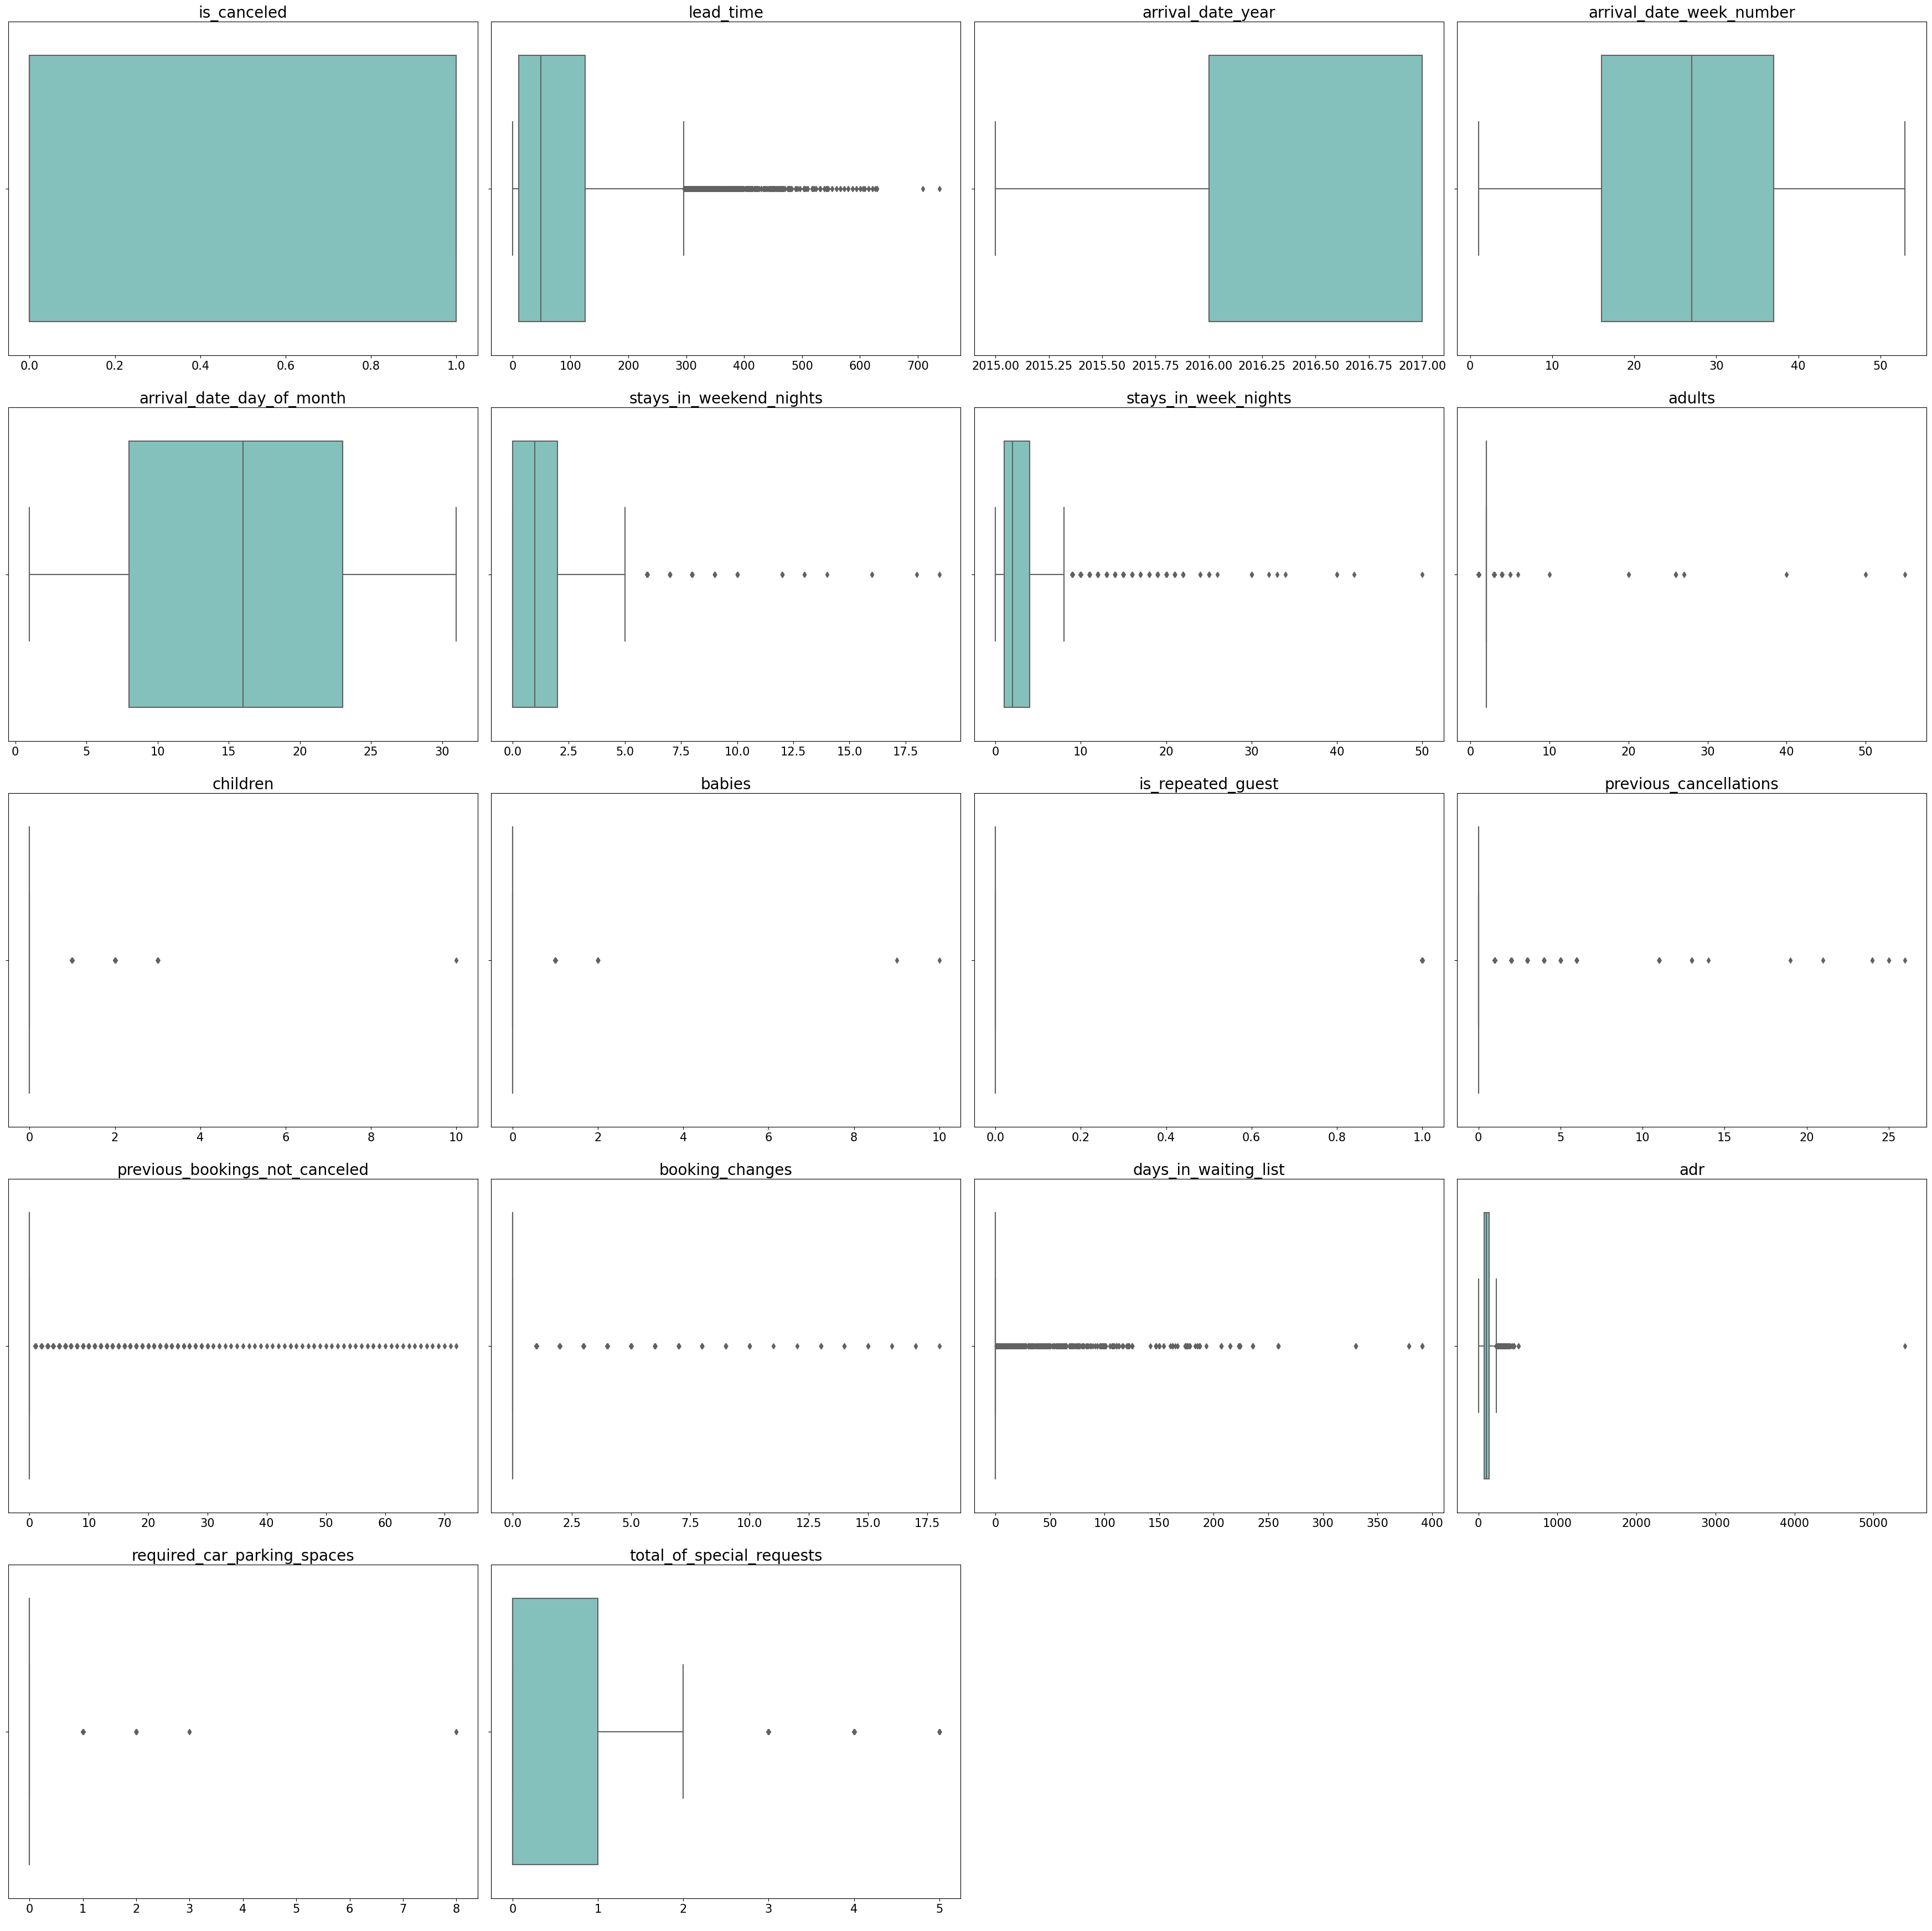

In [40]:
# melihat outlier data numerikal 
plt.figure(figsize=(35,35))
for i in range(0, len(dfnum)):
    plt.subplot(5,4,i+1)
    sns.boxplot(x=df[dfnum[i]], palette='GnBu')
    plt.title(dfnum[i], fontsize=20)
    plt.xlabel(' ')
    plt.tight_layout()
    plt.tick_params(axis='both', which='major', labelsize=15)

Berdasarkan pengamatan outlier diatas,terdapat outlier pada feature 'lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'previous_cancellations', 'days_in_waiting_list', 'adr', 'required_car_parking_spaces', 'total_of_special_requests'

In [41]:
# Melihat lower bound, upper bound
find_anomalies= ['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
                 'babies', 'previous_cancellations', 'days_in_waiting_list',
                 'adr', 'required_car_parking_spaces']

for i in range(0, len(find_anomalies)):
    Q1 = df[find_anomalies[i]].quantile(0.25)
    Q3 = df[find_anomalies[i]].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound =  Q1 - (1.5 * IQR)
    upper_bound =  Q3 + (1.5 * IQR)
    condition = (df[find_anomalies[i]]< lower_bound) | (df[find_anomalies[i]]> upper_bound)
    outlier = df.loc[condition, find_anomalies[i]].count()
    Persentase_outlier = outlier/df[find_anomalies[i]].count()*100
    print(f'''Lower Bound {find_anomalies[i]} adalah {round(lower_bound,2)}, dan Upper Bound {find_anomalies[i]} adalah {round(upper_bound,2)} , terdapat {outlier} data outlier''')
    '/n'

Lower Bound lead_time adalah -160.0, dan Upper Bound lead_time adalah 296.0 , terdapat 2383 data outlier
Lower Bound stays_in_weekend_nights adalah -3.0, dan Upper Bound stays_in_weekend_nights adalah 5.0 , terdapat 213 data outlier
Lower Bound stays_in_week_nights adalah -3.5, dan Upper Bound stays_in_week_nights adalah 8.5 , terdapat 1511 data outlier
Lower Bound adults adalah 2.0, dan Upper Bound adults adalah 2.0 , terdapat 22496 data outlier
Lower Bound children adalah 0.0, dan Upper Bound children adalah 0.0 , terdapat 8144 data outlier
Lower Bound babies adalah 0.0, dan Upper Bound babies adalah 0.0 , terdapat 911 data outlier
Lower Bound previous_cancellations adalah 0.0, dan Upper Bound previous_cancellations adalah 0.0 , terdapat 1679 data outlier
Lower Bound days_in_waiting_list adalah 0.0, dan Upper Bound days_in_waiting_list adalah 0.0 , terdapat 855 data outlier
Lower Bound adr adalah -20.52, dan Upper Bound adr adalah 226.88 , terdapat 2506 data outlier
Lower Bound requi

# Data Distribution (Univariate Analysis)


In [42]:
# cek kolom numerikal dan categorical
dfcat = list(df.select_dtypes(['object']).columns)
dfnum = list(set(df.columns)-set(dfcat))

print(f'Number of numerical features: {len(dfnum)-1}')
print(f'numerical features: {[cols for cols in dfnum if cols != "is_canceled"]}')
print(f'\nNumber of categorical features: {len(dfcat)}')
print(f'Categorical features: {dfcat}')

Number of numerical features: 17
numerical features: ['stays_in_week_nights', 'arrival_date_day_of_month', 'babies', 'lead_time', 'arrival_date_year', 'arrival_date_week_number', 'stays_in_weekend_nights', 'booking_changes', 'days_in_waiting_list', 'previous_cancellations', 'previous_bookings_not_canceled', 'adr', 'adults', 'required_car_parking_spaces', 'is_repeated_guest', 'children', 'total_of_special_requests']

Number of categorical features: 13
Categorical features: ['hotel', 'arrival_date_month', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'agent', 'customer_type', 'reservation_status', 'reservation_status_date']


In [43]:
#statistik
from scipy.stats import chi2_contingency, normaltest

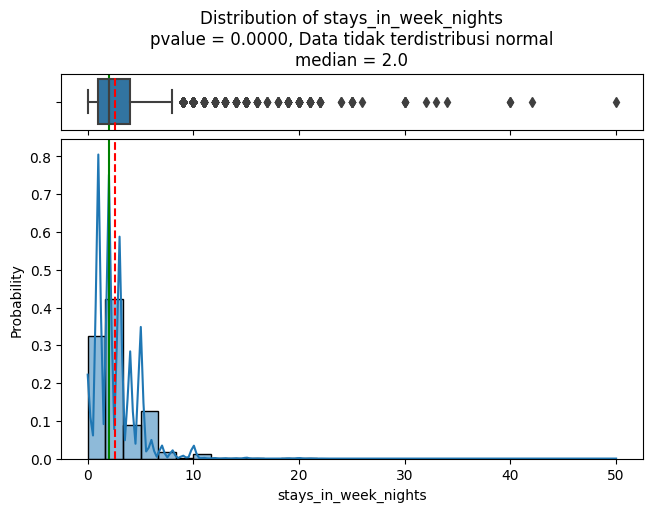

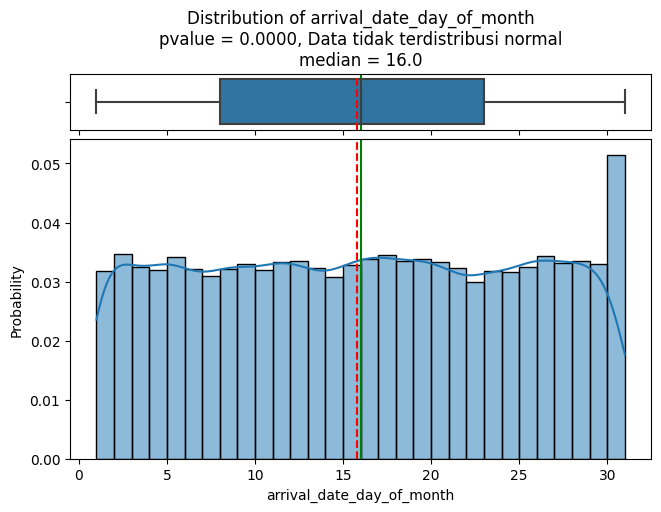

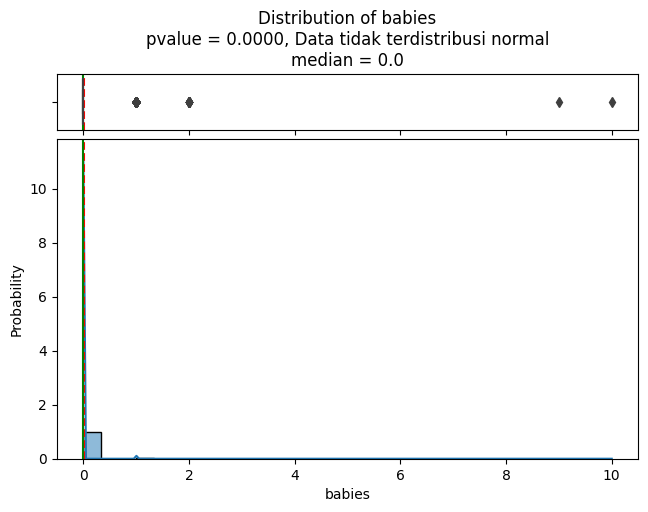

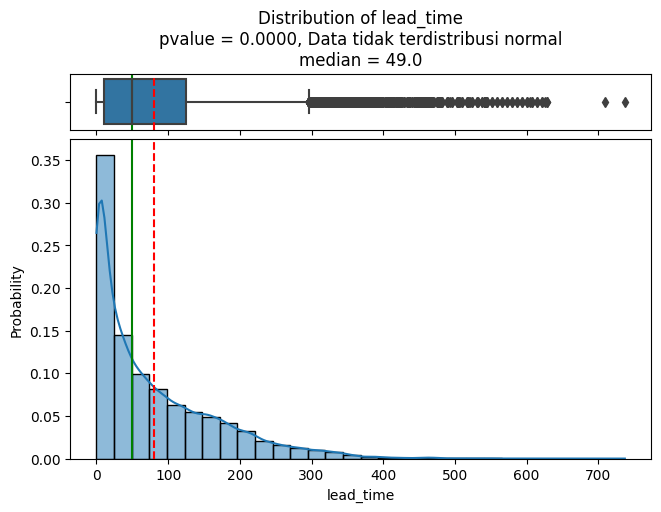

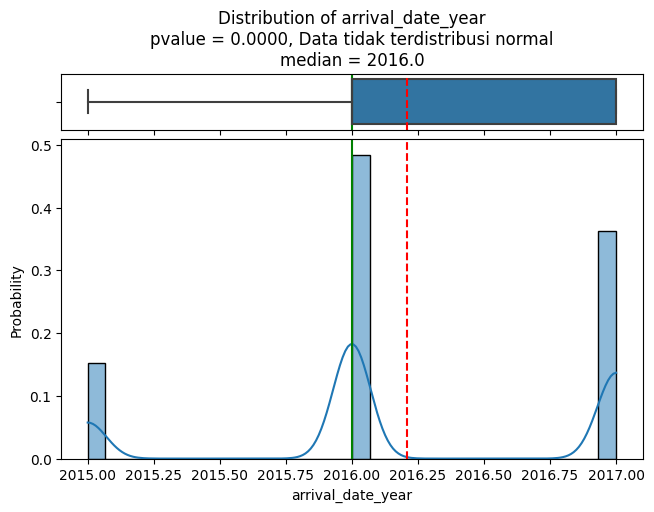

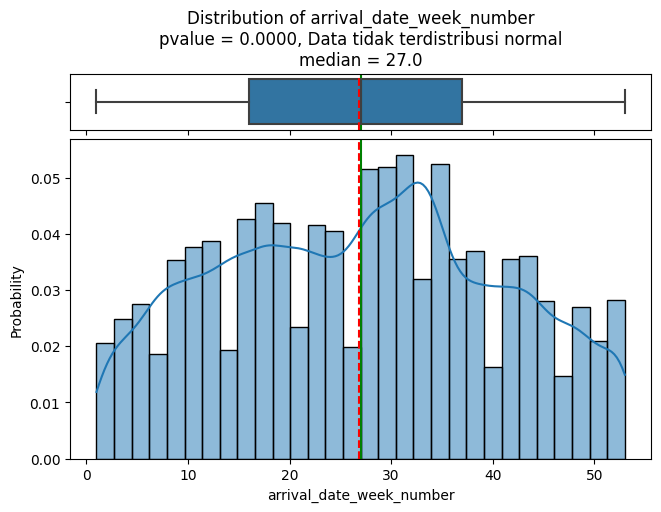

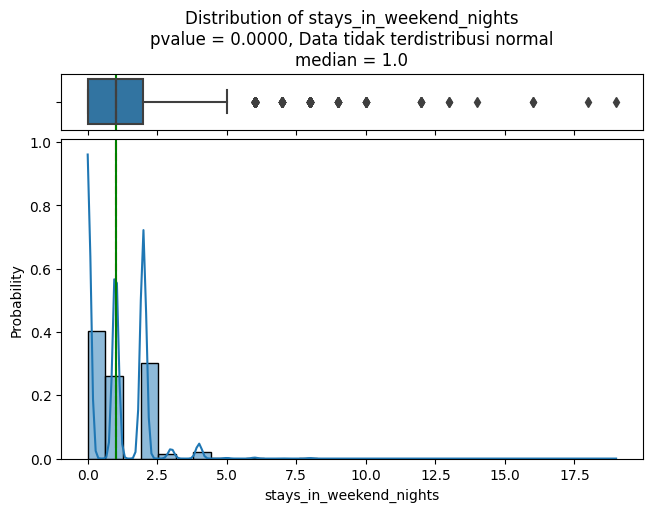

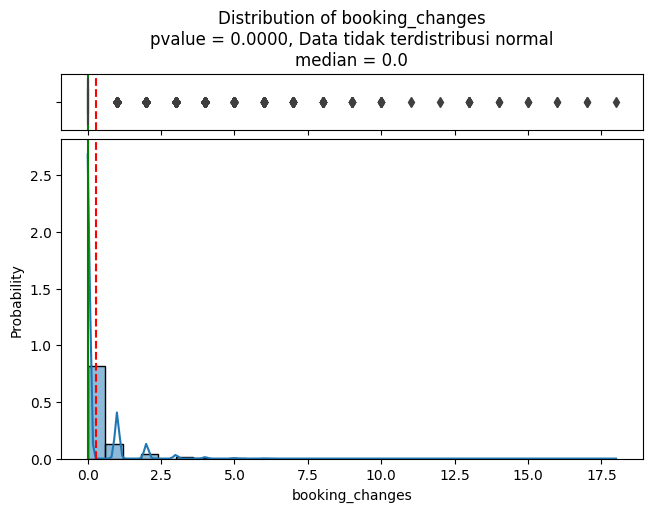

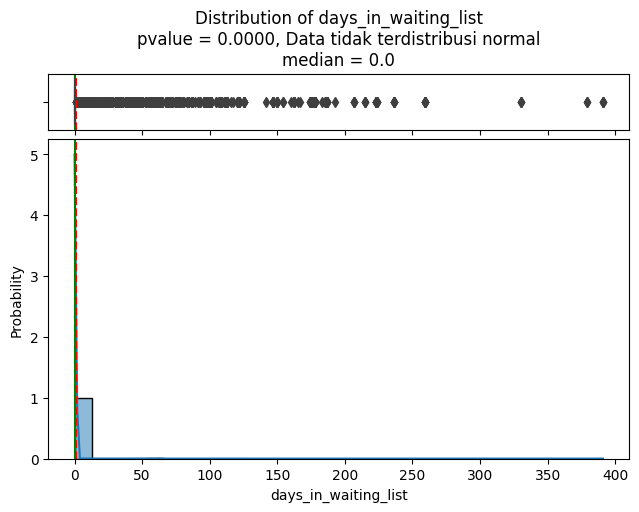

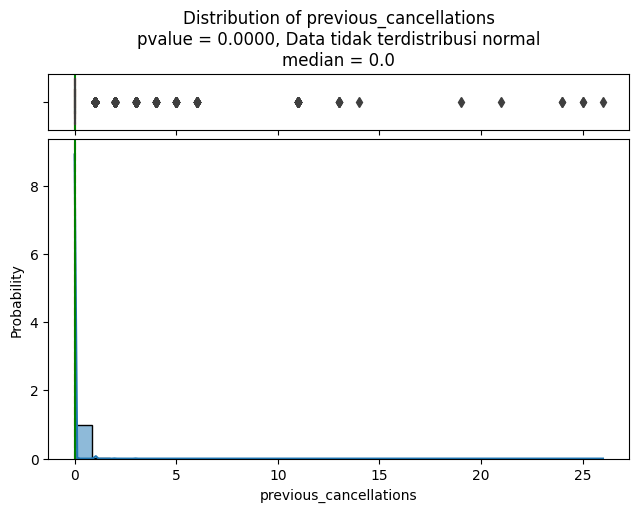

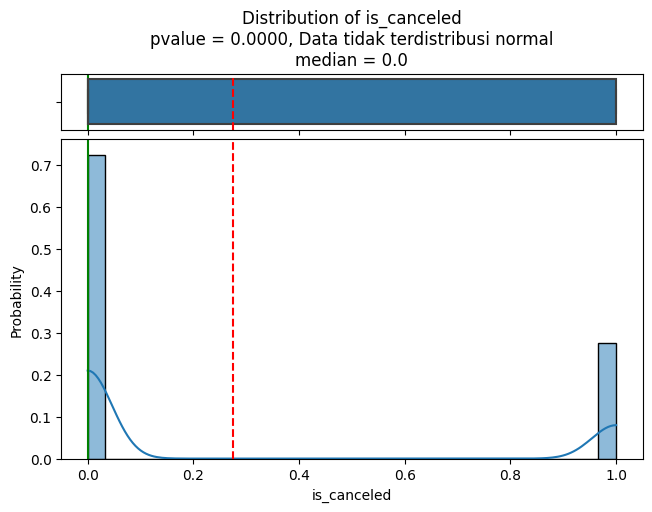

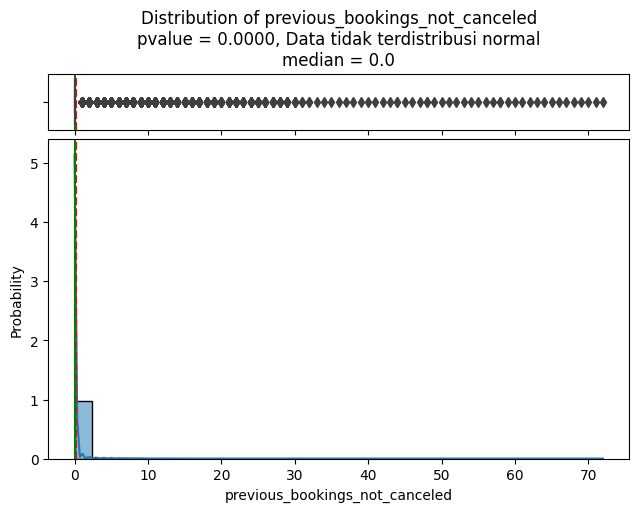

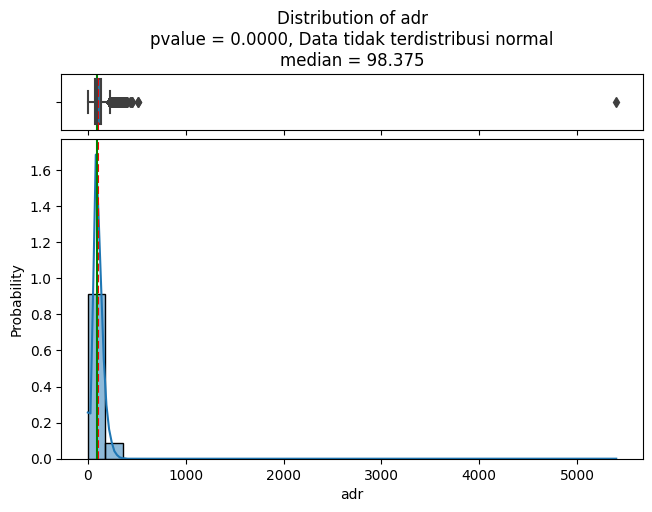

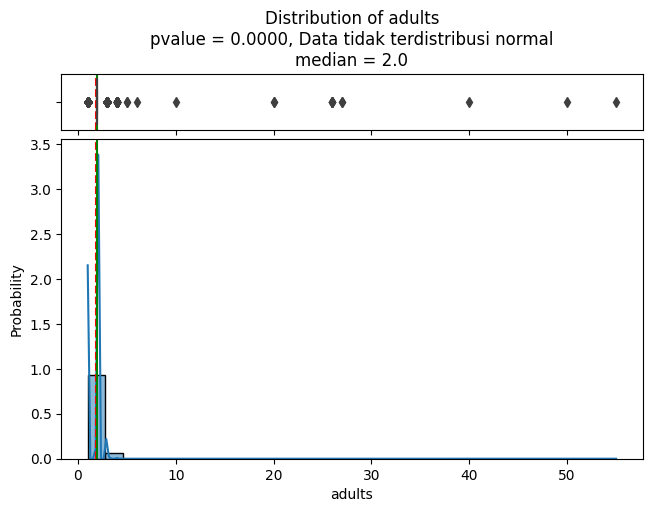

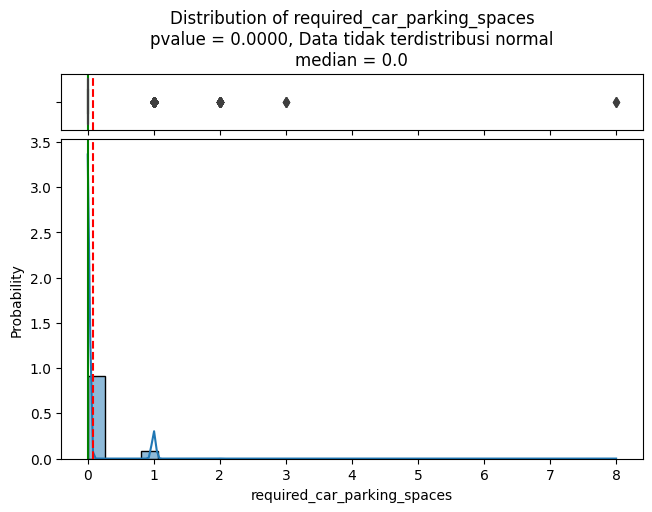

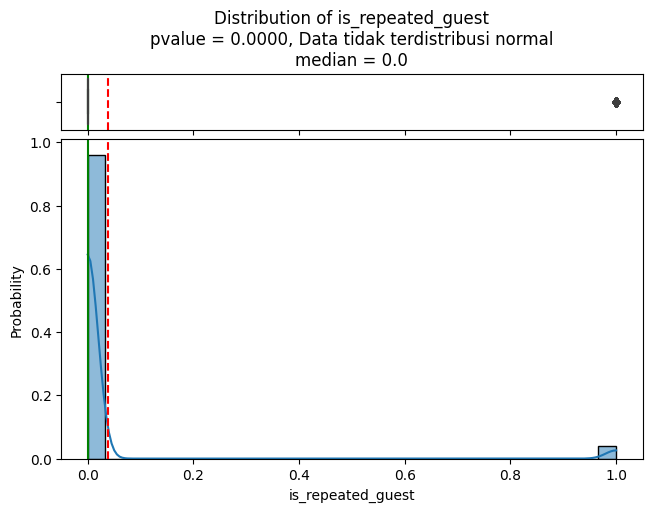

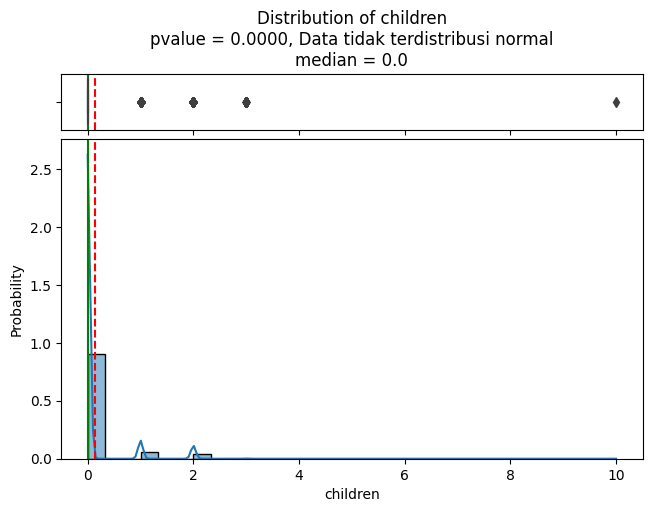

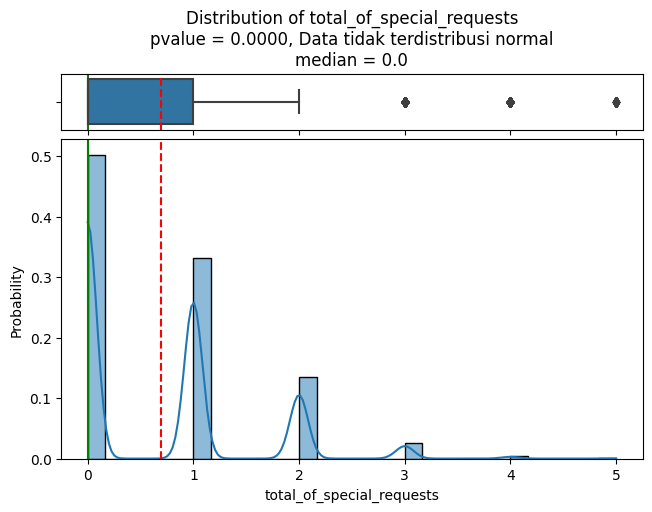

In [44]:
# melihat distribusi data kolom numerikal
for i, j in enumerate(dfnum) :

     fig, (ax1, ax2) = plt.subplots(2, sharex = True, figsize = (7.5,5), 
                                   gridspec_kw={"height_ratios": (.15, .85),
                                               "hspace": 0.05})

     pvalue=normaltest(df[j])[1]
     if pvalue > 0.05 :
          text = (f'pvalue = {pvalue:.4f}, Data terdistribusi normal')
     else :
         text = (f'pvalue = {pvalue:.4f}, Data tidak terdistribusi normal')

     ax1.set_title(f"Distribution of {j}\n{text}\nmedian = {df[j].median()}", color = "black")
     sns.boxplot(x = df[j], ax = ax1)
     ax1.axvline(df[j].mean(), color='r', linestyle='--')
     ax1.axvline(df[j].median(), color='g', linestyle='-')
     ax1.set(xlabel = "")
     sns.histplot(data = df[j], ax = ax2, stat = "probability", kde=True, bins=30)
     ax2.axvline(df[j].mean(), color='r', linestyle='--')
     ax2.axvline(df[j].median(), color='g', linestyle='-')
     plt.show()

Berdasarkan pengamatan distribusi data dari kolom numerikal dapat dilihat bahwa:
- required_car_parking_spaces berada di rentang 0-3. dan paling banyak berada di angka 0. Terdapat outlier di angka 8
- children berada di rentang 0-3. dan paling banyak berada di angka 0. Terdapat outlier di angka 10
- is_repeated_guest berada di rentang angka 0 dan 1. Paling banyak berada di angka 0 yang artinya bukan repeated guest
- previous_cancellations berada di rentang angka 0-5. lebih dari 10 merupakan outlier
- stays_in_week_nights berada di rentang 0-10. 10 keatas merupakan outlier
- arrival_date_day_of_month berada di rentang 1-30. Paling banyak berada di angka 30
- lead_time berada di rentang 0-750. 120 keatas adalah outlier. Terdapat data yang jauh dari kumpulan yaitu di angka 700 keatas
- adults  berada di rentang 1-60. paling banyak di 1 dan 2
- babies berada di rentang 0-3. oulier berada di angka 8 dan 10
- days_in_waiting_list berada di angka 0 sampai 400 dengan di angka 0 paling banyak. 250 keatas merupakan outlier
- total_of_special_requests berada di rentang 0-5 dengan paling banyak di angka 0-3
- arrival_date_week_number berada di rentang 1-53
- stays_in_weekend_nights berada di angka 0-17 dengan paling banyak di 0-5. 5 keatas merupakan outlier
- previous_bookings_not_canceled  berada di rentang 0-70an. paling banyak di 0
- adr, ada angka yang paling jauh sendiri yaitu di 5000
- booking_changes berada di rentang 0-17.5 dengan paling banyak di 0


In [45]:
categorical_cols = ['hotel', 'arrival_date_month', 'meal', 'market_segment', 'distribution_channel',
                    'reserved_room_type', 'assigned_room_type', 'deposit_type',
                    'customer_type', 'reservation_status']

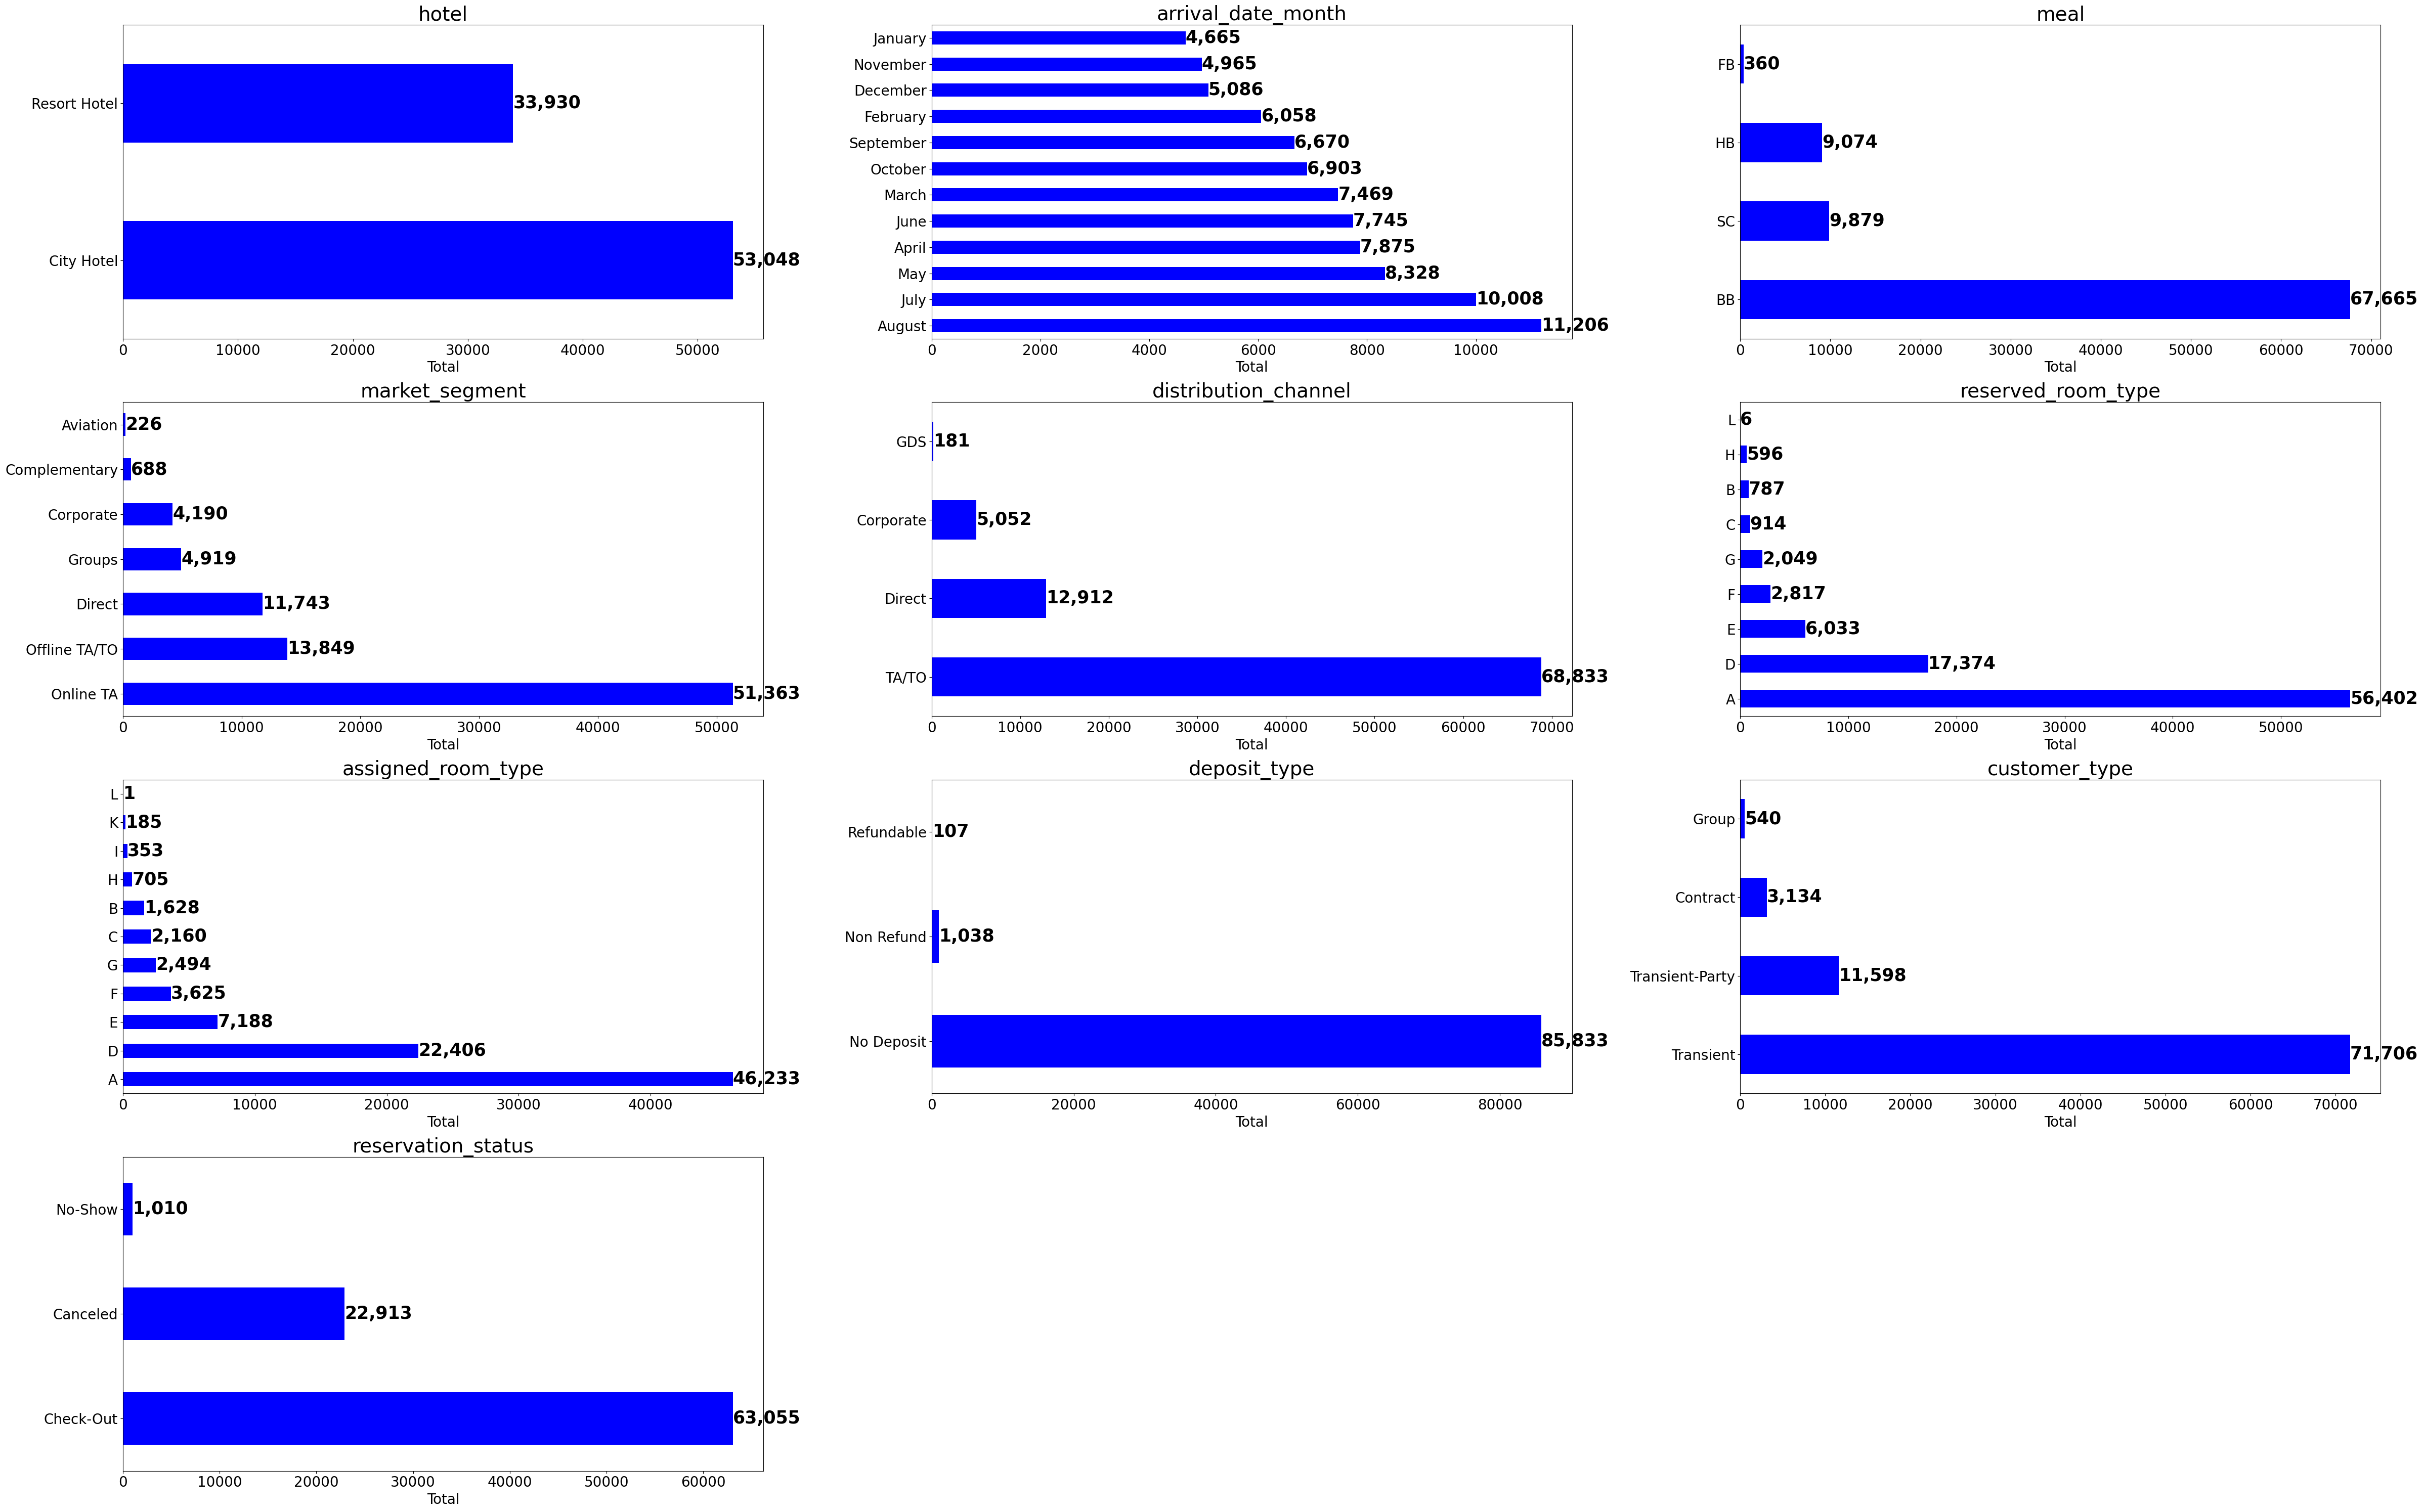

In [46]:
# Categorical variable visualization
fig = plt.figure(figsize=(48,30))
subplot = 1

for cat in categorical_cols:
    ax = plt.subplot(4,3,subplot)
    ax = df[cat].value_counts().plot(kind='barh', color=['blue'])
    plt.xlabel('Total', size=20)
    plt.ylabel(None)
    plt.title(cat, size=28)
    plt.tick_params(axis='both', which='major', labelsize=20)
    container = ax.containers[0]
    ax.bar_label(container , labels=[f'{x:,.0f}' for x in container.datavalues], label_type='edge', padding = 0, color="black", fontweight='bold', size=25)
    plt.tight_layout(w_pad = 3)
    subplot+=1

Berdasarkan pengamatan kolom categorikal dapat dilihat bahwa:
- hotel, tipe hotel paling banyak jumlahnya adalah hotel city
- arrival date month, yang merupakan bulan kedatangan untuk menginap paling banyak di agustus dan paling sedikit di januari
- meal, tipe meal paling banyak adalah  BB - Tempat Tidur & Sarapan dan paling sedikit adalah FB - Full board (sarapan, makan siang dan makan malam)
- market segment, yang merupakan Penunjukan segmen pasar, paling banyak adalah dari onlline travel agent dan paling sedikit dari aviation (penerbangan)
- distribution channel, yang merupakan Saluran distribusi pemesanan, paling banyak dari tour agent/tour operator dan paling sedikit adalah dari GDS (Sistem Distribusi Global adalah sistem reservasi di seluruh dunia yang bertindak sebagai penghubung antara pemesan perjalanan dan pemasok, seperti hotel, penyedia akomodasi lainnya dan layanan terkait perjalanan lainnya.)
- reserved room type, yang merupakan Kode tipe kamar yang dipesan. paling banyak adalah tipe A dan paling sedikit tipe L
- assigned room type, yang merupakan Kode untuk jenis kamar yang ditetapkan untuk pemesanan. paling banyak adalah tipe A dan paling sedikit tipe L
- deposit type paling banyak no deposit dan paling sedikit adalah refundable : deposit dibuat dengan nilai di bawah total biaya menginap
- customer type paling banyak adalah tipe Transient : ketika pemesanan bukan bagian dari grup atau contract, dan tidak terkait dengan pemesanan transient lainnya; dan paling sedikit adalah group : ketika pemesanan dikaitkan dengan grup
- reservation status paling banyak adalah check out dan paling sedikit adalah no show: pelanggan tidak melakukan check-in dan menginformasikan alasannya kepada pihak hotel

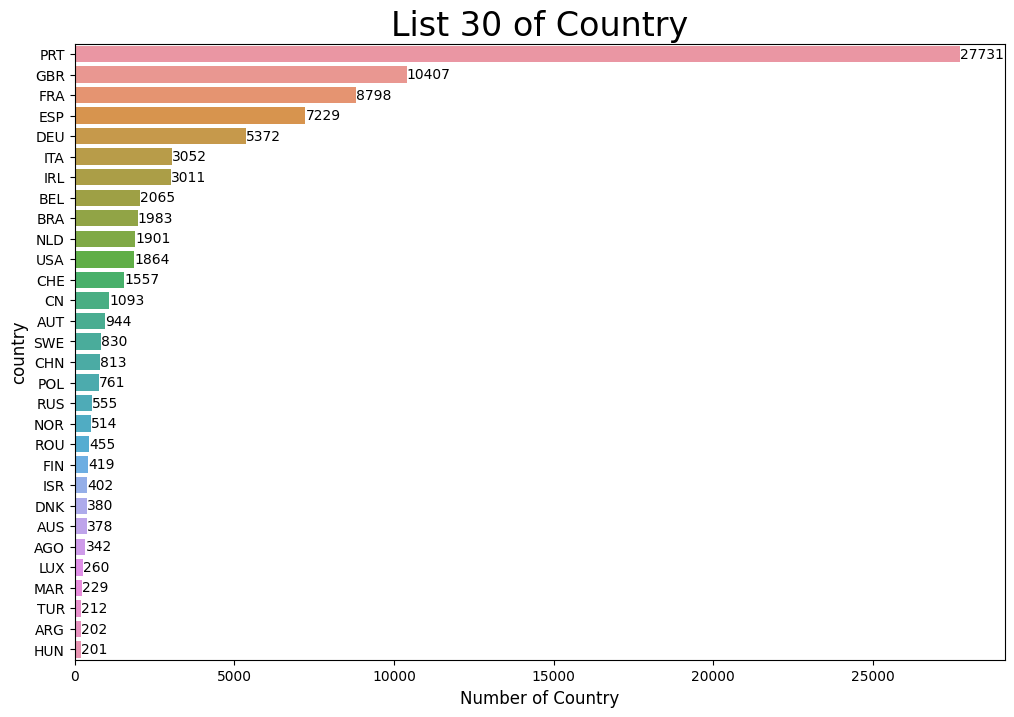

In [47]:
# melihat distribusi dari country
plt.figure(figsize=(12,8))
ax = sns.countplot(
    data=df,
    y='country',
    order=df['country'].value_counts().iloc[:30].index
)

ax.set_xlabel('Number of Country', size=12)
ax.set_ylabel('country', size=12)
ax.set_title('List 30 of Country', size=24)
for container in ax.containers:
    ax.bar_label(container)


plt.show()

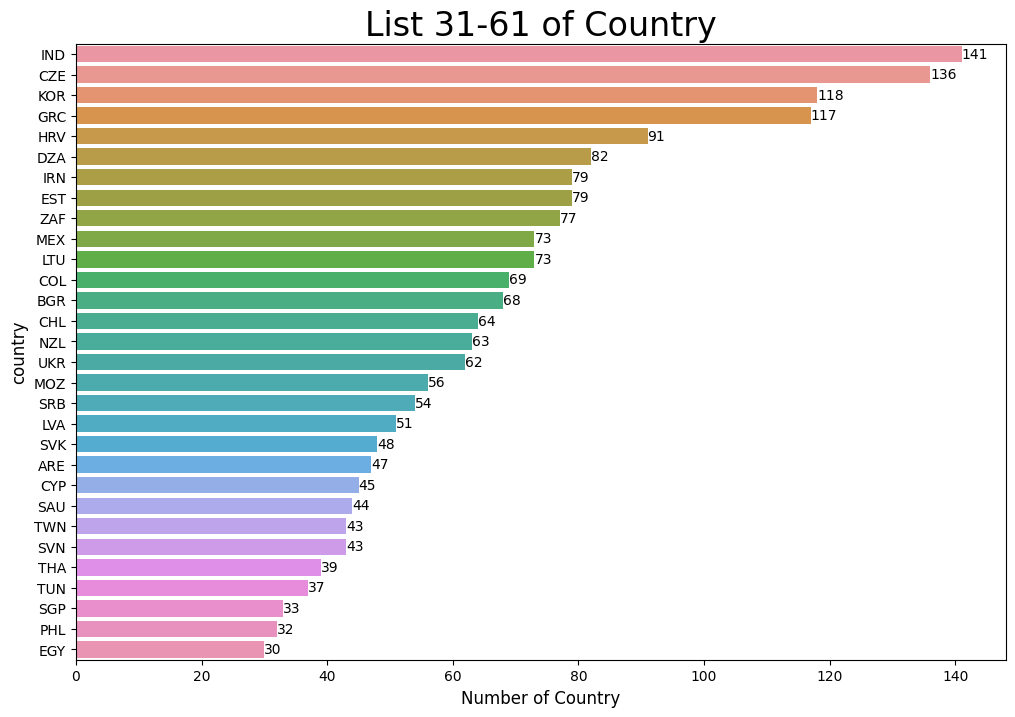

In [48]:
plt.figure(figsize=(12,8))
ax = sns.countplot(
    data=df,
    y='country',
    order=df['country'].value_counts().iloc[31:61].index
)

ax.set_xlabel('Number of Country', size=12)
ax.set_ylabel('country', size=12)
ax.set_title('List 31-61 of Country', size=24)
for container in ax.containers:
    ax.bar_label(container)


plt.show()

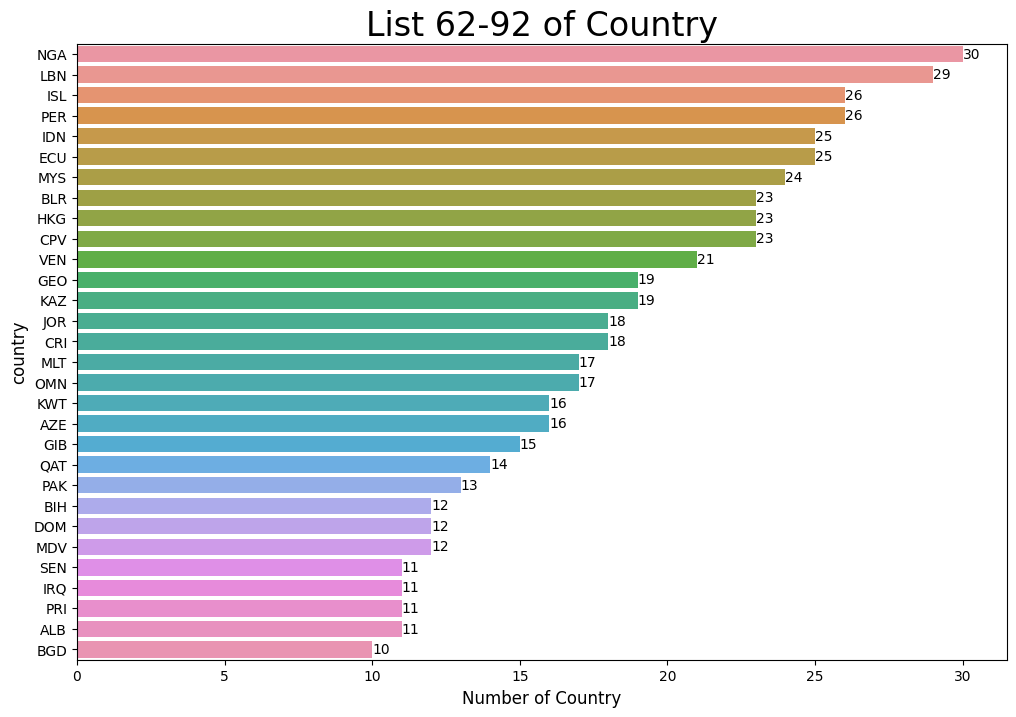

In [49]:
plt.figure(figsize=(12,8))
ax = sns.countplot(
    data=df,
    y='country',
    order=df['country'].value_counts().iloc[62:92].index
)

ax.set_xlabel('Number of Country', size=12)
ax.set_ylabel('country', size=12)
ax.set_title('List 62-92 of Country', size=24)
for container in ax.containers:
    ax.bar_label(container)


plt.show()

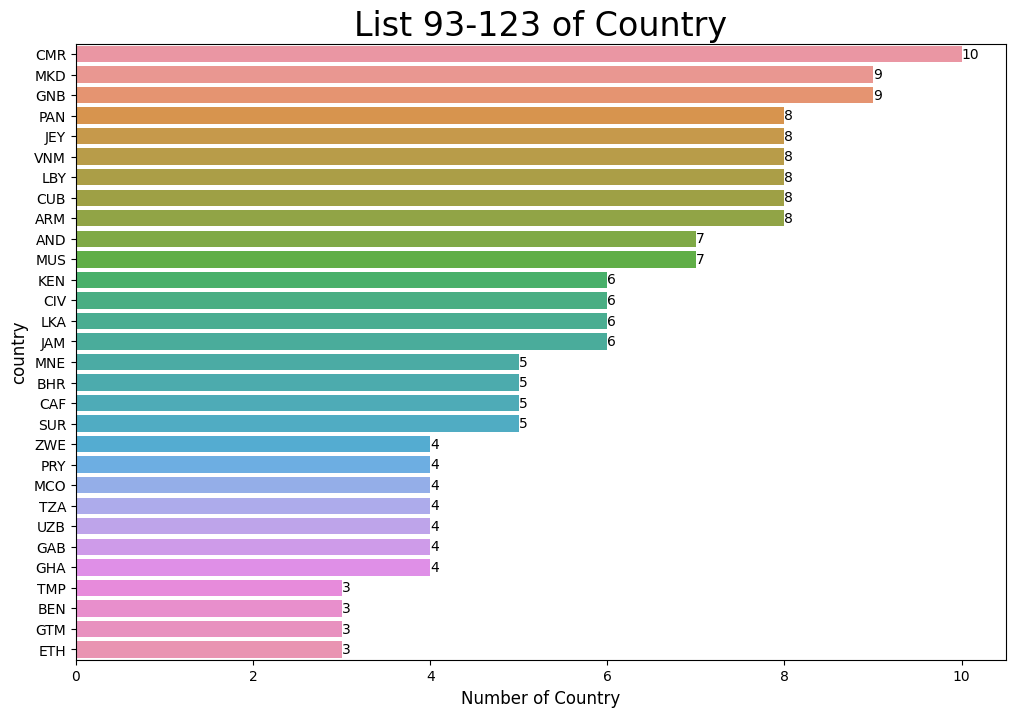

In [50]:
plt.figure(figsize=(12,8))
ax = sns.countplot(
    data=df,
    y='country',
    order=df['country'].value_counts().iloc[93:123].index
)

ax.set_xlabel('Number of Country', size=12)
ax.set_ylabel('country', size=12)
ax.set_title('List 93-123 of Country', size=24)
for container in ax.containers:
    ax.bar_label(container)


plt.show()

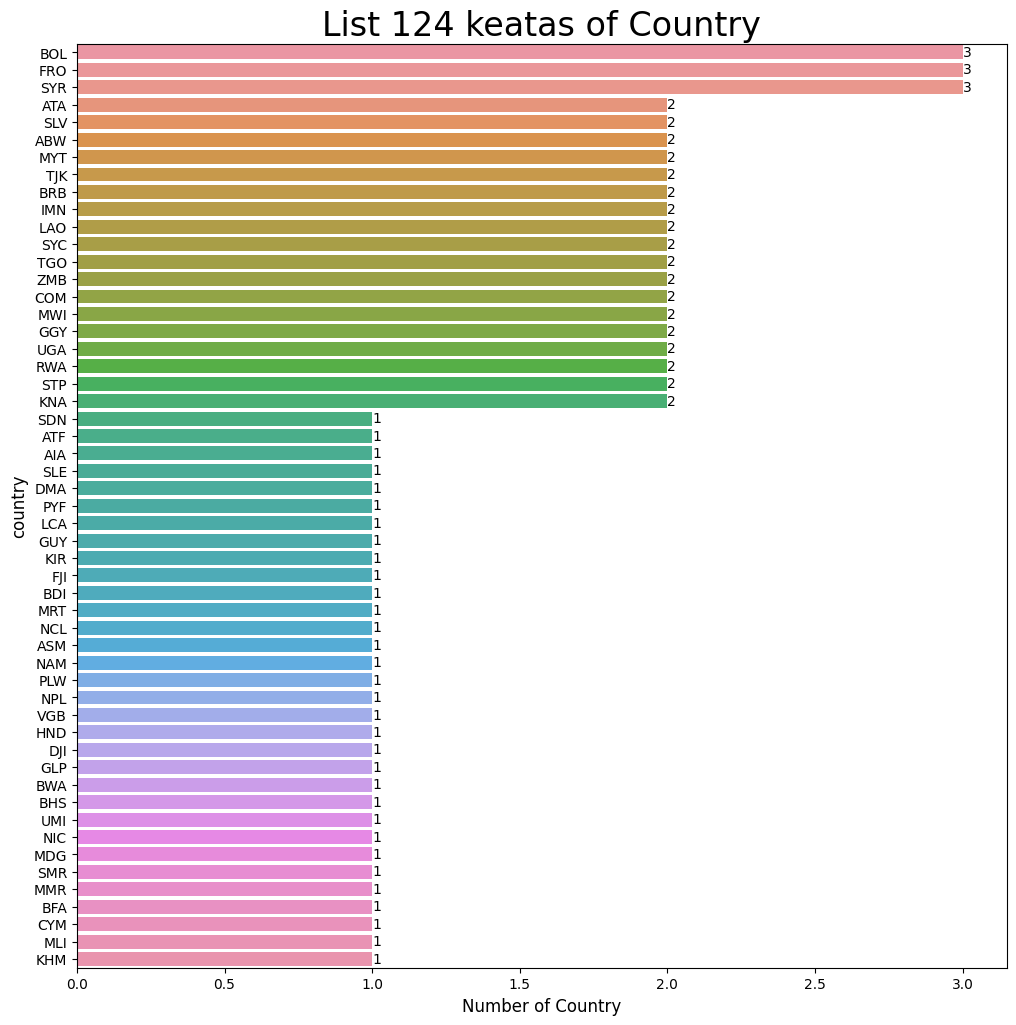

In [51]:
plt.figure(figsize=(12,12))
ax = sns.countplot(
    data=df,
    y='country',
    order=df['country'].value_counts().iloc[124:].index
)

ax.set_xlabel('Number of Country', size=12)
ax.set_ylabel('country', size=12)
ax.set_title('List 124 keatas of Country', size=24)
for container in ax.containers:
    ax.bar_label(container)


plt.show()

Berdasarkan country, tamu yang melakukan reservasi paling banyak dari negara PRT-portugal dan paling sedikit dari berjumlah hanya 1 negara adalah negara SDN-SUDAN, ATF-Prancis Selatan, AIA- Anguilla, SLE-Sierra Leone, DMA-Dominica, PYF-French Polynesia, LCA-Saint Lucia, GUY-Guyana, KIR-Kiribati, FJI-Fiji, BDI-Burundi, MRT-Mauritania, NCL-New Caledonia
, ASM-American Samoa, NAM-Namibia, PLW-Palau, NPL-Nepal, VGB-British Virgin Islands, HND-Honduras, DJI-Djibouti, GLP-Guadeloupe, BWA-Botswana, BHS-Bahamas, UMI-United States Minor Outlying Islands, NIC-Nicaragua, MDG-Madagascar, SMR-San Marino, MMR-Myanmar (Burma), BFA-Burkina Faso, CYM-Cayman Islands, MLI-Mali, KHM-Cambodia

saya akan membuat kolom baru 'continent' yang menjelaskan mengenai benua dari customer berasal  

In [52]:
# convert country to benua
# df['continent'] = df.country.apply(lambda x: coco.convert(names=x, to='continent', not_found=None))

In [53]:
# save country convert continent
# df_continent=df.copy()
# df_continent.to_csv('hotel_bookings_continent.csv')

In [54]:
# Load dataset 'country' yang sudah di convert
df=pd.read_csv('hotel_bookings_continent.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86978 entries, 0 to 86977
Data columns (total 33 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      86978 non-null  int64  
 1   hotel                           86978 non-null  object 
 2   is_canceled                     86978 non-null  int64  
 3   lead_time                       86978 non-null  int64  
 4   arrival_date_year               86978 non-null  int64  
 5   arrival_date_month              86978 non-null  object 
 6   arrival_date_week_number        86978 non-null  int64  
 7   arrival_date_day_of_month       86978 non-null  int64  
 8   stays_in_weekend_nights         86978 non-null  int64  
 9   stays_in_week_nights            86978 non-null  int64  
 10  adults                          86978 non-null  int64  
 11  children                        86978 non-null  float64
 12  babies                          

In [55]:
df.drop(columns = ['Unnamed: 0'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86978 entries, 0 to 86977
Data columns (total 32 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           86978 non-null  object 
 1   is_canceled                     86978 non-null  int64  
 2   lead_time                       86978 non-null  int64  
 3   arrival_date_year               86978 non-null  int64  
 4   arrival_date_month              86978 non-null  object 
 5   arrival_date_week_number        86978 non-null  int64  
 6   arrival_date_day_of_month       86978 non-null  int64  
 7   stays_in_weekend_nights         86978 non-null  int64  
 8   stays_in_week_nights            86978 non-null  int64  
 9   adults                          86978 non-null  int64  
 10  children                        86978 non-null  float64
 11  babies                          86978 non-null  int64  
 12  meal                            

kolom agent yang menjelaskan mengenai ID biro perjalanan akan diubah menjadi tipe data object karena data tersebut merupakan kategorikal yang berbentuk angka

In [56]:
# mengubah data type float to object
df['agent'] = df['agent'].astype('object', errors='ignore')

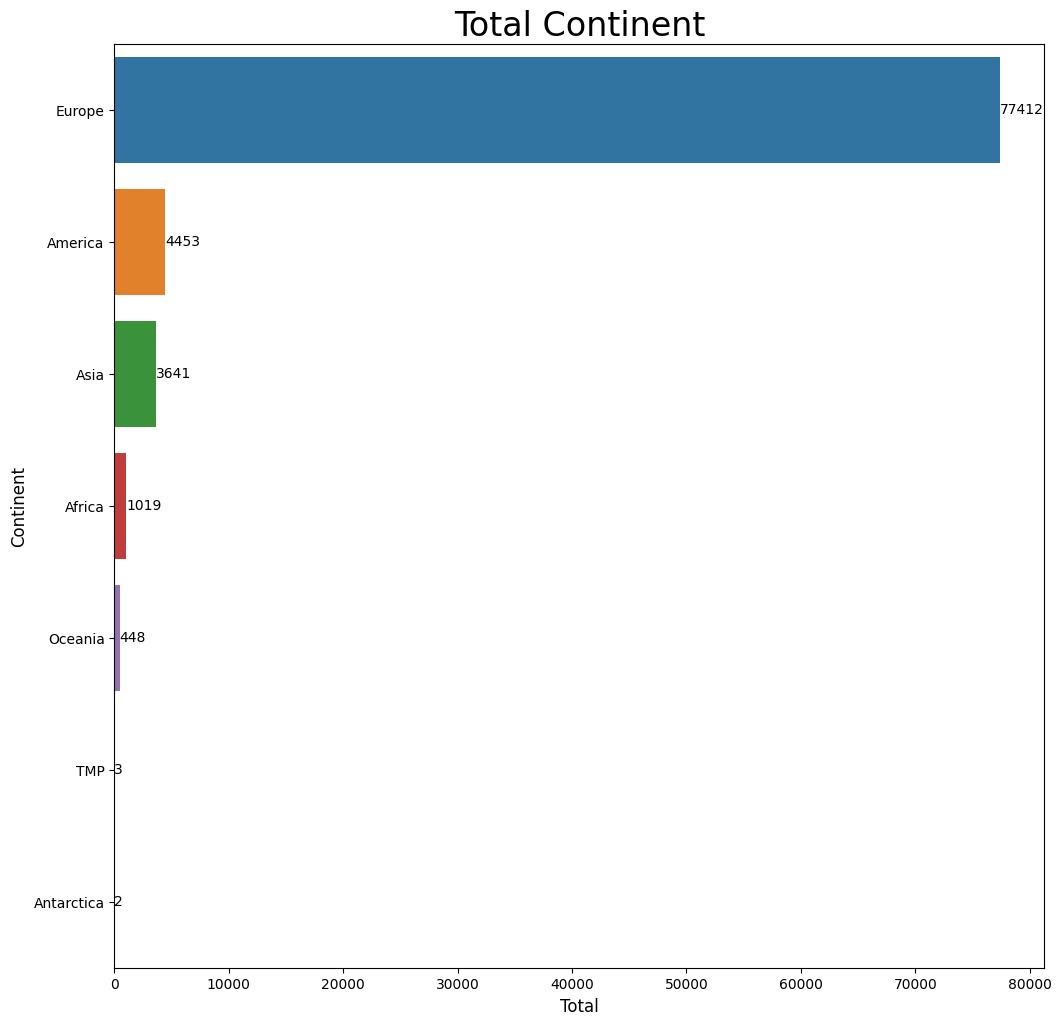

In [57]:
# melihat distribusi dari continent
plt.figure(figsize=(12,12))
ax = sns.countplot(
    data=df,
    y='continent',
    order=df['continent'].value_counts().index
)

ax.set_xlabel('Total', size=12)
ax.set_ylabel('Continent', size=12)
ax.set_title('Total Continent', size=24)
for container in ax.containers:
    ax.bar_label(container)


plt.show()

country code by ISO3 untuk TMP tidak terdaftar. TMP adalah ISO3 untuk Timor Leste, yang sekarang country code untuk Timor Leste sudah diganti menjadi TLS. Maka saya akan merubah TMP menjadi Asia, karena timor leste berada di benua asia.

In [58]:
# rename TMP to asia
df['continent'] = df['continent'].replace('TMP', 'Asia')

In [59]:
# cek jumlah unique value dari continent
df['continent'].value_counts()

Europe        77412
America        4453
Asia           3644
Africa         1019
Oceania         448
Antarctica        2
Name: continent, dtype: int64

Customer yang paling banyak melakukan reservasi adalah customer dari benua Eropa.

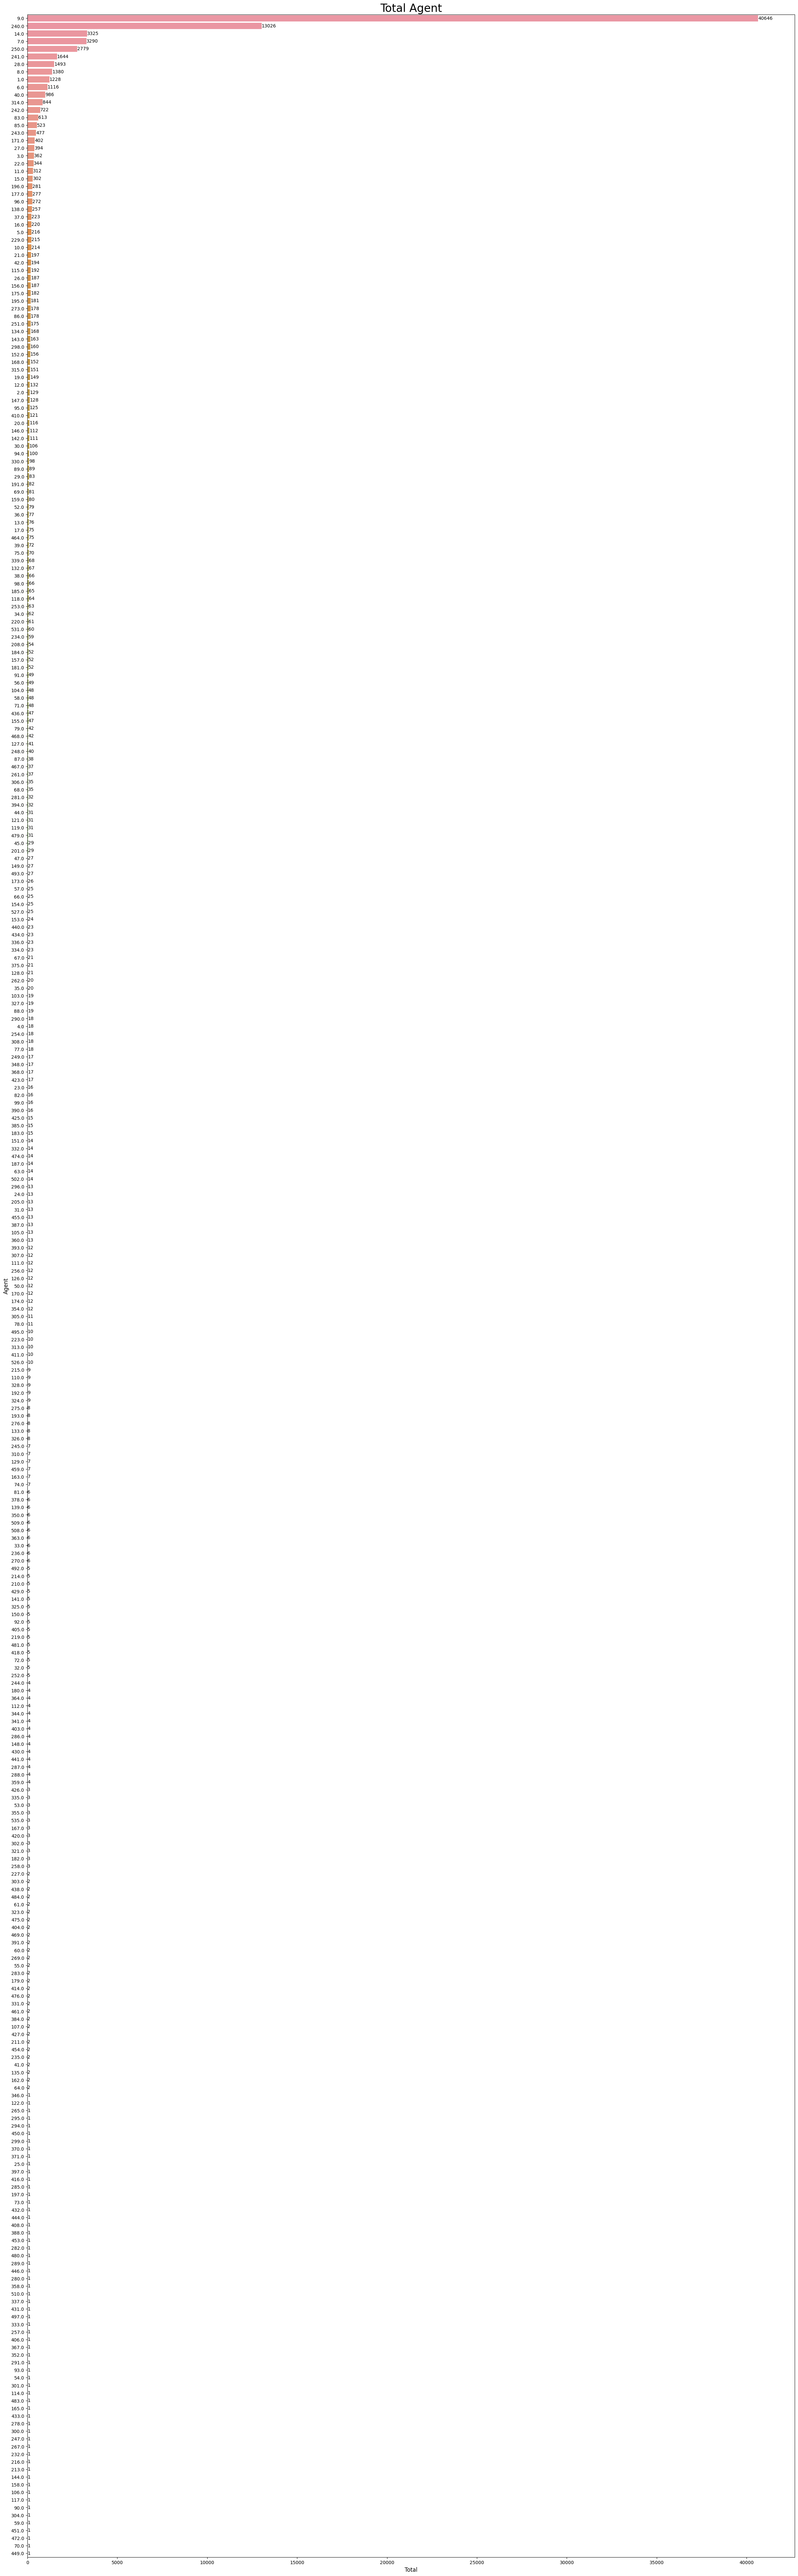

In [60]:
# melihat distribusi dari agent
plt.figure(figsize=(30,100))
ax = sns.countplot(
    data=df,
    y='agent',
    order=df['agent'].value_counts().index
)

ax.set_xlabel('Total', size=12)
ax.set_ylabel('Agent', size=12)
ax.set_title('Total Agent', size=24)
for container in ax.containers:
    ax.bar_label(container)


plt.show()

Berdasarkan distribusi agent, kode ID perjalanan dengan ID 9 adalah yang paling banyak melakukan reservasi.

# Bivariate Analysis

In [61]:
# cek kolom numerikal dan categorical
dfcat = list(df.select_dtypes(['object']).columns)
dfnum = list(set(df.columns)-set(dfcat))

print(f'Number of numerical features: {len(dfnum)-1}')
print(f'numerical features: {[cols for cols in dfnum if cols != "is_canceled"]}')
print(f'\nNumber of categorical features: {len(dfcat)}')
print(f'Categorical features: {dfcat}')

Number of numerical features: 17
numerical features: ['stays_in_week_nights', 'arrival_date_day_of_month', 'babies', 'lead_time', 'arrival_date_year', 'arrival_date_week_number', 'stays_in_weekend_nights', 'booking_changes', 'days_in_waiting_list', 'previous_cancellations', 'previous_bookings_not_canceled', 'adr', 'adults', 'required_car_parking_spaces', 'is_repeated_guest', 'children', 'total_of_special_requests']

Number of categorical features: 14
Categorical features: ['hotel', 'arrival_date_month', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'agent', 'customer_type', 'reservation_status', 'reservation_status_date', 'continent']


In [62]:
# numerikal diskrit
dfdis = ['stays_in_weekend_nights', 'stays_in_week_nights','arrival_date_day_of_month','required_car_parking_spaces', 'arrival_date_year','previous_cancellations',
 'children', 'babies', 'is_repeated_guest','total_of_special_requests','adults', 'booking_changes','arrival_date_week_number']

# numerikal kontinu
dfkon = ['adr','lead_time','days_in_waiting_list','previous_bookings_not_canceled']

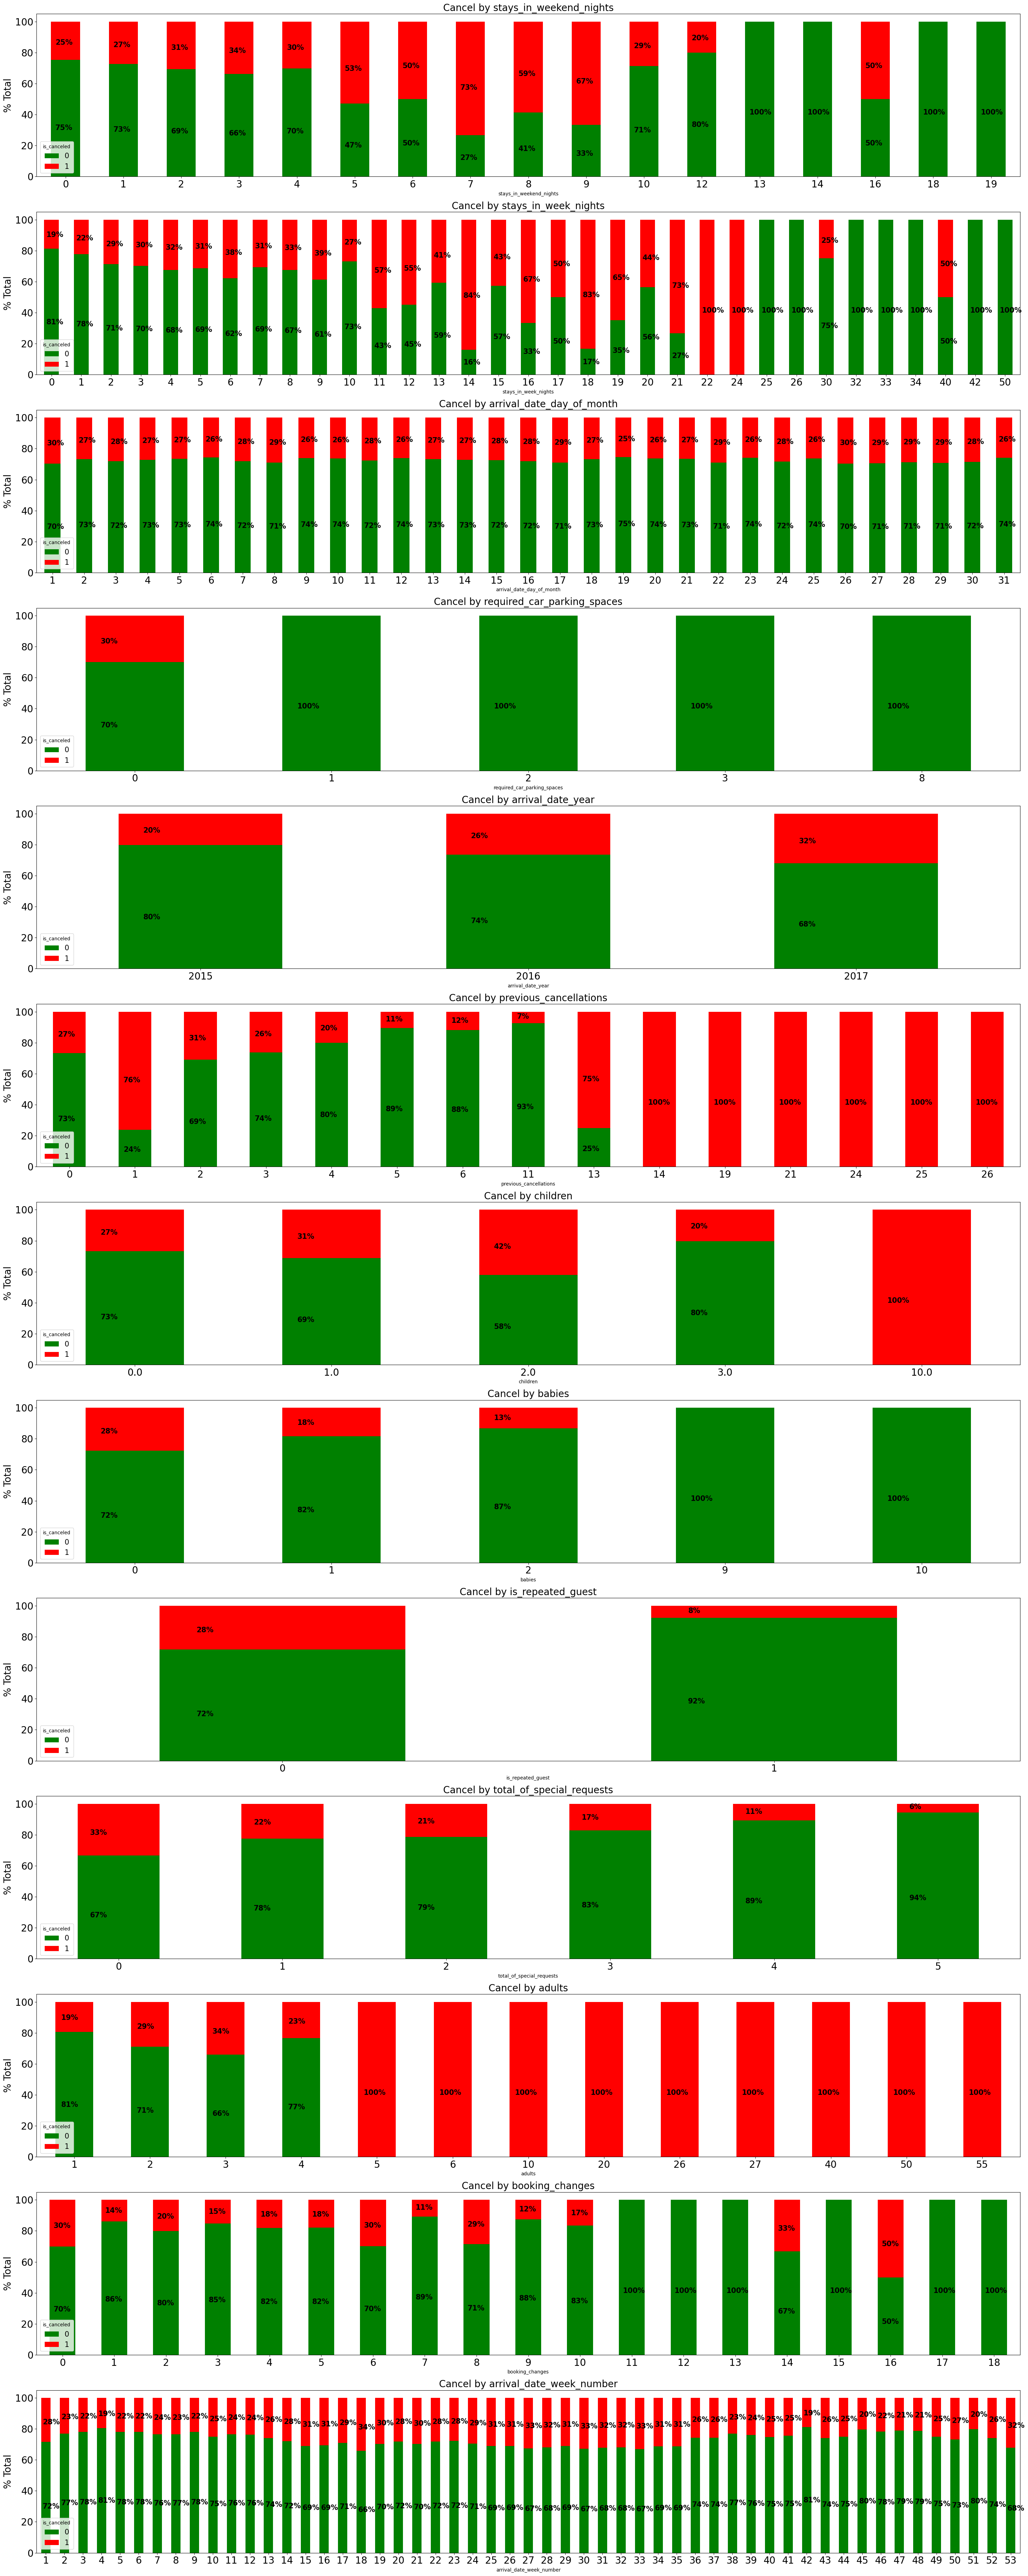

In [63]:
# melihat distribusi dari feature numerikal diskrit berdasarkan cancel

plt.figure(figsize=(30, 75), facecolor='white')
plotnumber = 1

for feature in dfdis:

        column1 = feature

        # membuat table berdasarkan 2 kolom kategorikal
        groupby_table = df.groupby([column1,'is_canceled']).size().unstack()

        # fungsi untuk pelabelan dimana jika nilainya 0 tidak akan ditampilkan
        def show() :
            if height > 0 :
                return '{:.0f}%'.format(height)
            else :
                return '' 
        
        # subplot (letak grafik)
        ax = plt.subplot(13,1 , plotnumber)
        
        # cancel berdasarkan feature 
        (groupby_table.T*100.0 / groupby_table.T.sum()).T.plot(kind='bar',
                                                                width = 0.5,
                                                                stacked = True,
                                                                rot = 0, 
                                                                ax = ax,
                                                                color = ['green', 'red'])

        ax.legend(loc = 'lower left', prop={'size':15},title = 'is_canceled')
        ax.set_ylabel('% Total', size=20)
        ax.set_title(f'Cancel by {column1}',size = 20)
        ax.tick_params(axis='both', which='major', labelsize=20)


        # menambahkan label data pada stacked bar chart
        for p in ax.patches:
            width, height = p.get_width(), p.get_height()
            x, y = p.get_xy() 
            ax.annotate(show(), (p.get_x()+0.15*width, p.get_y()+.4*height),
                        color = 'black',
                        weight = 'bold',
                        size = 15)
        
        plt.tight_layout();
        
        plotnumber += 1
    


keterangan: 0 = tidak cancel, 1 =  cancel
- Berdasarkan stay di weekend nights, paling banyak customer yang melakukan cancel adalah customer yang memiliki jumlah stay di weekend nights sebanyak 7 hari dengan persentase sebesar 73%, sedangkan paling sedikit customer yang melakukan cancel adalah customer yang memiliki jumlah stay di weekend nights sebanyak 12 hari dengan persentase sebesar 20%. Pada jumlah weekend night 13,14,18, dan 19, customer melakukan cancel sebanyak 0% dikarenakan jumlah customer yang melakukan reservasi pada jumlah weekend tersebut hanya 1-2 customer.
- Berdasarkan stay di week nights, paling banyak customer yang melakukan cancel adalah customer yang memiliki jumlah stay di week nights sebanyak 16 hari dengan persentase sebesar 84% dan juga pada jumlah stay di week nights sebanyak 22 dan 24 hari dengan persentase 100% (dengan jumlah customer yang reservasi 22 hari sebanyak 7 dan 24 hari sebanyak 2 customer), sedangkan paling sedikit customer yang melakukan cancel adalah customer yang memiliki jumlah stay di week nights sebanyak 0 hari dengan persentase sebesar 19%. Pada jumlah week night 25,26,32,33,42 dan 50, customer melakukan cancel sebanyak 0% dikarenakan jumlah customer yang melakukan reservasi pada jumlah week nights tersebut hanya 1-6 customer.
- Berdasarkan hari tanggal kedatangan, paling banyak customer yang melakukan cancel adalah customer yang akan menginap pada tanggal 1, 22, 26, 29 dengan masing-masing persentase sebesar 29%, sedangkan paling sedikit customer yang melakukan cancel adalah customer yang akan menginap pada tanggal 6, 9, 19, 31 dengan masing-masing persentase sebesar 25%.
- Berdasarkan permintaan parking spaces, paling banyak customer yang melakukan cancel adalah customer yang tidak meminta parking space dengan persentase sebesar 30%, sedangkan paling sedikit customer yang melakukan cancel adalah customer yang meminta parking space berjumlah 1, 2,3 dan 8 parking space dengan masing-masing persentase sebesar 0%. Artinya jumlah permintaan parking spaces berbanding lurus dengan jumlah customer tidak melakukan cancel (makin banyak customer meminta parking space maka makin banyak jumlah customer tidak cancel, begitupun sebaliknya)
- Berdasarkan tahun kedatangan, paling banyak customer yang melakukan cancel adalah customer yang akan menginap di tahun 2017 dengan persentase sebesar 31%, sedangkan paling sedikit customer yang melakukan cancel adalah customer yang akan menginap di tahun 2015 dengan persentase sebesar 20%.
- Berdasarkan jumlah cancel sebelumnya, paling banyak customer yang melakukan cancel adalah customer yang melakukan cancel sebelumnya sebanyak 14,19,21,24,25,26 kali dengan persentase sebesar 100% dengan jumlah customer sebanyak 1-2 orang, diurutan selanjutnya adalah di jumlah cancel sebelumnya sebanyak 1 dan 13 kali dengan masing-masing persentase sebesar 76% dan 75%. Sedangkan paling sedikit customer yang melakukan cancel adalah customer yang melakukan cancel sebelumnya sebanyak 11 kali dengan persentase sebesar 7%.
- Berdasarkan jumlah children (1-12 tahun) yang dibawa untuk menginap, paling banyak customer yang melakukan cancel adalah yang membawa children sebanyak 2 orang dengan persentase sebesar 41% dan 10 orang children sebanyak 100% (jumlah yang melakukan reservasi hanya 1 orang). sedangkan paling sedikit customer yang melakukan cancel adalah customer yang membawa children sebanyak 3 orang dengan persentase sebesar 20%. Artinya bahwa jumlah children yang dibawa tidak berpengaruh pada seorang customer melakukan cancel.
-  Berdasarkan jumlah baby (1 bulan - 1 tahun) yang dibawa untuk menginap, paling banyak customer yang melakukan cancel adalah yang membawa bayi sebanyak 0 orang dengan persentase sebesar 28%, sedangkan paling sedikit customer yang melakukan cancel adalah customer yang membawa bayi sebanyak 2 orang dengan persentase sebesar 13% dan juga yang membawa bayi sebanyak 9 dan 10 orang dengan persentase 0% (jumlah yang melakukan reservasi hanya 1)
-  Berdasarkan tamu yang pernah/belum menginap sebelumnya, paling banyak customer yang melakukan cancel adalah yang belum pernah menginap dengan persentase sebesar 28%, sedangkan paling sedikit customer yang melakukan cancel adalah customer yang pernah menginap sebelumnya dengan persentase sebesar 8%.
- Berdasarkan total special request, paling banyak customer yang melakukan cancel adalah customer yang tidak meminta special request apapun dengan persentase sebesar 33%, sedangkan paling sedikit customer yang melakukan cancel adalah customer yang meminta special request sebanyak 5 dengan persentase sebesar 6%. Makin banyak special request maka makin sedikit customer melakukan cancel.
-  Berdasarkan jumlah orang dewasa, paling banyak customer yang melakukan cancel adalah customer yang membawa jumlah orang dewasa sebanyak 6,10,20,26,27,40,50 dan 55 orang dengan persentase masing-masing sebesar 100%, sedangkan paling sedikit customer yang melakukan cancel adalah customer yang membawa orang dewasa sebanyak 1 dengan persentase sebesar 19%. Makin banyak orang dewasa maka makin banyak customer melakukan cancel.
-  Berdasarkan jumlah perubahan booking, paling banyak customer yang melakukan cancel adalah customer yang melakukan perubahan booking sebanyak 0 dan 6 kali dengan persentase masing-masing sebesar 30%, sedangkan paling sedikit customer yang melakukan cancel adalah customer yang melakukan perubahan booking sebanyak 11,12,13,15,17 dan 18 kali dengan persentase sebesar 0% (jumlah yang melakukan perubahan booking hanya 1-5).
-  Berdasarkan jumlah minggu/tahun untuk kedatangan menginap, paling banyak customer yang melakukan cancel adalah customer yang jumlah minggunya sebanyak 18 minggu dengan persentase sebesar 34%, sedangkan paling sedikit customer yang melakukan cancel adalah customer yang jumlah minggunya sebanyak 4 dan 42 minggu dengan persentase masing-masing sebesar 19%.

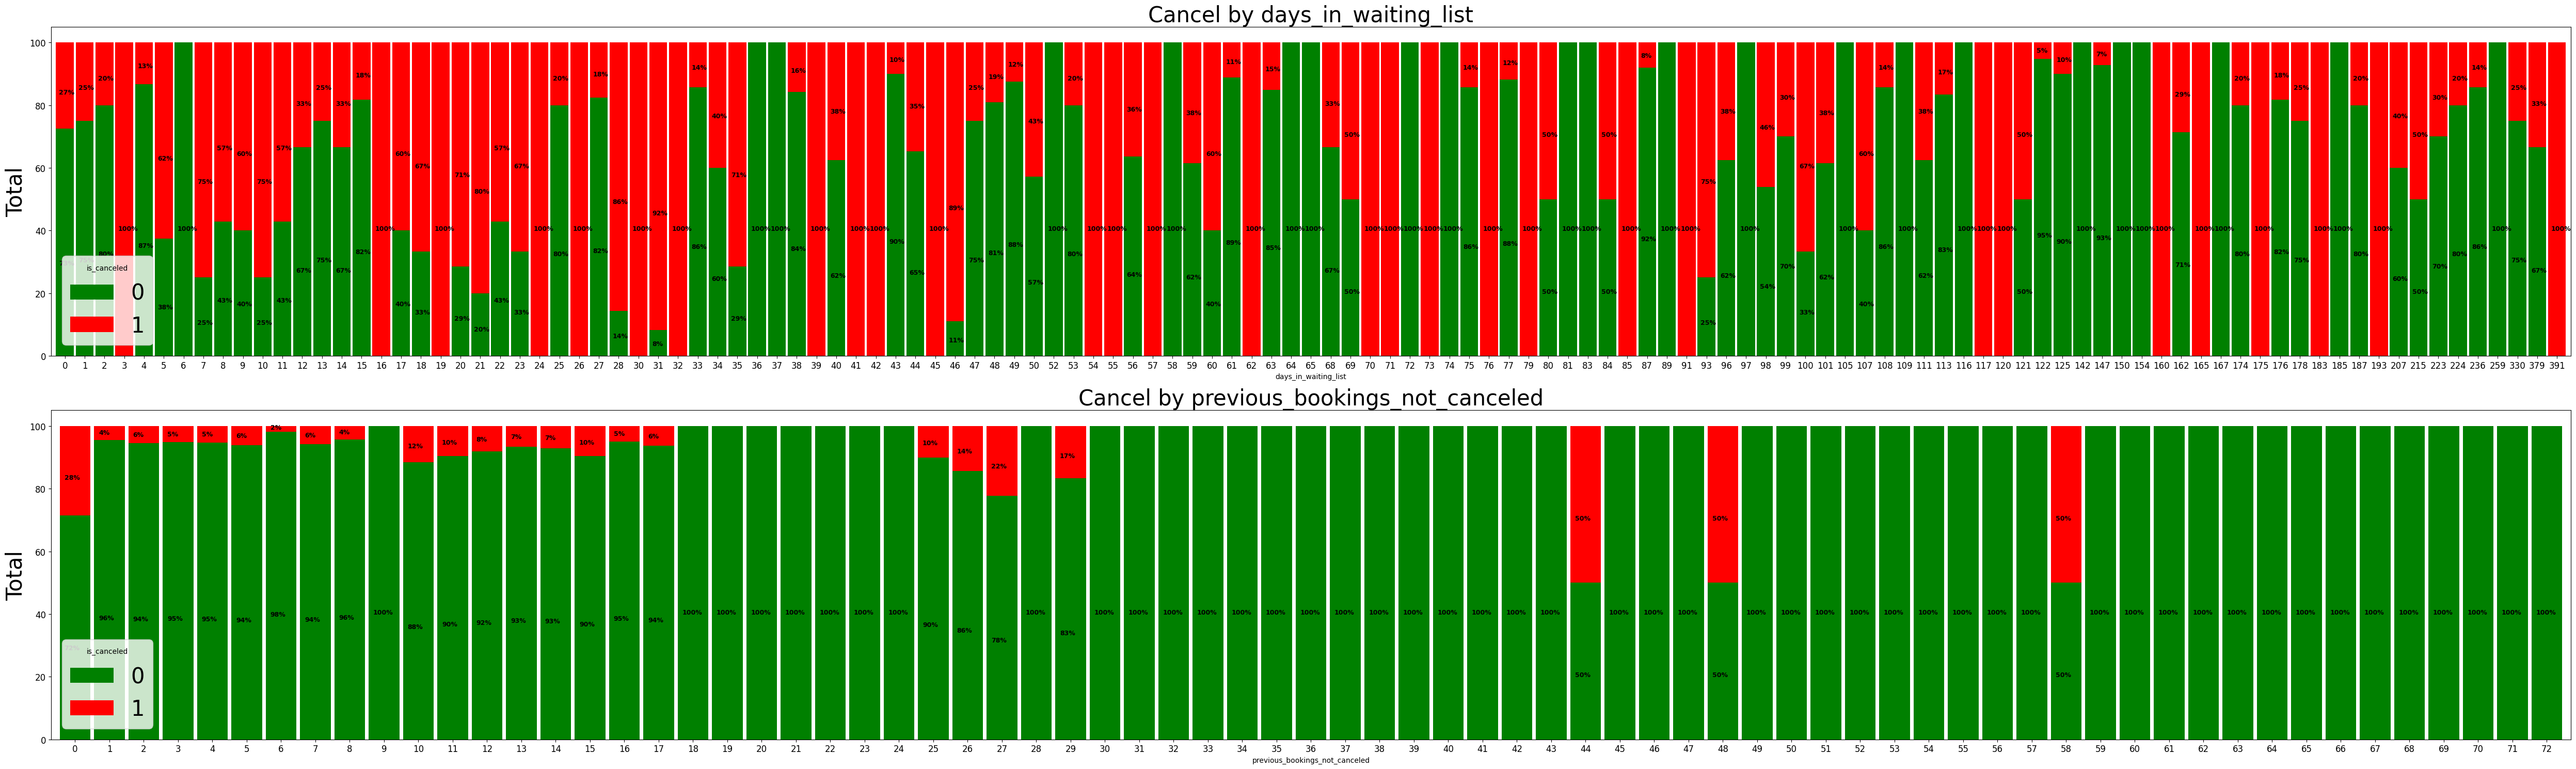

In [64]:
# melihat distribusi dari feature numerikal diskrit berdasarkan cancel

dis = ['days_in_waiting_list','previous_bookings_not_canceled']
plt.figure(figsize=(50, 15), facecolor='white')
plotnumber = 1

for feature in dis:

        column1 = feature

        # membuat table berdasarkan 2 kolom kategorikal
        groupby_table = df.groupby([column1,'is_canceled']).size().unstack()

        # fungsi untuk pelabelan dimana jika nilainya 0 tidak akan ditampilkan
        def show() :
            if height > 0 :
                return '{:.0f}%'.format(height)
            else :
                return '' 
        
        # subplot (letak grafik)
        ax = plt.subplot(2,1 , plotnumber)
        
        # cancel berdasarkan feature 
        (groupby_table.T*100.0 / groupby_table.T.sum()).T.plot(kind='bar',
                                                                width = 0.9,
                                                                stacked = True,
                                                                rot = 0, 
                                                                ax = ax,
                                                                color = ['green', 'red'])

        ax.legend(loc = 'lower left', prop={'size':30},title = 'is_canceled')
        ax.set_ylabel('Total', size=30)
        ax.set_title(f'Cancel by {column1}',size = 30)
        ax.tick_params(axis='both', which='major', labelsize=12)

        # menambahkan label data pada stacked bar chart
        for p in ax.patches:
            width, height = p.get_width(), p.get_height()
            x, y = p.get_xy() 
            ax.annotate(show(), (p.get_x()+0.15*width, p.get_y()+.4*height),
                        color = 'black',
                        weight = 'bold',
                        size = 9)
        
        plt.tight_layout();
        
        plotnumber += 1
    


keterangan: 0 = tidak cancel 1 = cancel
- berdasarkan Jumlah hari pemesanan berada dalam daftar tunggu sebelum dikonfirmasi ke pelanggan, banyak sedikitnya jumlah hari tidak mempengaruhi banyaknya cancel. Dari jumlah ke jumlah, banyak dan sedikitnya cancel fluktuatif, terlihat dari visualisasinya.
- berdasarkan jumlah booking yang di cancel sebelumnya, banyaknya jumlah cancel tidak mempengaruhi banyaknya cancel. Dari jumlah ke jumlah, banyak dan sedikitnya cancel fluktuatif, terlihat dari visualisasinya. Makin banyak jumlah booking yang di cancelsebelumnya, cancel makin tidak ada.

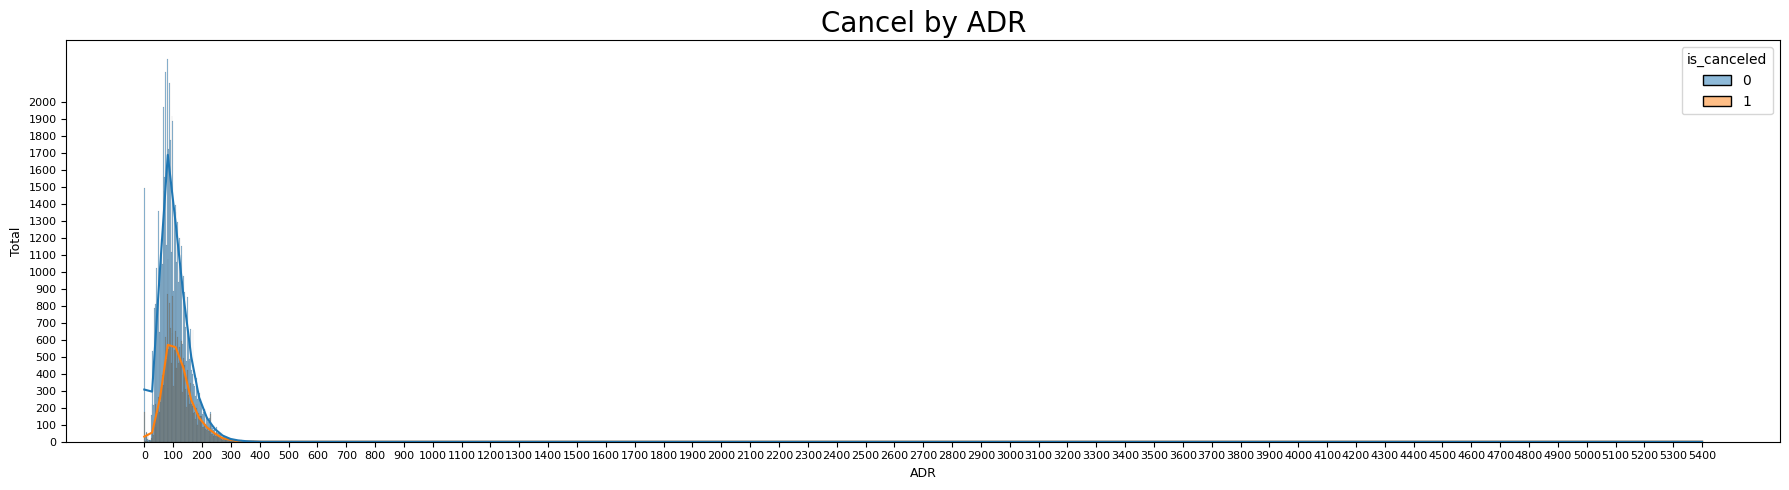

In [65]:
# melihat distribusi adr berdasarkan kelas 0 (tidak cancel) dan 1 (cancel)

plt.figure(figsize=(18,5))
sns.histplot(
    data=df,
    x='adr',
    hue='is_canceled',
    color = ['darkred', 'blue'],
    kde=True,
    # bins=180
)
plt.xlabel('ADR', size=9)
plt.ylabel('Total', size=9)
plt.title('Cancel by ADR', size=20)
plt.xticks(np.arange(0,5500,100))
plt.yticks(np.arange(0,2100,100))
plt.tick_params(axis='both', which='major', labelsize=8)
plt.tight_layout()
plt.show()

keterangan: 0 = tidak cancel, 1 = cancel
- Berdasarkan ADR atau tarif harian rata-rata, cancel paling banyak di rata-rata 100 euro.

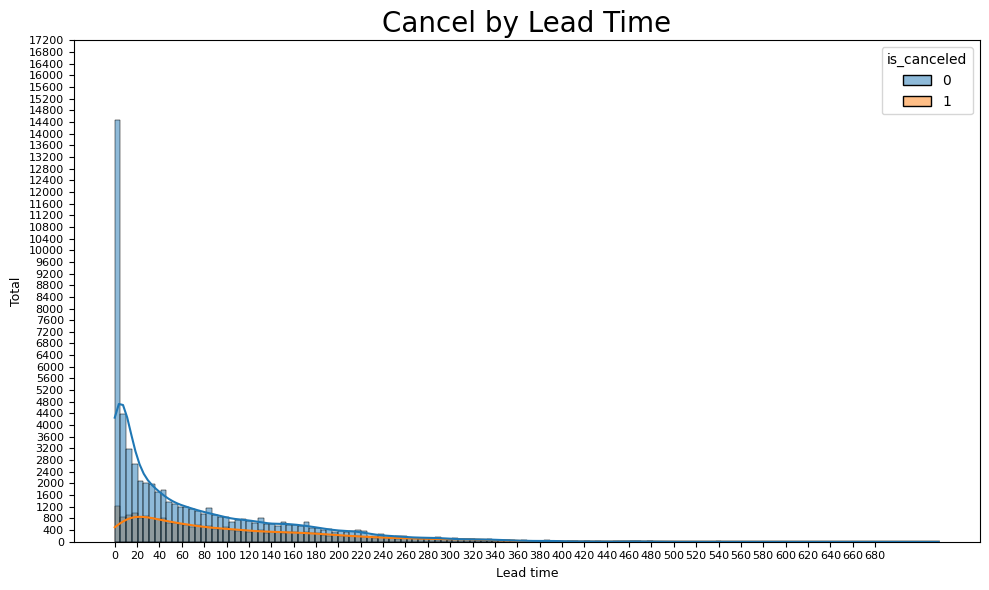

In [66]:
# melihat distribusi lead time berdasarkan kelas 0 (tidak cancel) dan 1 (cancel)

plt.figure(figsize=(10,6))
sns.histplot(
    data=df,
    x='lead_time',
    hue='is_canceled',
    kde=True,
    # bins=80
)
plt.xlabel('Lead time', size=9)
plt.ylabel('Total', size=9)
plt.title('Cancel by Lead Time', size=20)
plt.xticks(np.arange(0,700,20))
plt.yticks(np.arange(0,17500,400))
plt.tick_params(axis='both', which='major', labelsize=8)
plt.tight_layout()
plt.show()

keterangan: 0 = tidak cancel 1 = cancel
- Berdasarkan Selisih hari pada saat pemesanan hingga tanggal kedatangan, paling banyak cancel adalah di selisih hari tunggu 0-5 hari

In [67]:
# kategorikal feature
dfcat = ['hotel', 'arrival_date_month', 'meal', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type',
 'deposit_type', 'customer_type', 'continent']

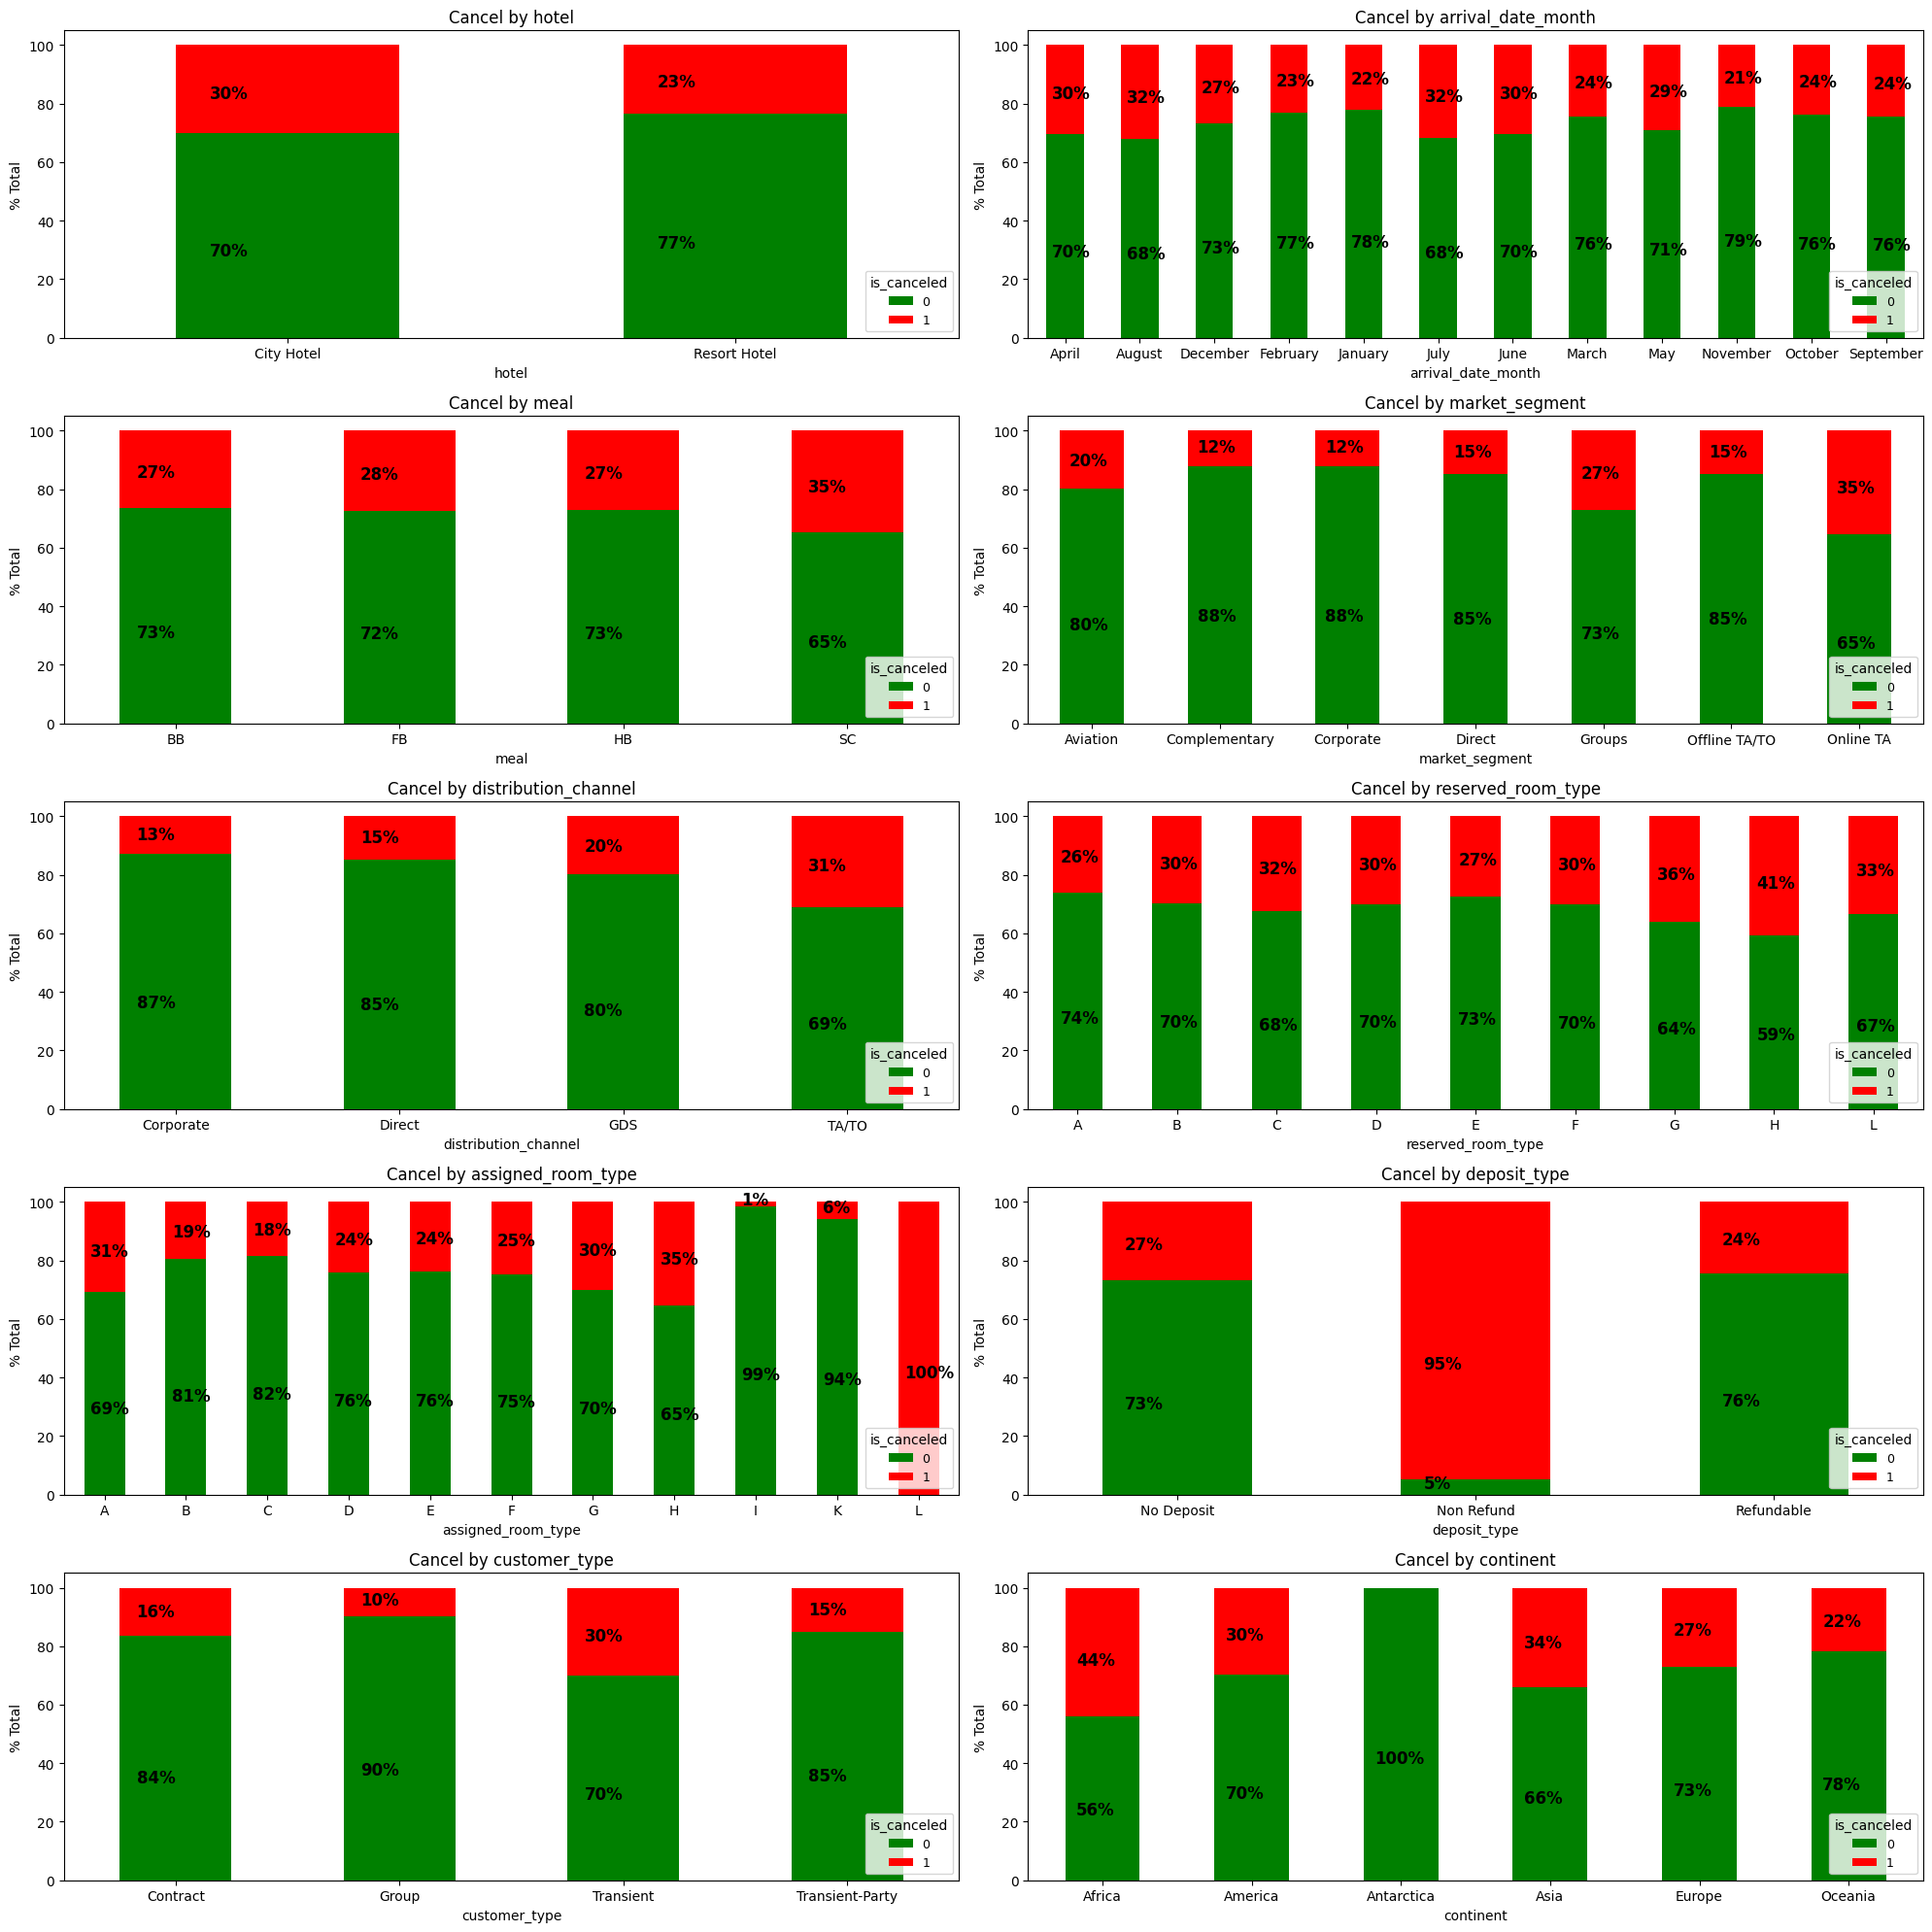

In [68]:
# melihat distribusi kategorikal feature berdasarkan cancel
plt.figure(figsize=(20, 20), facecolor='white')
plotnumber = 1

for feature in dfcat:

        column1 = feature

        # membuat table berdasarkan 2 kolom kategorikal
        groupby_table = df.groupby([column1,'is_canceled']).size().unstack()

        # fungsi untuk pelabelan dimana jika nilainya 0 tidak akan ditampilkan
        def show() :
            if height > 0 :
                return '{:.0f}%'.format(height)
            else :
                return '' 
        
        # subplot (letak grafik)
        ax = plt.subplot(5,2 , plotnumber)
        
        # cancel berdasarkan feature 
        (groupby_table.T*100.0 / groupby_table.T.sum()).T.plot(kind='bar',
                                                                width = 0.5,
                                                                stacked = True,
                                                                rot = 0, 
                                                                ax = ax,
                                                                color = ['green', 'red'])

        ax.legend(loc = 'lower right', prop={'size':9},title = 'is_canceled')
        ax.set_ylabel('% Total')
        ax.set_title(f'Cancel by {column1}',size = 12)
        ax.tick_params(axis='both', which='major', labelsize=10)

        # menambahkan label data pada stacked bar chart
        for p in ax.patches:
            width, height = p.get_width(), p.get_height()
            x, y = p.get_xy() 
            ax.annotate(show(), (p.get_x()+0.15*width, p.get_y()+.4*height),
                        color = 'black',
                        weight = 'bold',
                        size = 12)
        
        plt.tight_layout();
        
        plotnumber += 1
    


keterangan : 1 = cancel, 0 = tidak cancel
- Berdasarkan tipe hotel, customer di city hotel paling banyak melakukan cancel pada pemesanan kamar hotel sebesar 30% dan tidak melakukan cancel sebesar 70%. Sedangkan pada resort hotel, customer lebih sedikit melakukan cancel yaitu sebesar 23% dan tidak melakukan cancel sebesar 77%.
- Berdasarkan bulan kedatangan, customer paling sering melakukan cancel untuk reservasi di bulan July dan Agustus yaitu sebesar 30% dibandingkan bulan-bulan lainnya. Sedangkan customer paling sedikit melakukan cancel untuk reservasi di bulan November yaitu sebesar 21%.
- Berdasarkan tipe meal yang dipesan, customer paling sering melakukan cancel yaitu yang memesan tipe meal SC (tidak ada paket makanan) sebesar 34% dan paling sedikit customer yang melakukan cancel adalah yang memesan tipe meal BB (Tempat Tidur & Sarapan) dan FB (Full board (sarapan, makan siang dan makan malam)) masing-masing sebesar 26%.
- Berdasarkan tipe market segment, customer paling sering melakukan cancel yaitu dari online tour agent sebesar 35% dan paling sedikit customer yang melakukan cancel adalah dari corporate dan complementary masing-masing sebesar 12%.
- Berdasarkan tipe distribution channel, customer paling sering melakukan cancel yaitu dari tour agent/tour operator sebesar 30% dan paling sedikit customer yang melakukan cancel adalah dari corporate yaitu sebesar 13%.
- Berdasarkan tipe kamar yang dipesan, customer paling sering melakukan cancel yaitu yang memesan tipe kamar H sebesar 39% dan paling sedikit customer yang melakukan cancel adalah yang memesan kamar tipe A yaitu sebesar 25%.
- Berdasarkan Kode untuk jenis kamar yang ditetapkan untuk pemesanan, customer paling sering melakukan cancel yaitu yang memesan tipe kamar L sebesar 100% (karena berdasarkan univariate analysis yang memesan tipe L hanya 1 orang). Apabila dilihat di urutan kedua ada tipe H yaitu sebesar 34%; dan paling sedikit customer yang melakukan cancel adalah yang memesan kamar tipe I yaitu sebesar 1%.
- Berdasarkan tipe deposit, customer paling sering melakukan cancel yaitu yang memesan dengan deposit dibuat dalam nilai total biaya menginap (non refund) yaitu sebesar 93%; dan paling sedikit customer yang melakukan cancel adalah yang memesan kamar dengan deposit dibuat dengan nilai di bawah total biaya menginap (refundable) yaitu sebesar 24%.
-  Berdasarkan tipe customer, customer paling sering melakukan cancel yaitu tipe transient yaitu sebesar 29%; dan paling sedikit customer yang melakukan cancel adalah tipe Group yaitu sebesar 24%.
- Berdasarkan benua, customer paling banyak melakukan cancel adalah dari benua africa yaitu sebesar 44% dan paling sedikit dari benua antartica (jumlah reservasi 2) dengan persentase sebesar 0% dan dari oceania dengan persentase sebesar 22%.

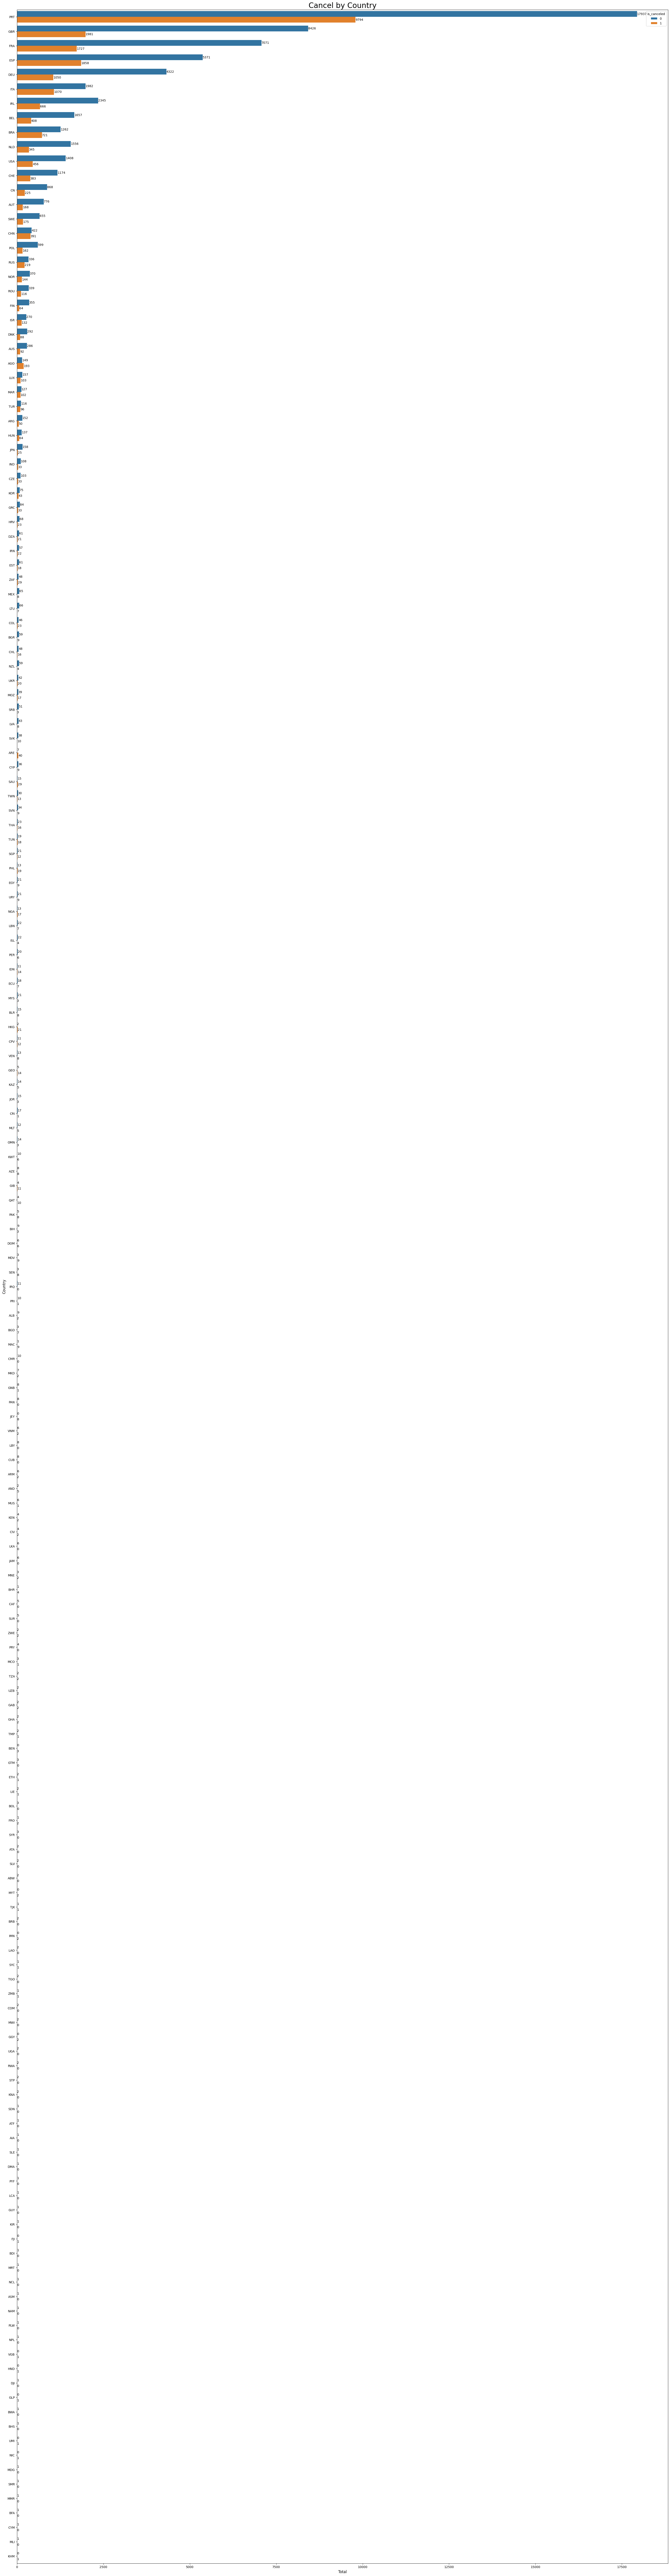

In [69]:
# melihat distribusi dari country by cancel
plt.figure(figsize=(38,150))
ax=sns.countplot(
    data=df,
    y='country',
    hue= 'is_canceled',
    order=df['country'].value_counts().index
)

ax.set_xlabel('Total', size=12)
ax.set_ylabel('Country', size=12)
ax.set_title('Cancel by Country', size=24)
for container in ax.containers:
    ax.bar_label(container)

plt.show()

Berdasarkan country, customer dari portugal merupakan customer yang paling banyak melakukan cancel pada pemesanan kamar hotel.

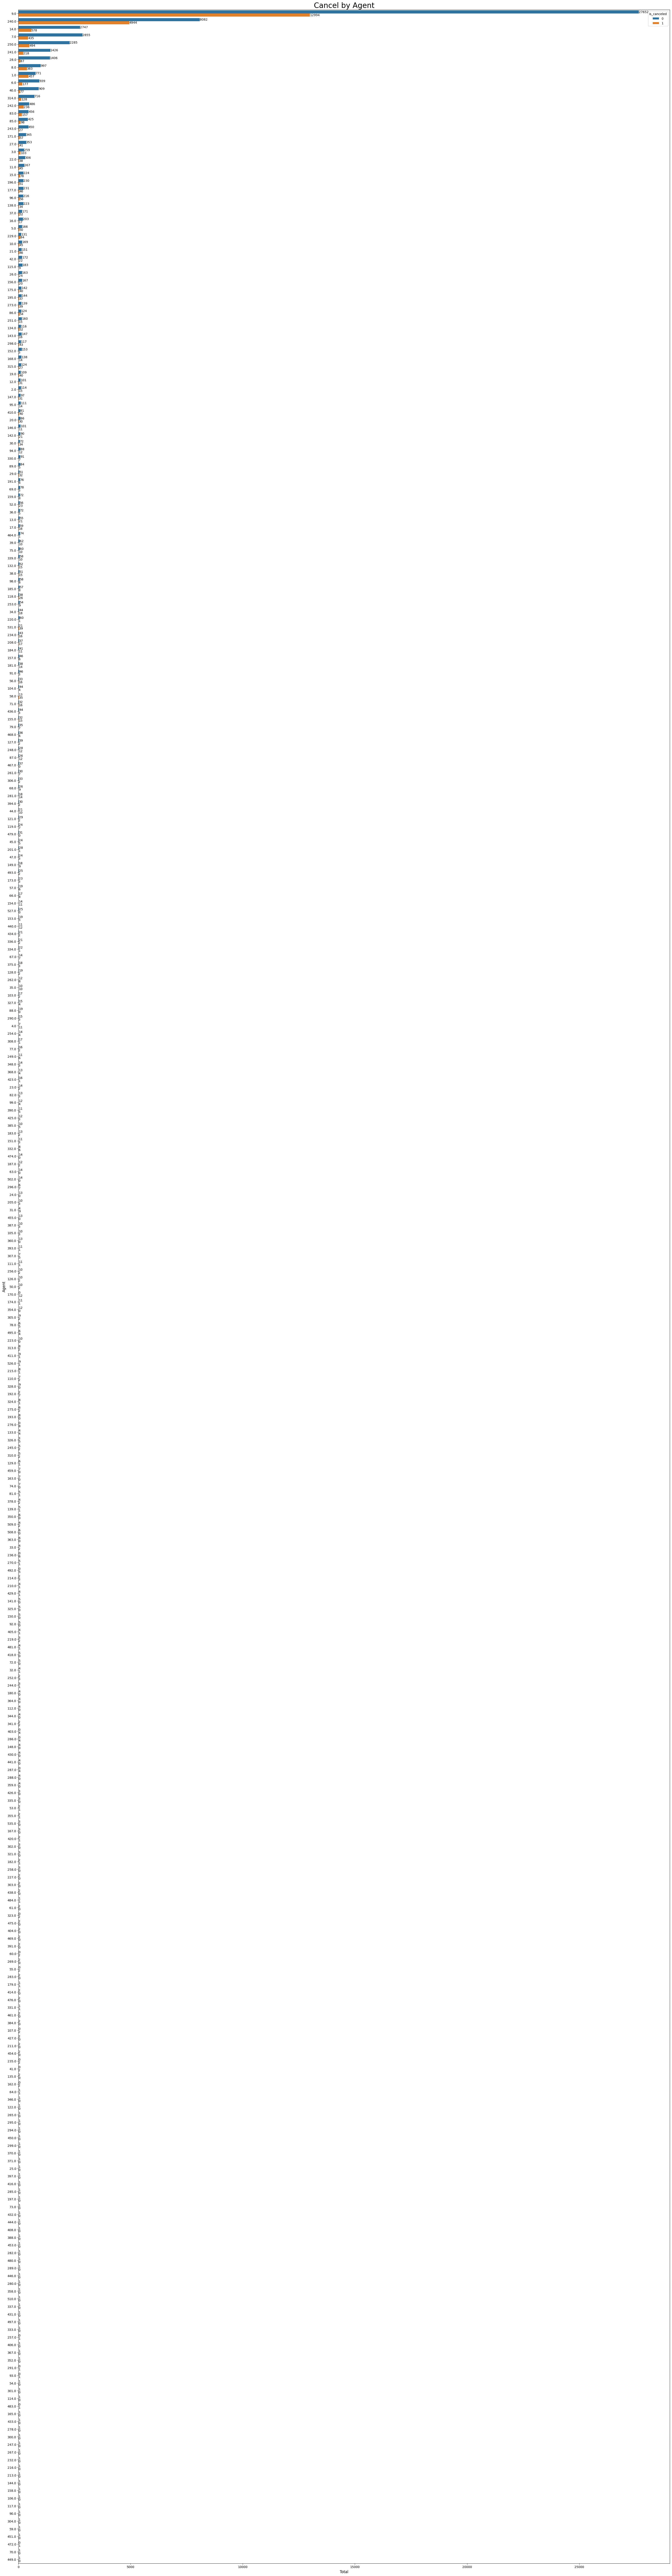

In [70]:
# melihat distribusi dari agent by cancel

plt.figure(figsize=(38,150))
ax=sns.countplot(
    data=df,
    y='agent',
    hue= 'is_canceled',
    order=df['agent'].value_counts().index
)

ax.set_xlabel('Total', size=12)
ax.set_ylabel('Agent', size=12)
ax.set_title('Cancel by Agent', size=24)
for container in ax.containers:
    ax.bar_label(container)

plt.show()

Berdasarkan agent, kode ID perjalanan 9 adalah yang paling banyak melakukan cancel pada pemesanan kamar hotel.

# Business Question

Untuk membantu staff management hotel dalam menentukan perencanaan anggaran yang lebih terkontrol untuk departemen personalia, departemen housekeeping dan departemen F&B. Maka saya akan membuat pertanyaan serta mencoba menjawab pertanyaan-pertanyaan berikut:
1. Berapa total penjualan kamar berdasarkan bulan di tahun 2015-2017?
2. Berapa banyak total tamu yang menginap berdasarkan bulan di tahun 2015-2017?
3. Berapa total penjualan tipe meal berdasarkan bulan di tahun 2015-2017?

# **1. Berapa total penjualan kamar berdasarkan bulan di tahun 2015-2017?**

In [71]:
# mengelompokkan hanya untuk yang reservation statusnya check out (artinya customer sudah membeli kamar)
df1=df[df['reservation_status'].isin(['Check-Out'])]
df1

hotel  is_canceled  lead_time  arrival_date_year  \
0      Resort Hotel            0        342               2015   
1      Resort Hotel            0        737               2015   
2      Resort Hotel            0          7               2015   
3      Resort Hotel            0         13               2015   
4      Resort Hotel            0         14               2015   
...             ...          ...        ...                ...   
86973    City Hotel            0         23               2017   
86974    City Hotel            0        102               2017   
86975    City Hotel            0         34               2017   
86976    City Hotel            0        109               2017   
86977    City Hotel            0        205               2017   

      arrival_date_month  arrival_date_week_number  arrival_date_day_of_month  \
0                   July                        27                          1   
1                   July                        27                          1   
2                   July                        27                          1   
3                   July                        27                          1   
4                   July                        27                          1   
...                  ...                       ...                        ...   
86973             August                        35                         30   
86974             August                        35                         31   
86975             August                        35                         31   
86976             August                        35                         31   
86977             August                        35                         29   

       stays_in_weekend_nights  stays_in_week_nights  adults  children  \
0                            0                     0       2       0.0   
1                            0                     0       2       0.0   
2                            0                     1       1       0.0   
3                            0                     1       1       0.0   
4                            0                     2       2       0.0   
...                        ...                   ...     ...       ...   
86973                        2                     5       2       0.0   
86974                        2                     5       3       0.0   
86975                        2                     5       2       0.0   
86976                        2                     5       2       0.0   
86977                        2                     7       2       0.0   

       babies meal country market_segment distribution_channel  \
0           0   BB     PRT         Direct               Direct   
1           0   BB     PRT         Direct               Direct   
2           0   BB     GBR         Direct               Direct   
3           0   BB     GBR      Corporate            Corporate   
4           0   BB     GBR      Online TA                TA/TO   
...       ...  ...     ...            ...                  ...   
86973       0   BB     BEL  Offline TA/TO                TA/TO   
86974       0   BB     FRA      Online TA                TA/TO   
86975       0   BB     DEU      Online TA                TA/TO   
86976       0   BB     GBR      Online TA                TA/TO   
86977       0   HB     DEU      Online TA                TA/TO   

       is_repeated_guest  previous_cancellations  \
0                      0                       0   
1                      0                       0   
2                      0                       0   
3                      0                       0   
4                      0                       0   
...                  ...                     ...   
86973                  0                       0   
86974                  0                       0   
86975                  0                       0   
86976                  0                      

In [72]:
# membuat tanggal full
df1['arrival_date_full'] = pd.to_datetime(df1.arrival_date_year.astype(str) + '-' + df1.arrival_date_month.astype(str) + '-' + df1.arrival_date_day_of_month.astype(str))

In [73]:
# membuat bulan dan tahun
df1['arrival_date_mmyy'] = df1.arrival_date_full.dt.to_period('M').astype('object')

In [74]:

df1_arrival_month_year = pd.DataFrame(df1[['arrival_date_month','arrival_date_year']].value_counts().reset_index())
df1_arrival_month_year.columns = ['Month','Year','Count']

# data resort
df1_resort = df1[df1['hotel']=='Resort Hotel']
df1_resort = pd.DataFrame(df1_resort[['arrival_date_month','arrival_date_year']].value_counts().reset_index())
df1_resort.columns = ['Month','Year','Count_Resort']
d = {
    'January':1,'February':2,'March':3,'April':4,'May':5,'June':6,'July':7,'August':8,'September':9,'October':10,'November':11,'December':12
}
df1_resort.Month = df1_resort.Month.map(d)
df1_resort['Date'] = pd.to_datetime(df1_resort[['Year', 'Month']].assign(DAY=1))
df1_resort.drop(['Month','Year'], axis='columns', inplace=True)
df1_resort.sort_values('Date')

# data city
df1_city = df1[df1['hotel']=='City Hotel']
df1_city = pd.DataFrame(df1_city[['arrival_date_month','arrival_date_year']].value_counts().reset_index())
df1_city.columns = ['Month','Year','Count_City']
d = {
    'January':1,'February':2,'March':3,'April':4,'May':5,'June':6,'July':7,'August':8,'September':9,'October':10,'November':11,'December':12
}

df1_city.Month = df1_city.Month.map(d)
df1_city['Date'] = pd.to_datetime(df1_city[['Year', 'Month']].assign(DAY=1))
df1_city.drop(['Month','Year'], axis='columns', inplace=True)

# Merge
df1_final = df1_city.merge(df1_resort, on='Date')

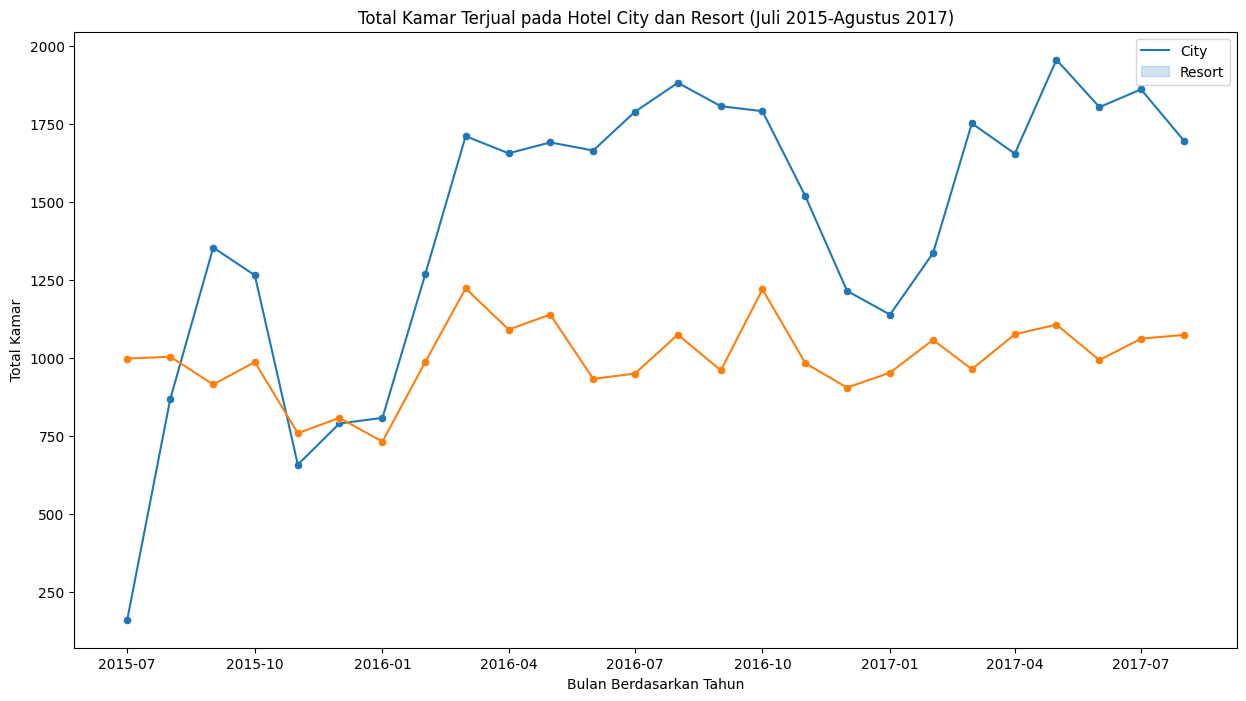

In [75]:
plt.figure(figsize=(15,8))
plt.title('Total Kamar Terjual pada Hotel City dan Resort (Juli 2015-Agustus 2017)')
sns.lineplot( x = df1_final['Date'], y = df1_final['Count_City'])
sns.lineplot( x = df1_final['Date'], y = df1_final['Count_Resort'])

ax1= sns.scatterplot( x = df1_final['Date'], y = df1_final['Count_City'])

ax2= sns.scatterplot( x = df1_final['Date'], y = df1_final['Count_Resort'])

plt.ylabel('Total Kamar')
plt.xlabel('Bulan Berdasarkan Tahun')
plt.legend(['City','Resort'])

# Insight
### Penjualan City hotel:
- pada tahun 2015 antara bulan Juli-Desember, penjualan meningkat di bulan Agustus,September, Oktober dibanding bulan lainnya dan penjualan paling sedikit ada di bulan Juli. 
- Pada tahun 2016 antara bulan januari-desember, penjualan meningkat di bulan Juli, Agustus, September dan penjualan paling sedikit ada di bulan Januari dan Desember. 
- Pada tahun 2017 antara bulan januari-Agustus, penjualan meningkat di bulan Mei dan paling sedikit di bulan januari.
### Penjualan Resort hotel:
- pada tahun 2015 antara bulan Juli-Desember, penjualan meningkat di bulan Juli, Agustus, September, Oktober dibanding bulan lainnya dan penjualan paling sedikit ada di bulan November dan Desember. 
- Pada tahun 2016 antara bulan januari-desember, penjualan meningkat di bulan Oktober dan penjualan paling sedikit ada di bulan Januari. 
- Pada tahun 2017 antara bulan januari-Agustus, penjualan meningkat di bulan Mei dan paling sedikit di bulan januari dan Februari.
### Kesimpulan
Dapat diambil kesimpulan bahwa penjualan kamar di city hotel dan resort hotel paling banyak ada di antara bulan Mei-Oktober.

In [76]:
# copy dari df untuk analisis
df2 = df.copy()
df2

hotel  is_canceled  lead_time  arrival_date_year  \
0      Resort Hotel            0        342               2015   
1      Resort Hotel            0        737               2015   
2      Resort Hotel            0          7               2015   
3      Resort Hotel            0         13               2015   
4      Resort Hotel            0         14               2015   
...             ...          ...        ...                ...   
86973    City Hotel            0         23               2017   
86974    City Hotel            0        102               2017   
86975    City Hotel            0         34               2017   
86976    City Hotel            0        109               2017   
86977    City Hotel            0        205               2017   

      arrival_date_month  arrival_date_week_number  arrival_date_day_of_month  \
0                   July                        27                          1   
1                   July                        27                          1   
2                   July                        27                          1   
3                   July                        27                          1   
4                   July                        27                          1   
...                  ...                       ...                        ...   
86973             August                        35                         30   
86974             August                        35                         31   
86975             August                        35                         31   
86976             August                        35                         31   
86977             August                        35                         29   

       stays_in_weekend_nights  stays_in_week_nights  adults  children  \
0                            0                     0       2       0.0   
1                            0                     0       2       0.0   
2                            0                     1       1       0.0   
3                            0                     1       1       0.0   
4                            0                     2       2       0.0   
...                        ...                   ...     ...       ...   
86973                        2                     5       2       0.0   
86974                        2                     5       3       0.0   
86975                        2                     5       2       0.0   
86976                        2                     5       2       0.0   
86977                        2                     7       2       0.0   

       babies meal country market_segment distribution_channel  \
0           0   BB     PRT         Direct               Direct   
1           0   BB     PRT         Direct               Direct   
2           0   BB     GBR         Direct               Direct   
3           0   BB     GBR      Corporate            Corporate   
4           0   BB     GBR      Online TA                TA/TO   
...       ...  ...     ...            ...                  ...   
86973       0   BB     BEL  Offline TA/TO                TA/TO   
86974       0   BB     FRA      Online TA                TA/TO   
86975       0   BB     DEU      Online TA                TA/TO   
86976       0   BB     GBR      Online TA                TA/TO   
86977       0   HB     DEU      Online TA                TA/TO   

       is_repeated_guest  previous_cancellations  \
0                      0                       0   
1                      0                       0   
2                      0                       0   
3                      0                       0   
4                      0                       0   
...                  ...                     ...   
86973                  0                       0   
86974                  0                       0   
86975                  0                       0   
86976                  0                      

In [77]:
# membuat tanggal full
df2['arrival_date_full'] = pd.to_datetime(df2.arrival_date_year.astype(str) + '-' + df2.arrival_date_month.astype(str) + '-' + df2.arrival_date_day_of_month.astype(str))


In [78]:
# membuat bulan dan tahun
df2['arrival_date_mmyy'] = df2.arrival_date_full.dt.to_period('M').astype('object')


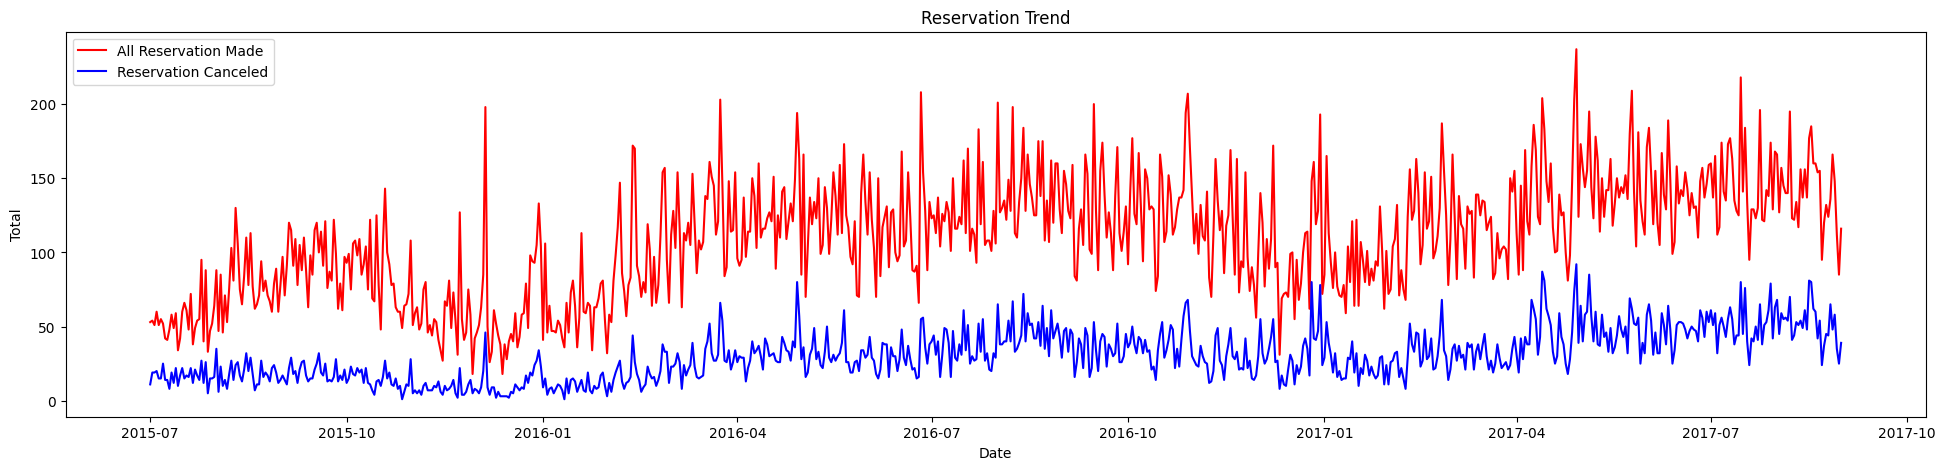

In [79]:
# trend total reservasi cancel dan tidak cancel berdasarkan hari
plt.figure(figsize=(24,5))

num_reservation_all = df2.groupby(['arrival_date_full']).count().reset_index()
sns.lineplot(data=num_reservation_all,x="arrival_date_full",y="hotel",color='red',label='All Reservation Made')

num_reservation_canceled = df2.groupby(['arrival_date_full']).sum()['is_canceled'].reset_index()
sns.lineplot(data=num_reservation_canceled,x="arrival_date_full",y="is_canceled",color='blue',label='Reservation Canceled')

plt.title('Reservation Trend')
plt.xlabel('Date')
plt.ylabel('Total')
plt.show()

# Insight
Berdasarkan trend harian reservasi yang tidak cancel dan yang di cancel, dapat terlihat bahwa pada pola antara yang cancel dan tidak cancel memiliki pola yang hampir mirip. Apabila pada hari yang sama, yang tidak cancel meningkat maka yang cancel juga  meningkat. Namun tetap dari hari ke hari, jumlah yang cancel lebih sedikit dibandingkan yang tidak cancel.

# Rekomendasi
[Musim di Eropa](https://kumparan.com/jendela-dunia/urutan-musim-di-eropa-dan-waktunya-1ywC1PUWWbe/4)
1. Untuk City hotel maupun Resort hotel, Paling banyak kamar terjual yaitu antara bulan Mei-Oktober. Di Eropa pada bulan Mei-Juli adalah musim panas dan bulan Agustus-Oktober adalah musim gugur. Pada kedua musim itu adalah waktu dengan suhu yang cocok untuk keluar rumah dan pergi berlibur menginap di hotel dibandingkan dengan musim dingin dan musim semi yang suhunya kurang mendukung. Musim semi sendiri suhunya masih terlalu dingin yaitu antara 6-13°C. Staff management hotel dapat menentukan perencanaan anggaran untuk departemen personalia dalam merekrut karyawan magang untuk bagian housekeeping dan front office di bulan Mei-Oktober selama 6 bulan. Budget pengeluaran dalam bentuk gaji untuk karyawan magang sendiri lebih sedikit dibandingkan merekrut karyawan tetap. Sehingga hal tersebut bisa meningkatkan pendapatan hotel.
2. Paling banyak kamar terjual yaitu di bulan Mei-Oktober, Staff management hotel dapat berkoordinasi dengan staff departemen housekeeping untuk pengecekan alat dan bahan untuk kebersihan kamar hotel maupun area hotel. Apabila ada alat yang rusak, staff management hotel dapat menetapkan pembuatan anggaran operasional dan pengadaan barang hotel untuk departemen housekeeping pada bulan-bulan ramai pengunjung tersebut. Namun apabila tidak ada, penetapan pembuatan anggaran operasional dan pengadaan barang hotel untuk departemen housekeeping dapat diturunkan. Namun untuk bahan-bahan pembersih tentu saja staff management hotel harus menentukan budget lebih banyak untuk departemen housekeeping di bulan Mei-Oktober. Staff management hotel dapat mengontrol pembelian yang mana pelaksanaannya dilakukan oleh purchasing staff sehingga akan terhindar dari pengeluaran yang berlebihan, dengan kontrol yang baik akan terjadinya keseimbangan antara pembelian dengan pemasukan sehingga target pendapatan tercapai. 
#### Jenis-jenis alat-alat pembersih yang sering digunakan antara lain:
- sapu (broom/ sweeper)
- mop (pel)
- sikat (brush) yang terbagi atas berbagai macam keperluan
- penampung debu (dust pan)
- tempat sampah (bucket/ dust bin)
- penjebak debu (lobby duster)
- semproten (gun sprayer)
- pembesih kaca (glass cleaner)
- tanda bahaya (danger notice)
- floor squeeze adalah alat untuk membersihkan genangan air
- vacumm cleaner (alat penyedot debu)
- floor machine (alat untuk menyikat lantai)
- carpet machine (alat untuk membersihkan karoet)
- blower (alat untuk mengerinkan karpet), atc
#### Jenis bahan-bahan pembersih yang digunakan:
- glass cleaner, gunanya untuk membersihkan kaca
- MPC (multi perpose cleaner), gunanya untuk membersihkan seluruh bagian furniture, kaca, metal,dll
- Wooden polish, gunanya untuk mengkilapkan semua yang berbahan dari kayu
- Metal polish, gunanya untuk mengkilapkan semua yang berbahan dari metal
- Sabun cair, gunanya untuk membersihkan alat-alat dari kaca, porselin, dan plastic
- Go gatter, untuk membersikan toilet
- Forward, untuk bahan pembersih dan desinffektan lantai
- Wax strip, untuk membersihkan dan mengangkat kotoran, atau pelapis lantai
- Complete, untuk sealer atau memberikan ketahanan maksimum dari goresan sepatu dan debu
- Spot and satian remover, untuk membersihkan noda-noda pada karpet.

# **2. Berapa banyak total tamu yang menginap berdasarkan bulan di tahun 2015-2017?**

In [80]:
df1['Total_guest'] = df1['adults'] + df1['children'] 
df1

hotel  is_canceled  lead_time  arrival_date_year  \
0      Resort Hotel            0        342               2015   
1      Resort Hotel            0        737               2015   
2      Resort Hotel            0          7               2015   
3      Resort Hotel            0         13               2015   
4      Resort Hotel            0         14               2015   
...             ...          ...        ...                ...   
86973    City Hotel            0         23               2017   
86974    City Hotel            0        102               2017   
86975    City Hotel            0         34               2017   
86976    City Hotel            0        109               2017   
86977    City Hotel            0        205               2017   

      arrival_date_month  arrival_date_week_number  arrival_date_day_of_month  \
0                   July                        27                          1   
1                   July                        27                          1   
2                   July                        27                          1   
3                   July                        27                          1   
4                   July                        27                          1   
...                  ...                       ...                        ...   
86973             August                        35                         30   
86974             August                        35                         31   
86975             August                        35                         31   
86976             August                        35                         31   
86977             August                        35                         29   

       stays_in_weekend_nights  stays_in_week_nights  adults  children  \
0                            0                     0       2       0.0   
1                            0                     0       2       0.0   
2                            0                     1       1       0.0   
3                            0                     1       1       0.0   
4                            0                     2       2       0.0   
...                        ...                   ...     ...       ...   
86973                        2                     5       2       0.0   
86974                        2                     5       3       0.0   
86975                        2                     5       2       0.0   
86976                        2                     5       2       0.0   
86977                        2                     7       2       0.0   

       babies meal country market_segment distribution_channel  \
0           0   BB     PRT         Direct               Direct   
1           0   BB     PRT         Direct               Direct   
2           0   BB     GBR         Direct               Direct   
3           0   BB     GBR      Corporate            Corporate   
4           0   BB     GBR      Online TA                TA/TO   
...       ...  ...     ...            ...                  ...   
86973       0   BB     BEL  Offline TA/TO                TA/TO   
86974       0   BB     FRA      Online TA                TA/TO   
86975       0   BB     DEU      Online TA                TA/TO   
86976       0   BB     GBR      Online TA                TA/TO   
86977       0   HB     DEU      Online TA                TA/TO   

       is_repeated_guest  previous_cancellations  \
0                      0                       0   
1                      0                       0   
2                      0                       0   
3                      0                       0   
4                      0                       0   
...                  ...                     ...   
86973                  0                       0   
86974                  0                       0   
86975                  0                       0   
86976                  0                      

In [81]:
dfguest = df1.groupby('arrival_date_mmyy')[['Total_guest']].agg(pd.Series.sum).reset_index()
dfguest

arrival_date_mmyy  Total_guest
0            2015-07       2482.0
1            2015-08       3955.0
2            2015-09       4142.0
3            2015-10       4080.0
4            2015-11       2372.0
5            2015-12       3028.0
6            2016-01       2642.0
7            2016-02       4198.0
8            2016-03       5599.0
9            2016-04       5302.0
10           2016-05       5394.0
11           2016-06       5058.0
12           2016-07       6206.0
13           2016-08       6813.0
14           2016-09       5422.0
15           2016-10       5748.0
16           2016-11       4463.0
17           2016-12       4187.0
18           2017-01       3812.0
19           2017-02       4653.0
20           2017-03       4910.0
21           2017-04       5510.0
22           2017-05       5778.0
23           2017-06       5600.0
24           2017-07       6516.0
25           2017-08       6268.0

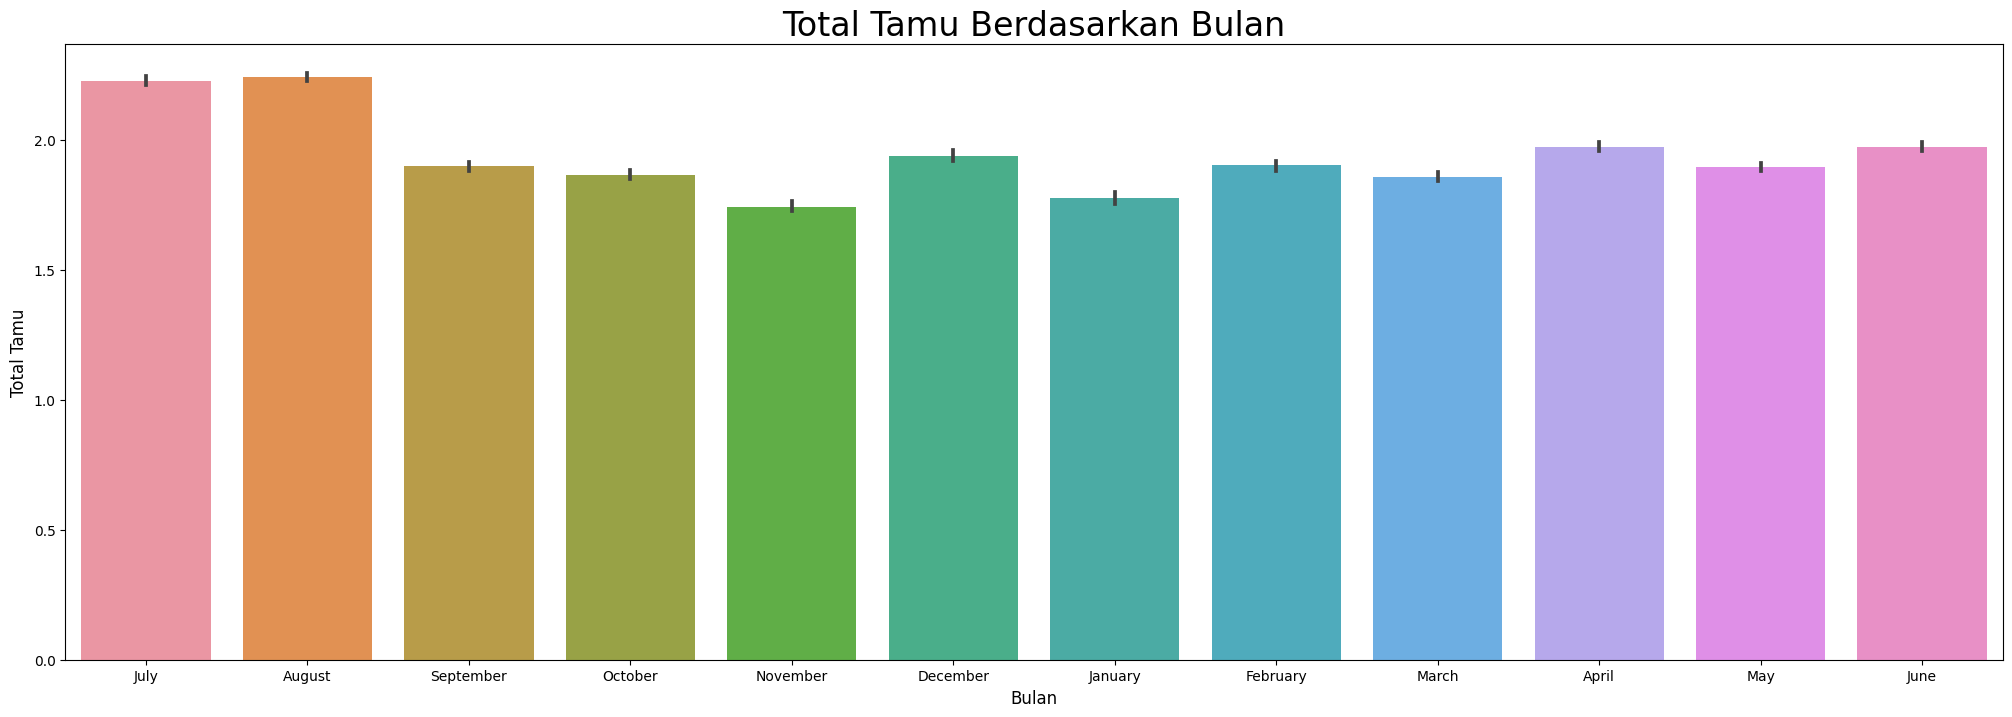

In [82]:
# melihat total tamu berdasarkan bulan 

plt.figure(figsize=(25,8))
ax=sns.barplot(
    data=df1,
    x='arrival_date_month',
    y='Total_guest'
)

ax.set_ylabel('Total Tamu', size=12)
ax.set_xlabel('Bulan', size=12)
ax.set_title('Total Tamu Berdasarkan Bulan', size=24)

# for container in ax.containers:
#     ax.bar_label(container)

plt.show()

# Insight
Total tamu paling banyak ada di bulan Juli-Agustus.

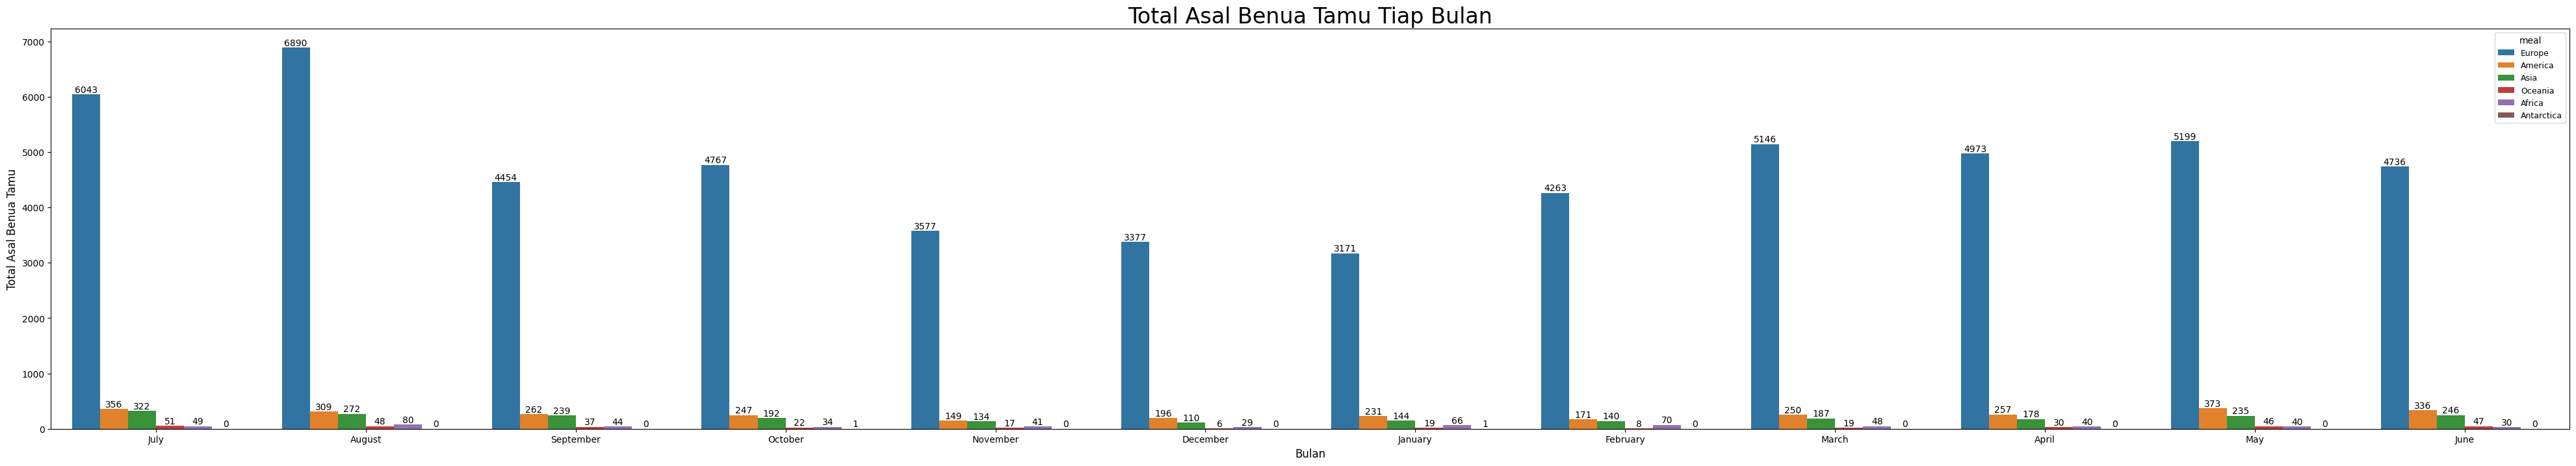

In [83]:
# melihat asal benua customer tiap bulan
plt.figure(figsize=(50,8))
ax=sns.countplot(
    data=df1,
    x='arrival_date_month',
    hue= 'continent'
)

ax.set_xlabel('Bulan', size=12)
ax.set_ylabel('Total Asal Benua Tamu', size=12)
ax.set_title('Total Asal Benua Tamu Tiap Bulan', size=24)
ax.legend(loc = 'upper right', prop={'size':9},title = 'meal')
for container in ax.containers:
    ax.bar_label(container)

plt.show()

# Insight
Tiap bulan, tamu hotel paling banyak berasal dari benua Eropa dan paling banyak ada di bulan Juli-Agustus dan paling sedikit dari benua Oceania

# **3. Berapa total penjualan tipe meal berdasarkan bulan di tahun 2015-2017?**

In [84]:
data = df1.groupby(["arrival_date_mmyy","meal"]).size().reset_index()
data

arrival_date_mmyy meal     0
0             2015-07   BB   840
1             2015-07   FB    28
2             2015-07   HB   284
3             2015-07   SC     7
4             2015-08   BB  1406
..                ...  ...   ...
98            2017-07   SC   426
99            2017-08   BB  1933
100           2017-08   FB    22
101           2017-08   HB   459
102           2017-08   SC   356

[103 rows x 3 columns]

keterangan : 
- SC - tidak ada paket makanan
- BB - Tempat Tidur & Sarapan
- HB - Half board (sarapan dan satu kali makan lainnya - biasanya makan malam)
- FB - Full board (sarapan, makan siang dan makan malam)

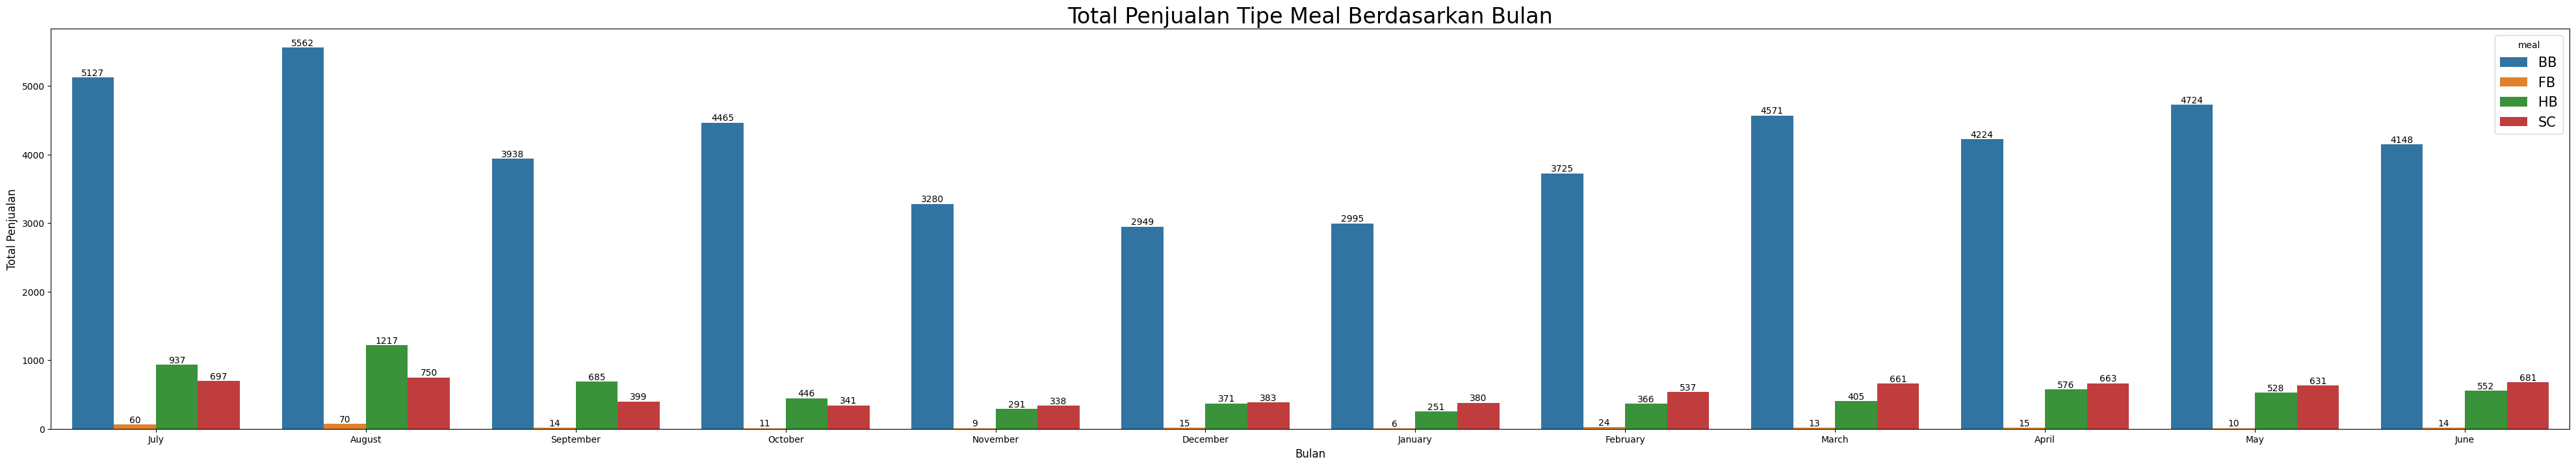

In [85]:
# melihat penjualan tipe meal berdasakan bulan

plt.figure(figsize=(50,8))
ax=sns.countplot(
    data=df1,
    x='arrival_date_month',
    hue= 'meal'
)

ax.set_xlabel('Bulan', size=12)
ax.set_ylabel('Total Penjualan', size=12)
ax.set_title('Total Penjualan Tipe Meal Berdasarkan Bulan', size=24)
ax.legend(loc = 'upper right', prop={'size':15},title = 'meal')
for container in ax.containers:
    ax.bar_label(container)

plt.show()

# Insight
Total penjualan tipe meal paling banyak adalah tipe meal BB (sarapan saja) dengan total paling banyak adalah di bulan Agustus, July

# Rekomendasi
Penjualan tipe meal yang terbanyak dari bulan ke bulan selalu tipe meal BB (sarapan saja). Asal tamu yang menginap paling banyak adalah dari benua Eropa. Informasi mengenai asal tamu hotel dapat membantu departemen F&B service untuk menyiapkan jenis masakan yang dapat disiapkan agar dapat menyesuaikan dengan lidah tamu dan dapat membuat anggaran pembelian bahan baku makanan untuk masakan yang cocok dengan lidah tamu. Maka staff management hotel dapat membuat penentuan anggaran pembelian bahan baku makanan untuk masakan yang cocok dengan lidah orang Eropa karena tamu hotel kebanyakan berasal dari benua Eropa. Serta Budgetnya bisa dikontrol agar tidak berlebihan karena tamu kebanyakan memesan tipe meal BB (sarapan saja). Penentuan budget untuk F&B service bisa ditingkatkan di bulan Juli-Agustus karena lebih ramai pengunjung di bulan-bulan tersebut serta dapat disesuaikan dengan tipe makanan untuk musim panas dan musim gugur.

# Data Correlation

Nilai dari rho juga bisa di interpretasikan bagaimana makna dari nilai tersebut, dengan tabel dibawah ini: 

| rho positif | rho negatif | Kategori |
| --- | --- | --- |
| 0,9 ≤ rho < 1 | -0,9 ≤ rho < -1 | Sangat kuat |
| 0,7 ≤ rho < 0,9 | -0,7 ≤ rho < -0,9 | Kuat |
| 0,5 ≤ rho < 0,7 | -0,5 ≤ rho < -0,7 | Moderat |
| 0,3 ≤ rho < 0,5 | -0,3 ≤ rho < -0,5 | Lemah |
| 0 ≤ rho< 0,3 | -0 ≤ rho < -0,3 | Sangat Lemah |

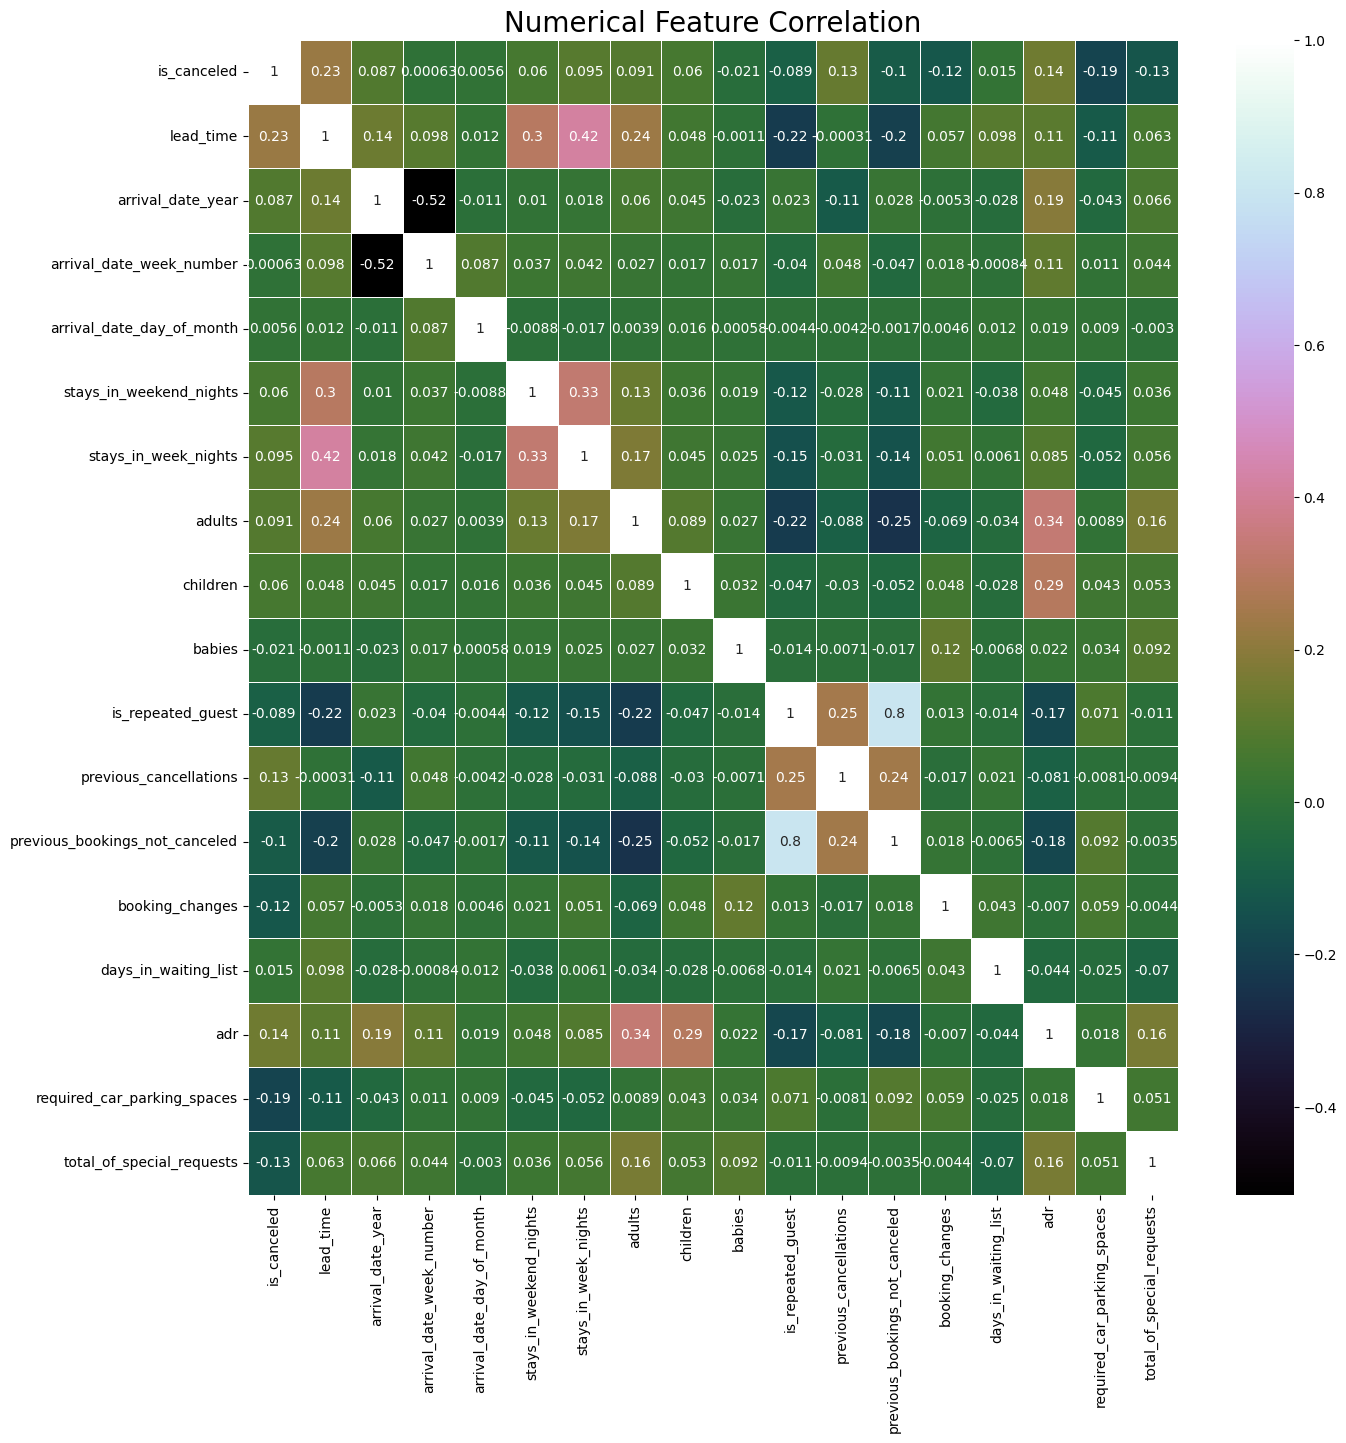

In [86]:
# numerical feature correlation
plt.figure(figsize=(15,15))
sns.heatmap(df.corr('spearman'),annot=True, cmap='cubehelix', linewidths=.5)
plt.title('Numerical Feature Correlation', size=20)
plt.show()

Berdasarkan correlation matrix dapat terlihat bahwa feature 'previous_bookings_not_canceled' memiliki korelasi positif yang kuat dengan feature 'is_repeated_guest'

In [87]:
from sklearn.preprocessing import LabelEncoder

In [88]:
# encode categorical
cat_var = [col for col in df.columns if df[col].dtype == 'O']
cat_var = df[cat_var]
le=LabelEncoder()

for i in cat_var:
    cat_var[i]=le.fit_transform(cat_var[i])
cat_var['is_canceled'] = df['is_canceled']

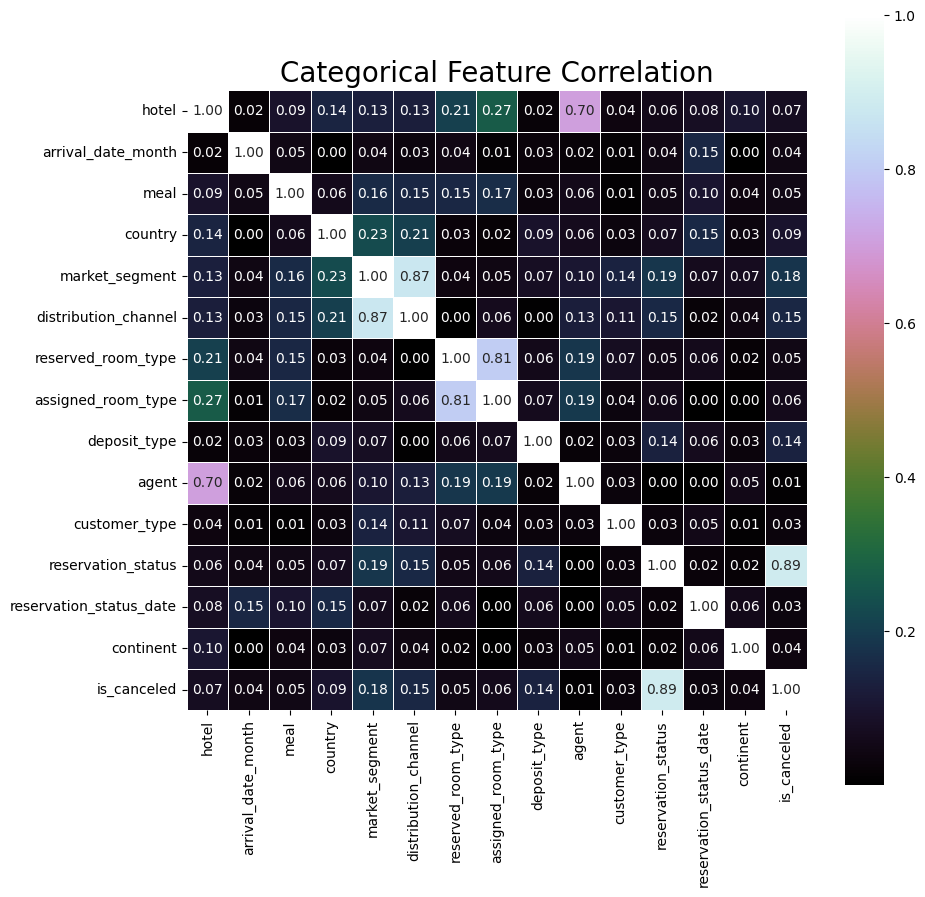

In [89]:
# categorical feature correlation
plt.figure(figsize=(10,10))
palette=sns.diverging_palette(20, 220, n=256)
corr = cat_var.corr().abs()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='cubehelix''', square=True, linewidths=.5)
plt.title('Categorical Feature Correlation', size=20)
plt.show()

Berdasarkan correlation matrix dapat terlihat bahwa :
- feature 'market_segment' memiliki korelasi positif yang kuat dengan feature 'distribution channel'
- 'reserved_room_type' memiliki korelasi kuat dengan 'assigned_room_type'
- 'reservation_status' memiliki nilai korelasi positif sangat kuat terhadap cancel.
- 'agent' memiliki nilai korelasi positif kuat terhadap cancel.

# Outlier Handling

Berdasarkan pengamatan outlier, feature yang memiliki outlier adalah 'lead_time', 'stays_in_weekend_nights' 'stays_in_week_nights', 'adults', 'children', 'babies', 'previous_cancellations', 'days_in_waiting_list', 'adr', 'required_car_parking_spaces'

## Lead time Outlier

In [90]:
# melihat unik value
df['lead_time'].unique()

array([342, 737,   7,  13,  14,   0,   9,  85,  75,  23,  35,  68,  18,
        37,  12,  72, 127,  78,  48,  60,  77,  99, 118,  95,  96,  69,
        45,  40,  15,  36,  43,  70,  16, 107,  47, 113,  90,  50,  93,
        76,   3,   1,  10,   5,  17,  51,  71,  63,  62, 101,   2,  81,
       368, 364, 324,  79,  21, 109, 102,   4,  98,  92,  26,  73, 115,
        86,  52,  29,  30,  33,  32,   8, 100,  44,  80,  97,  64,  39,
        34,  27,  82,  94, 110, 111,  84,  66, 104,  28, 258, 112,  65,
        67,  55,  88,  54, 292,  83, 105, 280, 394,  24, 103, 366, 249,
        22,  91,  11, 108, 106,  31,  87,  41, 304, 117,  59,  53,  58,
       116,  42, 321,  38,  56,  49, 317,   6,  57,  19,  25, 315, 123,
        46,  89,  61, 312, 299, 130,  74, 298, 119,  20, 286, 136, 129,
       124, 327, 131, 460, 140, 114, 139, 122, 137, 126, 120, 128, 135,
       150, 143, 151, 132, 125, 157, 147, 138, 156, 164, 346, 159, 160,
       161, 333, 381, 149, 154, 297, 163, 314, 155, 323, 340, 35

In [91]:
# melihat jumlah value
df['lead_time'].value_counts()

0      5891
1      3193
2      1920
3      1700
4      1564
       ... 
410       1
411       1
371       1
532       1
463       1
Name: lead_time, Length: 479, dtype: int64

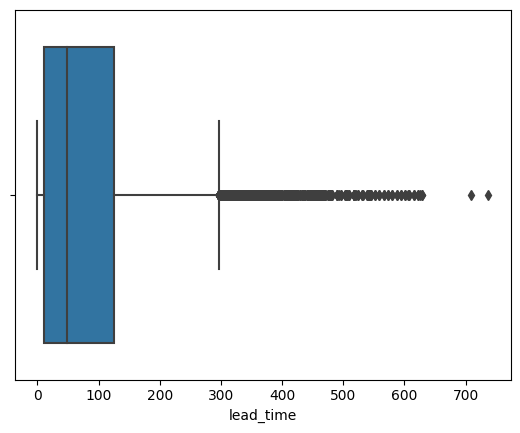

In [92]:
# melihat outlier
sns.boxplot(data=df, x='lead_time');

In [93]:
# outlier lead time
df[df['lead_time']>300]

hotel  is_canceled  lead_time  arrival_date_year  \
0      Resort Hotel            0        342               2015   
1      Resort Hotel            0        737               2015   
78     Resort Hotel            1        368               2015   
79     Resort Hotel            0        364               2015   
82     Resort Hotel            0        324               2015   
...             ...          ...        ...                ...   
86804    City Hotel            0        457               2017   
86846    City Hotel            0        341               2017   
86894    City Hotel            0        303               2017   
86895    City Hotel            0        332               2017   
86930    City Hotel            0        325               2017   

      arrival_date_month  arrival_date_week_number  arrival_date_day_of_month  \
0                   July                        27                          1   
1                   July                        27                          1   
78                  July                        27                          3   
79                  July                        27                          3   
82                  July                        27                          3   
...                  ...                       ...                        ...   
86804             August                        34                         25   
86846             August                        35                         27   
86894             August                        35                         29   
86895             August                        35                         31   
86930             August                        35                         30   

       stays_in_weekend_nights  stays_in_week_nights  adults  children  \
0                            0                     0       2       0.0   
1                            0                     0       2       0.0   
78                           3                     7       2       0.0   
79                           3                     7       2       0.0   
82                           4                    10       2       0.0   
...                        ...                   ...     ...       ...   
86804                        2                     3       2       0.0   
86846                        2                     3       2       1.0   
86894                        0                     4       1       0.0   
86895                        0                     2       2       0.0   
86930                        0                     4       2       0.0   

       babies meal country market_segment distribution_channel  \
0           0   BB     PRT         Direct               Direct   
1           0   BB     PRT         Direct               Direct   
78          0   BB     PRT  Offline TA/TO                TA/TO   
79          0   BB     GBR  Offline TA/TO                TA/TO   
82          0   HB     GBR  Offline TA/TO                TA/TO   
...       ...  ...     ...            ...                  ...   
86804       0   HB     DEU  Offline TA/TO                TA/TO   
86846       0   BB     GBR  Offline TA/TO                TA/TO   
86894       0   BB     JPN      Online TA                TA/TO   
86895       0   BB     GBR      Online TA                TA/TO   
86930       0   BB     GBR      Online TA                TA/TO   

       is_repeated_guest  previous_cancellations  \
0                      0                       0   
1                      0                       0   
78                     0                       0   
79                     0                       0   
82                     0                       0   
...                  ...                     ...   
86804                  0                       0   
86846                  0                       0   
86894                  0                       0   
86895                  0                      

In [94]:
# drop outlier lead_time
df.drop(df[df['lead_time']>300].index,inplace=True)

In [95]:
df['lead_time'].value_counts()

0      5891
1      3193
2      1920
3      1700
4      1564
       ... 
279      30
298      29
284      29
293      23
299      14
Name: lead_time, Length: 301, dtype: int64

## 'stays_in_weekend_nights' dan 'stays_in_week_nights' Outlier

In [96]:
# melihat unik value stays_in_weekend_nights
df['stays_in_weekend_nights'].unique()

array([ 0,  1,  2,  4,  3,  6, 13,  8,  5,  7, 12,  9, 18, 19, 10, 16, 14],
      dtype=int64)

In [97]:
# melihat unik value stays_in_week_nights
df['stays_in_week_nights'].unique()

array([ 1,  2,  3,  4,  5, 10, 11,  8,  6,  7, 15,  0,  9, 12, 33, 20, 14,
       16, 21, 13, 30, 19, 24, 22, 42, 50, 25, 17, 32, 40, 26, 18, 34],
      dtype=int64)

In [98]:
# Membuat kolom baru jika 'weekend' = 1 dan 'bukan weekend' = 0
df['in_weekend'] = df['stays_in_weekend_nights'].apply(lambda x: 1 if x > 0 else 0)
df['in_weekend'].value_counts()

1    50556
0    34149
Name: in_weekend, dtype: int64

In [99]:
# membuat kolom baru 'total_stays'
df['total_stays'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']
df.head()

hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
2  Resort Hotel            0          7               2015               July   
3  Resort Hotel            0         13               2015               July   
4  Resort Hotel            0         14               2015               July   
5  Resort Hotel            0          0               2015               July   
6  Resort Hotel            0          9               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
2                        27                          1   
3                        27                          1   
4                        27                          1   
5                        27                          1   
6                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  children  babies  \
2                        0                     1       1       0.0       0   
3                        0                     1       1       0.0       0   
4                        0                     2       2       0.0       0   
5                        0                     2       2       0.0       0   
6                        0                     2       2       0.0       0   

  meal country market_segment distribution_channel  is_repeated_guest  \
2   BB     GBR         Direct               Direct                  0   
3   BB     GBR      Corporate            Corporate                  0   
4   BB     GBR      Online TA                TA/TO                  0   
5   BB     PRT         Direct               Direct                  0   
6   FB     PRT         Direct               Direct                  0   

   previous_cancellations  previous_bookings_not_canceled reserved_room_type  \
2                       0                               0                  A   
3                       0                               0                  A   
4                       0                               0                  A   
5                       0                               0                  C   
6                       0                               0                  C   

  assigned_room_type  booking_changes deposit_type  agent  \
2                  C                0   No Deposit    9.0   
3                  A                0   No Deposit  304.0   
4                  A                0   No Deposit  240.0   
5                  C                0   No Deposit    9.0   
6                  C                0   No Deposit  303.0   

   days_in_waiting_list customer_type    adr  required_car_parking_spaces  \
2                     0     Transient   75.0                            0   
3                     0     Transient   75.0                            0   
4                     0     Transient   98.0                            0   
5                     0     Transient  107.0                            0   
6                     0     Transient  103.0                            0   

   total_of_special_requests reservation_status reservation_status_date  \
2                          0          Check-Out              2015-07-02   
3                          0          Check-Out              2015-07-02   
4                          1          Check-Out              2015-07-03   
5                          0          Check-Out              2015-07-03   
6                          1          Check-Out              2015-07-03   

  continent  in_weekend  total_stays  
2    Europe           0            1  
3    Europe           0            1  
4    Europe           0            2  
5    Europe           0            2  
6    Europe           0            2

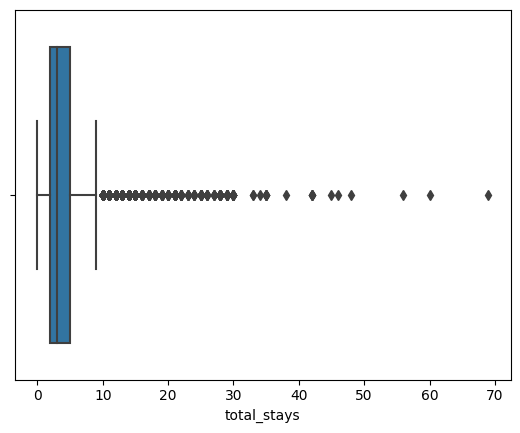

In [100]:
# melihat apakah ada outliernya
sns.boxplot(data=df, x='total_stays');

In [101]:
# melihat unik value
df['total_stays'].unique()

array([ 1,  2,  3,  4,  5,  6,  7, 14, 15, 10, 11,  8,  9, 21,  0, 13, 12,
       18, 46, 28, 17, 19, 22, 23, 16, 29, 42, 20, 26, 33, 30, 25, 27, 60,
       69, 35, 45, 56, 38, 24, 48, 34], dtype=int64)

In [102]:
# melihat jumlah masing-masing value
df['total_stays'].value_counts()

3     17324
1     16962
2     15326
4     13212
7      7109
5      6546
6      3149
8      1031
10      973
9       744
14      743
0       585
11      339
12      182
13      128
15       69
21       52
16       32
28       32
18       22
19       21
17       18
20       14
25       14
30       13
29       13
22       12
26        6
24        6
23        5
35        5
42        4
27        4
33        2
46        1
38        1
48        1
60        1
56        1
45        1
69        1
34        1
Name: total_stays, dtype: int64

In [103]:
# drop outlier total stays
df.drop(df[df['total_stays']>30].index,inplace=True)

## 'adults' Outlier

In [104]:
# melihat unik value
df['adults'].unique()

array([1, 2, 3, 4], dtype=int64)

In [105]:
# melihat jumlah masing-masing value
df['adults'].value_counts()

2    62681
1    16112
3     5835
4       58
Name: adults, dtype: int64

## 'children' Outlier

Berdasarkan [sumber](https://www.nih.gov/nih-style-guide/age#:~:text=Neonates%20or%20newborns%20(birth%20to,13%20years%20through%2017%20years)), children memiliki umur 1-12 tahun

In [106]:
# melihat unik value
df['children'].unique()

array([ 0.,  1.,  2., 10.,  3.])

In [107]:
# melihat jumlah masing-masing value
df['children'].value_counts()

0.0     76732
1.0      4578
2.0      3311
3.0        64
10.0        1
Name: children, dtype: int64

In [108]:
# drop outlier kolom children
df.drop(df[df['children'] > 3 ].index,axis=0, inplace=True)
df['children'].value_counts()

0.0    76732
1.0     4578
2.0     3311
3.0       64
Name: children, dtype: int64

## 'babies' outlier

Berdasarkan [sumber](https://www.nih.gov/nih-style-guide/age#:~:text=Neonates%20or%20newborns%20(birth%20to,13%20years%20through%2017%20years)), babies memiliki umur 1 bulan - 1 tahun

In [109]:
# melihat unik value
df['babies'].unique()

array([ 0,  1,  2, 10,  9], dtype=int64)

In [110]:
# melihat jumlah masing-masing value
df['babies'].value_counts()

0     83796
1       873
2        14
10        1
9         1
Name: babies, dtype: int64

In [111]:
# drop outlier kolom babies
df.drop(df[df['babies'] > 2 ].index,axis=0, inplace=True)
df['babies'].value_counts()

0    83796
1      873
2       14
Name: babies, dtype: int64

## 'previous_cancellations' outlier

In [112]:
# melihat unik value
df['previous_cancellations'].unique()

array([ 0,  1,  2,  3, 26, 25, 14,  4, 24, 19,  5, 21,  6, 13, 11],
      dtype=int64)

In [113]:
# melihat jumlah masing-masing value
df['previous_cancellations'].value_counts()

0     83114
1      1297
2       106
3        61
4        30
11       27
5        19
6        17
13        4
25        2
24        2
26        1
14        1
19        1
21        1
Name: previous_cancellations, dtype: int64

In [114]:
# drop outlier kolom previous_cancellations
df.drop(df[df['previous_cancellations'] > 6 ].index,axis=0, inplace=True)
df['previous_cancellations'].value_counts()

0    83114
1     1297
2      106
3       61
4       30
5       19
6       17
Name: previous_cancellations, dtype: int64

## days_in_waiting_list outlier

In [115]:
# melihat unik value
df['days_in_waiting_list'].unique()

array([  0,  50,  47,  65, 122,  14,  60,  34, 100,  22, 121,  61,   1,
         8, 107,  43,  52,   2,  11, 142, 116,  13,  44,  97,  83,   4,
       113,  18,  20, 185,  93, 109,   6,  37, 105, 154,   5,  99,  38,
        48,  33,  77,  21,  80,  59,  40,  58,  89,  53,  49,  69,  87,
        91,  57, 111,  79,  98,  85,  63,  15,   3, 101,  41, 224,  31,
        39,  56, 187, 176,  71,  55,  96, 236, 259, 207, 160,  75,  30,
        32,  27,  62,  24, 108, 147,  35, 178, 174, 193,  10,  76,  16,
        28,   9, 165,  17,  25,  46,   7,  84, 175, 183,  23, 117,  12,
        54,  26,  73,  45,  42,  72,  81,  74, 167, 223], dtype=int64)

In [116]:
# melihat jumlah masing-masing value
df['days_in_waiting_list'].value_counts()

0      83897
63        53
87        25
44        23
15        22
       ...  
109        1
116        1
142        1
52         1
223        1
Name: days_in_waiting_list, Length: 114, dtype: int64

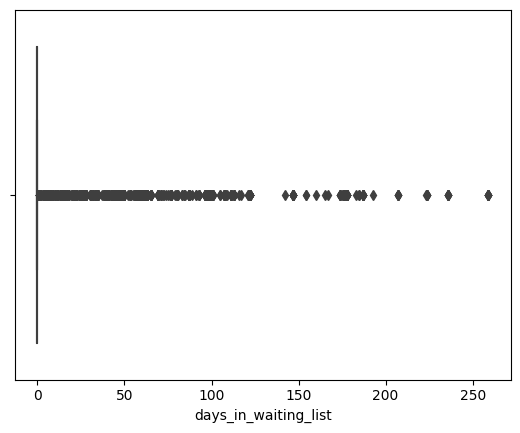

In [117]:
sns.boxplot(data=df, x='days_in_waiting_list');

In [118]:
df[df['days_in_waiting_list'] > 121]

hotel  is_canceled  lead_time  arrival_date_year  \
3072   Resort Hotel            0        165               2015   
3073   Resort Hotel            0        165               2015   
3074   Resort Hotel            0        165               2015   
3076   Resort Hotel            0        165               2015   
3077   Resort Hotel            1        165               2015   
...             ...          ...        ...                ...   
69818    City Hotel            0        281               2016   
69819    City Hotel            0        281               2016   
69820    City Hotel            0        281               2016   
73837    City Hotel            0        208               2016   
77437    City Hotel            0        244               2017   

      arrival_date_month  arrival_date_week_number  arrival_date_day_of_month  \
3072            December                        53                         30   
3073            December                        53                         30   
3074            December                        53                         30   
3076            December                        53                         30   
3077            December                        53                         30   
...                  ...                       ...                        ...   
69818            October                        40                          1   
69819            October                        40                          1   
69820            October                        40                          1   
73837           December                        53                         27   
77437              March                        11                         16   

       stays_in_weekend_nights  stays_in_week_nights  adults  children  \
3072                         0                     4       2       0.0   
3073                         0                     4       2       0.0   
3074                         0                     4       2       0.0   
3076                         0                     4       1       0.0   
3077                         0                     4       1       0.0   
...                        ...                   ...     ...       ...   
69818                        2                     1       2       1.0   
69819                        2                     1       2       0.0   
69820                        2                     1       2       1.0   
73837                        0                     1       2       0.0   
77437                        1                     3       2       0.0   

       babies meal country market_segment distribution_channel  \
3072        0   SC     PRT         Groups                TA/TO   
3073        0   SC     PRT         Groups                TA/TO   
3074        0   SC     PRT         Groups                TA/TO   
3076        0   HB     PRT         Groups                TA/TO   
3077        0   HB     PRT         Groups                TA/TO   
...       ...  ...     ...            ...                  ...   
69818       0   HB     ITA         Groups                TA/TO   
69819       0   HB     ITA         Groups                TA/TO   
69820       0   HB     ITA         Groups                TA/TO   
73837       0   BB     BRA  Offline TA/TO                TA/TO   
77437       0   BB     DEU  Offline TA/TO                TA/TO   

       is_repeated_guest  previous_cancellations  \
3072                   0                       0   
3073                   0                       0   
3074                   0                       0   
3076                   0                       0   
3077                   0                       0   
...                  ...                     ...   
69818                  0                       0   
69819                  0                       0   
69820                  0                       0   
73837                  0                      

In [119]:
# drop outlier kolom days_in_waiting_list
df.drop(df[df['days_in_waiting_list'] > 121 ].index,axis=0, inplace=True)
df['days_in_waiting_list'].value_counts()

0     83897
63       53
87       25
44       23
15       22
      ...  
79        1
85        1
55        1
75        1
74        1
Name: days_in_waiting_list, Length: 94, dtype: int64

In [120]:
df['days_in_waiting_list'].unique()

array([  0,  50,  47,  65,  14,  60,  34, 100,  22, 121,  61,   1,   8,
       107,  43,  52,   2,  11, 116,  13,  44,  97,  83,   4, 113,  18,
        20,  93, 109,   6,  37, 105,   5,  99,  38,  48,  33,  77,  21,
        80,  59,  40,  58,  89,  53,  49,  69,  87,  91,  57, 111,  79,
        98,  85,  63,  15,   3, 101,  41,  31,  39,  56,  71,  55,  96,
        75,  30,  32,  27,  62,  24, 108,  35,  10,  76,  16,  28,   9,
        17,  25,  46,   7,  84,  23, 117,  12,  54,  26,  73,  45,  42,
        72,  81,  74], dtype=int64)

## adr outlier

In [121]:
# melihat unik value
df['adr'].unique()

array([ 75.  ,  98.  , 107.  , ..., 266.75, 209.25, 157.71])

In [122]:
# melihat jumlah masing-masing value
df['adr'].value_counts()

0.00      1582
75.00     1298
65.00     1225
85.00      857
48.00      857
          ... 
52.66        1
37.45        1
141.57       1
107.08       1
157.71       1
Name: adr, Length: 8728, dtype: int64

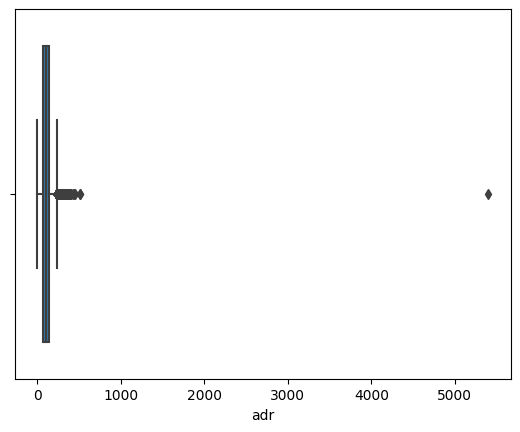

In [123]:
sns.boxplot(data=df, x='adr');

In [124]:
# melihat outlier
df[df['adr'] >5000]

hotel  is_canceled  lead_time  arrival_date_year  \
38664  City Hotel            1         35               2016   

      arrival_date_month  arrival_date_week_number  arrival_date_day_of_month  \
38664              March                        13                         25   

       stays_in_weekend_nights  stays_in_week_nights  adults  children  \
38664                        0                     1       2       0.0   

       babies meal country market_segment distribution_channel  \
38664       0   BB     PRT  Offline TA/TO                TA/TO   

       is_repeated_guest  previous_cancellations  \
38664                  0                       0   

       previous_bookings_not_canceled reserved_room_type assigned_room_type  \
38664                               0                  A                  A   

       booking_changes deposit_type agent  days_in_waiting_list customer_type  \
38664                1   Non Refund  12.0                     0     Transient   

          adr  required_car_parking_spaces  total_of_special_requests  \
38664  5400.0                            0                          0   

      reservation_status reservation_status_date continent  in_weekend  \
38664           Canceled              2016-02-19    Europe           0   

       total_stays  
38664            1

In [125]:
# drop outlier
df.drop(labels = df[df['adr'] > 5000].index, axis = 0, inplace = True)
df[df['adr'] > 5000]

Empty DataFrame
Columns: [hotel, is_canceled, lead_time, arrival_date_year, arrival_date_month, arrival_date_week_number, arrival_date_day_of_month, stays_in_weekend_nights, stays_in_week_nights, adults, children, babies, meal, country, market_segment, distribution_channel, is_repeated_guest, previous_cancellations, previous_bookings_not_canceled, reserved_room_type, assigned_room_type, booking_changes, deposit_type, agent, days_in_waiting_list, customer_type, adr, required_car_parking_spaces, total_of_special_requests, reservation_status, reservation_status_date, continent, in_weekend, total_stays]
Index: []

## required_car_parking_spaces outlier

In [126]:
# melihat unik value
df['required_car_parking_spaces'].unique()

array([0, 1, 2, 8, 3], dtype=int64)

In [127]:
# melihat jumlah masing-masing value
df['required_car_parking_spaces'].value_counts()

0    77329
1     7174
2       27
3        3
8        1
Name: required_car_parking_spaces, dtype: int64

In [128]:
# drop outlier kolom days_in_waiting_list
df.drop(df[df['required_car_parking_spaces'] > 3 ].index,axis=0, inplace=True)
df['required_car_parking_spaces'].value_counts()

0    77329
1     7174
2       27
3        3
Name: required_car_parking_spaces, dtype: int64

In [129]:
df.head()

hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
2  Resort Hotel            0          7               2015               July   
3  Resort Hotel            0         13               2015               July   
4  Resort Hotel            0         14               2015               July   
5  Resort Hotel            0          0               2015               July   
6  Resort Hotel            0          9               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
2                        27                          1   
3                        27                          1   
4                        27                          1   
5                        27                          1   
6                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  children  babies  \
2                        0                     1       1       0.0       0   
3                        0                     1       1       0.0       0   
4                        0                     2       2       0.0       0   
5                        0                     2       2       0.0       0   
6                        0                     2       2       0.0       0   

  meal country market_segment distribution_channel  is_repeated_guest  \
2   BB     GBR         Direct               Direct                  0   
3   BB     GBR      Corporate            Corporate                  0   
4   BB     GBR      Online TA                TA/TO                  0   
5   BB     PRT         Direct               Direct                  0   
6   FB     PRT         Direct               Direct                  0   

   previous_cancellations  previous_bookings_not_canceled reserved_room_type  \
2                       0                               0                  A   
3                       0                               0                  A   
4                       0                               0                  A   
5                       0                               0                  C   
6                       0                               0                  C   

  assigned_room_type  booking_changes deposit_type  agent  \
2                  C                0   No Deposit    9.0   
3                  A                0   No Deposit  304.0   
4                  A                0   No Deposit  240.0   
5                  C                0   No Deposit    9.0   
6                  C                0   No Deposit  303.0   

   days_in_waiting_list customer_type    adr  required_car_parking_spaces  \
2                     0     Transient   75.0                            0   
3                     0     Transient   75.0                            0   
4                     0     Transient   98.0                            0   
5                     0     Transient  107.0                            0   
6                     0     Transient  103.0                            0   

   total_of_special_requests reservation_status reservation_status_date  \
2                          0          Check-Out              2015-07-02   
3                          0          Check-Out              2015-07-02   
4                          1          Check-Out              2015-07-03   
5                          0          Check-Out              2015-07-03   
6                          1          Check-Out              2015-07-03   

  continent  in_weekend  total_stays  
2    Europe           0            1  
3    Europe           0            1  
4    Europe           0            2  
5    Europe           0            2  
6    Europe           0            2

In [130]:
# Menghapus beberapa kolom yang ada pada dataset karena memiliki nilai yang serupa, dan sudah ada kolom baru yang dapat mewakili kolom-kolom tersebut.
df.drop(columns = ['stays_in_weekend_nights', 'stays_in_week_nights'], axis=1, inplace=True)
df.head()

hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
2  Resort Hotel            0          7               2015               July   
3  Resort Hotel            0         13               2015               July   
4  Resort Hotel            0         14               2015               July   
5  Resort Hotel            0          0               2015               July   
6  Resort Hotel            0          9               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  adults  children  \
2                        27                          1       1       0.0   
3                        27                          1       1       0.0   
4                        27                          1       2       0.0   
5                        27                          1       2       0.0   
6                        27                          1       2       0.0   

   babies meal country market_segment distribution_channel  is_repeated_guest  \
2       0   BB     GBR         Direct               Direct                  0   
3       0   BB     GBR      Corporate            Corporate                  0   
4       0   BB     GBR      Online TA                TA/TO                  0   
5       0   BB     PRT         Direct               Direct                  0   
6       0   FB     PRT         Direct               Direct                  0   

   previous_cancellations  previous_bookings_not_canceled reserved_room_type  \
2                       0                               0                  A   
3                       0                               0                  A   
4                       0                               0                  A   
5                       0                               0                  C   
6                       0                               0                  C   

  assigned_room_type  booking_changes deposit_type  agent  \
2                  C                0   No Deposit    9.0   
3                  A                0   No Deposit  304.0   
4                  A                0   No Deposit  240.0   
5                  C                0   No Deposit    9.0   
6                  C                0   No Deposit  303.0   

   days_in_waiting_list customer_type    adr  required_car_parking_spaces  \
2                     0     Transient   75.0                            0   
3                     0     Transient   75.0                            0   
4                     0     Transient   98.0                            0   
5                     0     Transient  107.0                            0   
6                     0     Transient  103.0                            0   

   total_of_special_requests reservation_status reservation_status_date  \
2                          0          Check-Out              2015-07-02   
3                          0          Check-Out              2015-07-02   
4                          1          Check-Out              2015-07-03   
5                          0          Check-Out              2015-07-03   
6                          1          Check-Out              2015-07-03   

  continent  in_weekend  total_stays  
2    Europe           0            1  
3    Europe           0            1  
4    Europe           0            2  
5    Europe           0            2  
6    Europe           0            2

In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84533 entries, 2 to 86977
Data columns (total 32 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           84533 non-null  object 
 1   is_canceled                     84533 non-null  int64  
 2   lead_time                       84533 non-null  int64  
 3   arrival_date_year               84533 non-null  int64  
 4   arrival_date_month              84533 non-null  object 
 5   arrival_date_week_number        84533 non-null  int64  
 6   arrival_date_day_of_month       84533 non-null  int64  
 7   adults                          84533 non-null  int64  
 8   children                        84533 non-null  float64
 9   babies                          84533 non-null  int64  
 10  meal                            84533 non-null  object 
 11  country                         84533 non-null  object 
 12  market_segment                  

Setelah data dibersihkan kemungkinan ada data duplikat kembali. Maka saya akan cek apakah ada data duplikat.

In [132]:
# Cek dan hapus data duplikat
print(f"Data sebelumnya berjumlah {df.shape}, setelah data duplikat di drop menjadi {df.drop_duplicates().shape}")
df = df.drop_duplicates()

Data sebelumnya berjumlah (84533, 32), setelah data duplikat di drop menjadi (84533, 32)


In [133]:
df.describe()

is_canceled     lead_time  arrival_date_year  \
count  84533.000000  84533.000000       84533.000000   
mean       0.270190     72.290951        2016.204169   
std        0.444061     73.457780           0.686783   
min        0.000000      0.000000        2015.000000   
25%        0.000000     11.000000        2016.000000   
50%        0.000000     46.000000        2016.000000   
75%        1.000000    117.000000        2017.000000   
max        1.000000    300.000000        2017.000000   

       arrival_date_week_number  arrival_date_day_of_month        adults  \
count              84533.000000                84533.00000  84533.000000   
mean                  26.748938                   15.82117      1.880118   
std                   13.727511                    8.83902      0.497535   
min                    1.000000                    1.00000      1.000000   
25%                   15.000000                    8.00000      2.000000   
50%                   27.000000                   16.00000      2.000000   
75%                   37.000000                   23.00000      2.000000   
max                   53.000000                   31.00000      4.000000   

           children        babies  is_repeated_guest  previous_cancellations  \
count  84533.000000  84533.000000       84533.000000            84533.000000   
mean       0.134728      0.010659           0.039144                0.023766   
std        0.446607      0.104290           0.193940                0.211722   
min        0.000000      0.000000           0.000000                0.000000   
25%        0.000000      0.000000           0.000000                0.000000   
50%        0.000000      0.000000           0.000000                0.000000   
75%        0.000000      0.000000           0.000000                0.000000   
max        3.000000      2.000000           1.000000                6.000000   

       previous_bookings_not_canceled  booking_changes  days_in_waiting_list  \
count                    84533.000000     84533.000000          84533.000000   
mean                         0.185904         0.262395              0.373889   
std                          1.743370         0.694998              5.024528   
min                          0.000000         0.000000              0.000000   
25%                          0.000000         0.000000              0.000000   
50%                          0.000000         0.000000              0.000000   
75%                          0.000000         0.000000              0.000000   
max                         72.000000        17.000000            121.000000   

                adr  required_car_parking_spaces  total_of_special_requests  \
count  84533.000000                 84533.000000               84533.000000   
mean     106.926615                     0.085612                   0.701052   
std       52.041330                     0.281309                   0.831155   
min        0.000000                     0.000000                   0.000000   
25%       72.380000                     0.000000                   0.000000   
50%       99.000000                     0.000000                   1.000000   
75%      135.000000                     0.000000                   1.000000   
max      510.000000                     3.000000                   5.000000   

         in_weekend   total_stays  
count  84533.000000  84533.000000  
mean       0.597341      3.582352  
std        0.490436      2.641487  
min        0.000000      0.000000  
25%        0.000000      2.000000  
50%        1.000000      3.000000  
75%        1.000000      5.000000  
max        1.000000     30.000000

 # Data Clean Saving

In [134]:
# df.to_csv('hotel_bookings_clean.csv')

# Feature Selection Using Correlation


Nilai dari rho juga bisa di interpretasikan bagaimana makna dari nilai tersebut, dengan tabel dibawah ini: 

| rho positif | rho negatif | Kategori |
| --- | --- | --- |
| 0,9 ≤ rho < 1 | -0,9 ≤ rho < -1 | Sangat kuat |
| 0,7 ≤ rho < 0,9 | -0,7 ≤ rho < -0,9 | Kuat |
| 0,5 ≤ rho < 0,7 | -0,5 ≤ rho < -0,7 | Moderat |
| 0,3 ≤ rho < 0,5 | -0,3 ≤ rho < -0,5 | Lemah |
| 0 ≤ rho< 0,3 | -0 ≤ rho < -0,3 | Sangat Lemah |

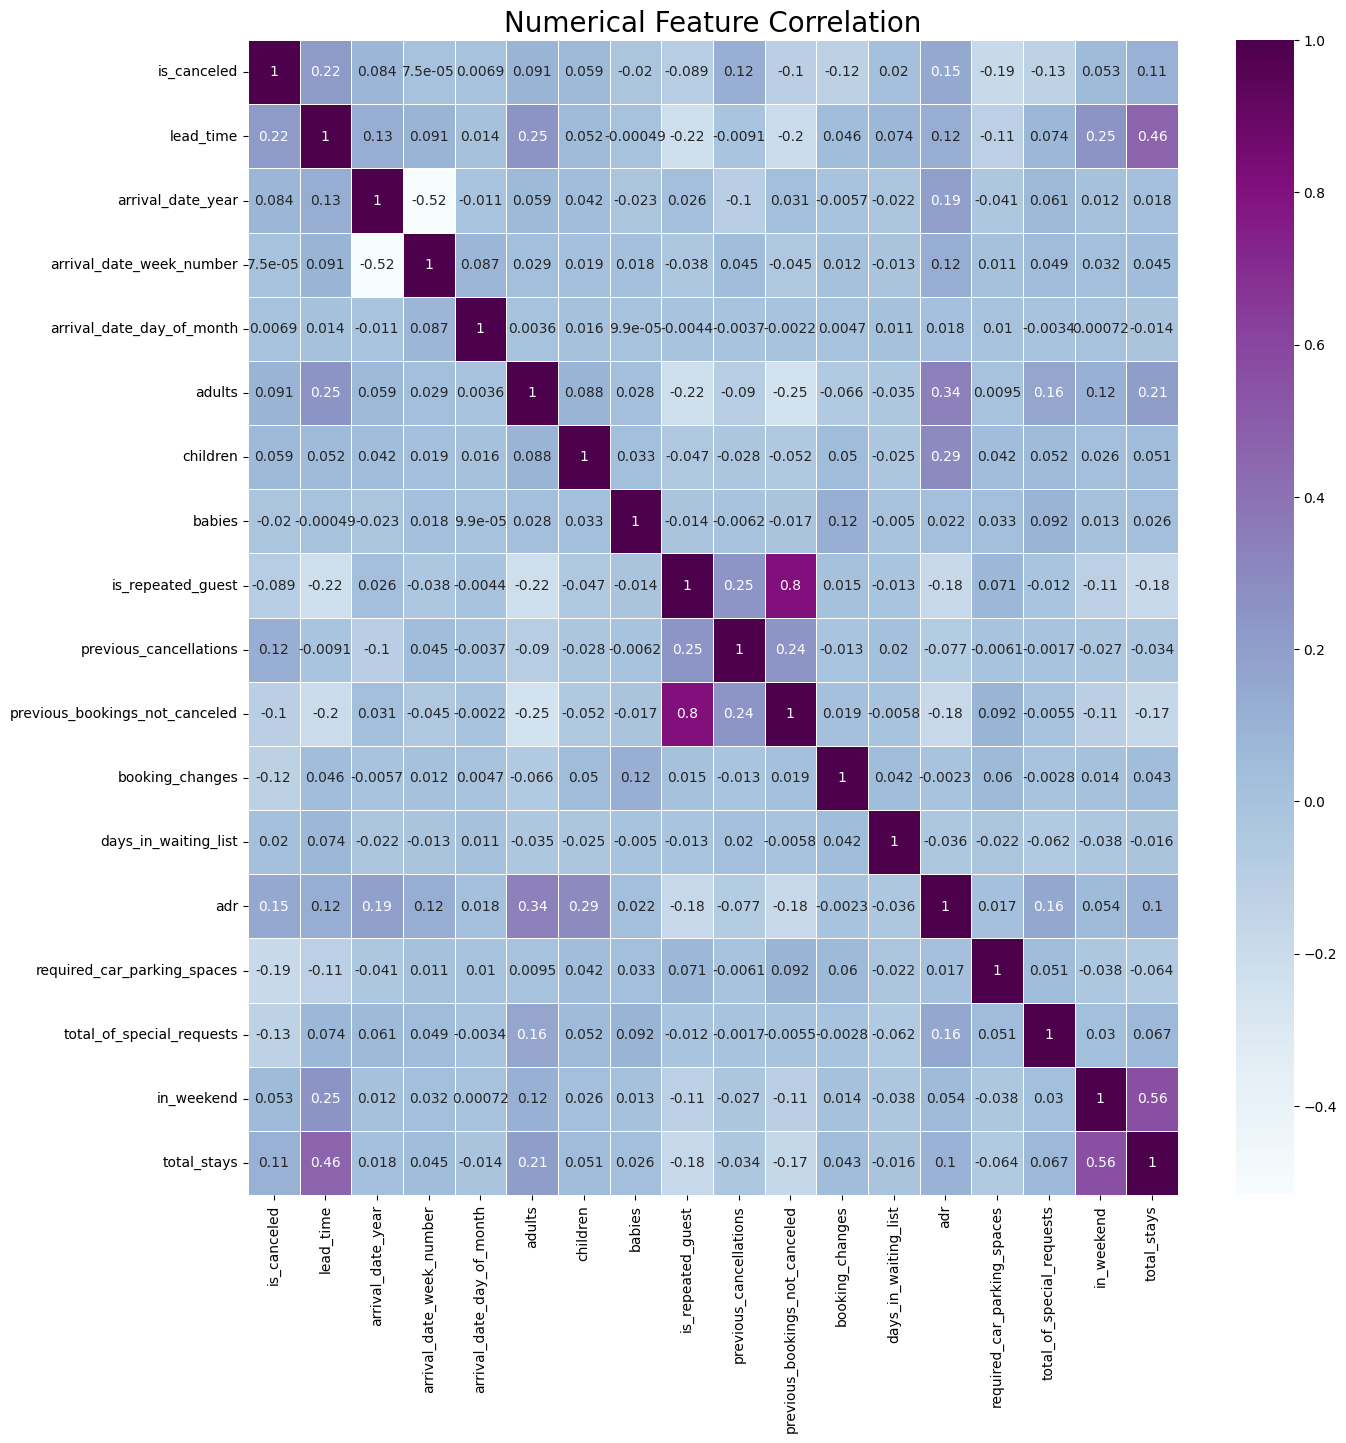

In [135]:
# numerical feature correlation
plt.figure(figsize=(15,15))
sns.heatmap(df.corr('spearman'),annot=True, cmap='BuPu', linewidths=.5)
plt.title('Numerical Feature Correlation', size=20)
plt.show()

Berdasarkan correlation matrix dapat terlihat bahwa feature 'previous_bookings_not_canceled' memiliki korelasi positif yang lemah dengan feature 'is_repeated_guest'. Maka saya akan mendrop feature 'is_repeated_guest'

In [136]:
df.drop('is_repeated_guest', inplace=True, axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84533 entries, 2 to 86977
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           84533 non-null  object 
 1   is_canceled                     84533 non-null  int64  
 2   lead_time                       84533 non-null  int64  
 3   arrival_date_year               84533 non-null  int64  
 4   arrival_date_month              84533 non-null  object 
 5   arrival_date_week_number        84533 non-null  int64  
 6   arrival_date_day_of_month       84533 non-null  int64  
 7   adults                          84533 non-null  int64  
 8   children                        84533 non-null  float64
 9   babies                          84533 non-null  int64  
 10  meal                            84533 non-null  object 
 11  country                         84533 non-null  object 
 12  market_segment                  

In [137]:
# encode categorical
cat_var = [col for col in df.columns if df[col].dtype == 'O']
cat_var = df[cat_var]
le=LabelEncoder()

for i in cat_var:
    cat_var[i]=le.fit_transform(cat_var[i])
cat_var['is_canceled'] = df['is_canceled']

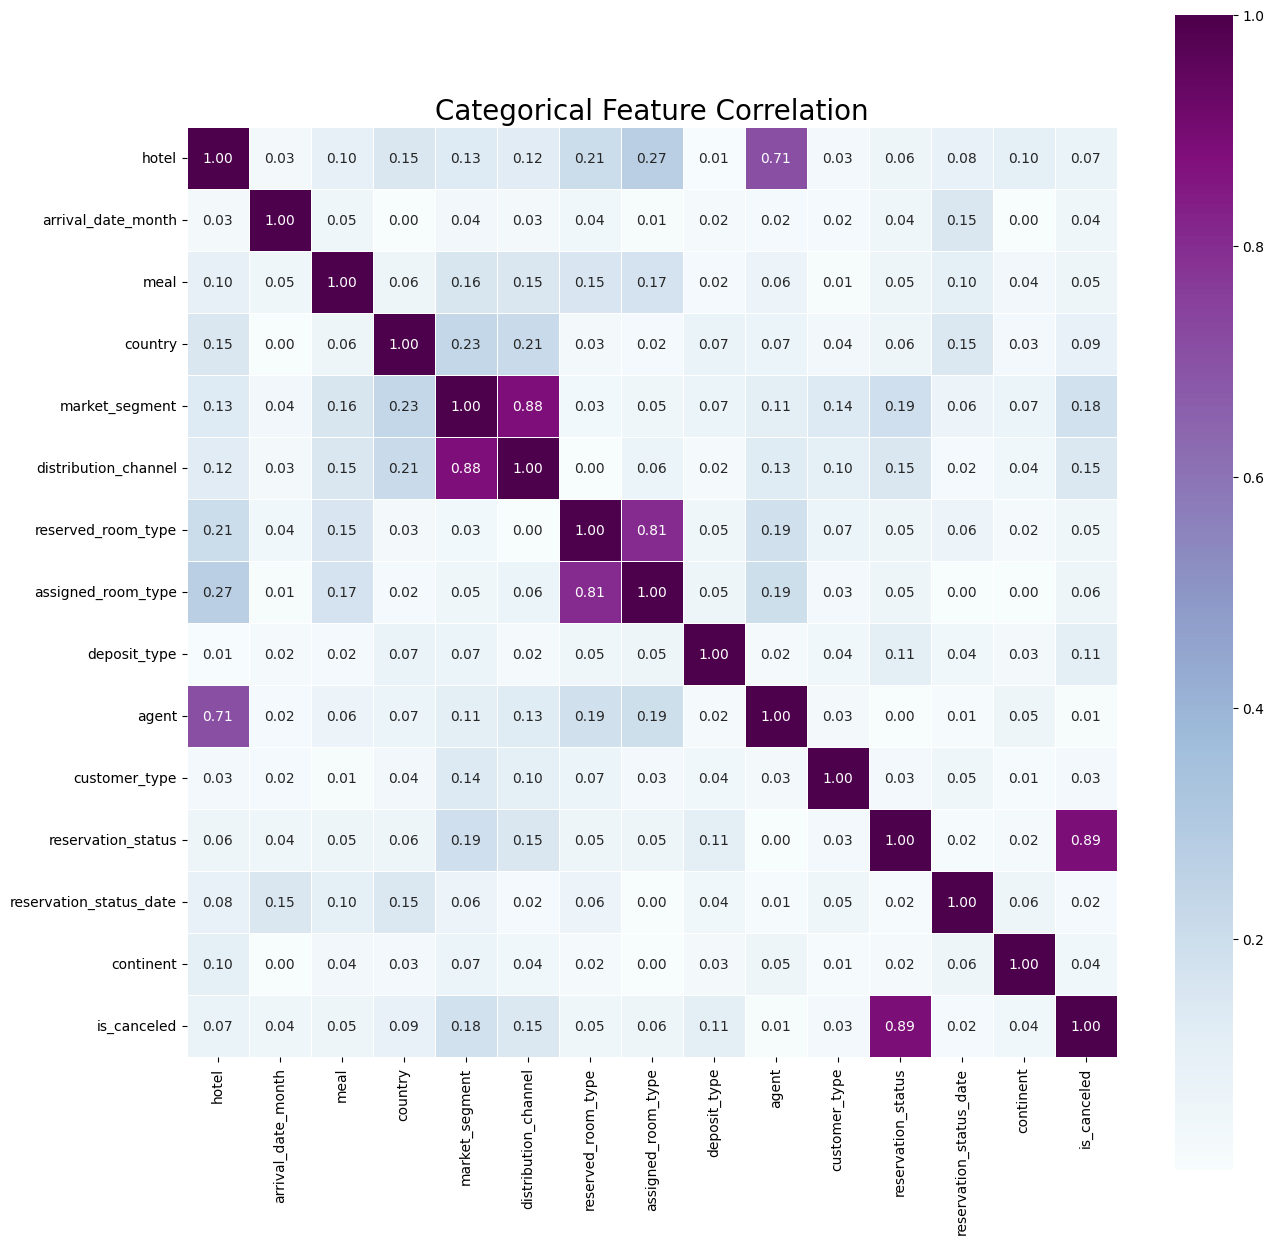

In [138]:
# categorical feature correlation
plt.figure(figsize=(15,15))
palette=sns.diverging_palette(20, 220, n=256)
corr = cat_var.corr().abs()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='BuPu''', square=True, linewidths=.5)
plt.title('Categorical Feature Correlation', size=20)
plt.show()

Berdasarkan correlation matrix dapat terlihat bahwa:
- 'market_segment' memiliki korelasi positif yang kuat dengan feature 'distribution channel'. Maka saya akan mendrop feature 'distribution channel'
- 'reserved_room_type' memiliki korelasi kuat dengan 'assigned_room_type'. Maka saya akan mendrop feature 'reserved_room_type'.
- 'reservation_status' memiliki nilai korelasi positif kuat terhadap cancel. Karena feature 'reservation_status' menjelaskan mengenai reservasi yang telah terjadi berupa reservasi status terakhir (Canceled - pemesanan dibatalkan oleh pelanggan; Check-Out - pelanggan telah check-in tetapi sudah berangkat; No-Show - pelanggan tidak melakukan check-in dan menginformasikan alasannya kepada pihak hotel) Maka saya akan mendrop feature tersebut karena akan menyebabkan leakage atau data bocor.
- 'hotel' memiliki nilai korelasi positif kuat terhadap 'agent'. Maka saya akan mendrop feature 'hotel' karena hanya menjelasakan mengenai tipe hotel saja.

In [139]:
df.drop(columns=['distribution_channel','reserved_room_type', 'reservation_status', 'hotel'] , axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84533 entries, 2 to 86977
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   is_canceled                     84533 non-null  int64  
 1   lead_time                       84533 non-null  int64  
 2   arrival_date_year               84533 non-null  int64  
 3   arrival_date_month              84533 non-null  object 
 4   arrival_date_week_number        84533 non-null  int64  
 5   arrival_date_day_of_month       84533 non-null  int64  
 6   adults                          84533 non-null  int64  
 7   children                        84533 non-null  float64
 8   babies                          84533 non-null  int64  
 9   meal                            84533 non-null  object 
 10  country                         84533 non-null  object 
 11  market_segment                  84533 non-null  object 
 12  previous_cancellations          

saya akan mendropkan beberapa kolom , seperti:
1. 'arrival_date_year', yang menjelaskan mengenai Tahun kedatangan 
2. 'arrival_date_day_of_month', yang menjelaskan mengenai tanggal kedatangan
3. 'arrival_date_month', yang menjelaskan mengenai Bulan kedatangan
4. 'reservation_status_date', yang menjelaskan mengenai Tanggal saat status terakhir ditetapkan. Variabel ini dapat digunakan bersama dengan ReservationStatus untuk mengetahui kapan pemesanan dibatalkan atau kapan pelanggan check-out dari hotel
- features diatas menjelaskan tentang waktu yang akan menyebabkan leakage. Hal ini disebabkan karena model ditujukan untuk memprediksi pembatalan pesanan hotel di masa mendatang, serta untuk waktu sudah diwakili oleh feature 'lead_time' yang menjelaskan mengenai Selisih hari pada saat pemesanan hingga tanggal kedatangan, dan 'arrival_date_week_number' yang menjelaskan mengenai jumlah ,minggu per tahun untuk kedatangan. Kedua feature tersebut dapat lebih mewakili 'cancel'/'tidak cancel'. Maka saya akan mendrop keempat feature tentang waktu diatas tersebut.

In [140]:
df.drop(columns=['arrival_date_year','arrival_date_day_of_month', 'arrival_date_month', 'reservation_status_date'] , axis=1, inplace=True)

In [141]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84533 entries, 2 to 86977
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   is_canceled                     84533 non-null  int64  
 1   lead_time                       84533 non-null  int64  
 2   arrival_date_week_number        84533 non-null  int64  
 3   adults                          84533 non-null  int64  
 4   children                        84533 non-null  float64
 5   babies                          84533 non-null  int64  
 6   meal                            84533 non-null  object 
 7   country                         84533 non-null  object 
 8   market_segment                  84533 non-null  object 
 9   previous_cancellations          84533 non-null  int64  
 10  previous_bookings_not_canceled  84533 non-null  int64  
 11  assigned_room_type              84533 non-null  object 
 12  booking_changes                 

In [142]:
# check descriptive statistic
df.describe().T

count        mean        std  min    25%  \
is_canceled                     84533.0    0.270190   0.444061  0.0   0.00   
lead_time                       84533.0   72.290951  73.457780  0.0  11.00   
arrival_date_week_number        84533.0   26.748938  13.727511  1.0  15.00   
adults                          84533.0    1.880118   0.497535  1.0   2.00   
children                        84533.0    0.134728   0.446607  0.0   0.00   
babies                          84533.0    0.010659   0.104290  0.0   0.00   
previous_cancellations          84533.0    0.023766   0.211722  0.0   0.00   
previous_bookings_not_canceled  84533.0    0.185904   1.743370  0.0   0.00   
booking_changes                 84533.0    0.262395   0.694998  0.0   0.00   
days_in_waiting_list            84533.0    0.373889   5.024528  0.0   0.00   
adr                             84533.0  106.926615  52.041330  0.0  72.38   
required_car_parking_spaces     84533.0    0.085612   0.281309  0.0   0.00   
total_of_special_requests       84533.0    0.701052   0.831155  0.0   0.00   
in_weekend                      84533.0    0.597341   0.490436  0.0   0.00   
total_stays                     84533.0    3.582352   2.641487  0.0   2.00   

                                 50%    75%    max  
is_canceled                      0.0    1.0    1.0  
lead_time                       46.0  117.0  300.0  
arrival_date_week_number        27.0   37.0   53.0  
adults                           2.0    2.0    4.0  
children                         0.0    0.0    3.0  
babies                           0.0    0.0    2.0  
previous_cancellations           0.0    0.0    6.0  
previous_bookings_not_canceled   0.0    0.0   72.0  
booking_changes                  0.0    0.0   17.0  
days_in_waiting_list             0.0    0.0  121.0  
adr                             99.0  135.0  510.0  
required_car_parking_spaces      0.0    0.0    3.0  
total_of_special_requests        1.0    1.0    5.0  
in_weekend                       1.0    1.0    1.0  
total_stays                      3.0    5.0   30.0

# Target

In [143]:
# persentase perbandingan target dari kelas 0 dan 1 (yang tidak cancel dan cancel)
df['is_canceled'].value_counts()/len(df)*100

0    72.980966
1    27.019034
Name: is_canceled, dtype: float64

Data terindikasi imbalance antara kelas 0 dan 1 dengan persentase 73% : 27%

# Data Preprocessing

In [144]:
dfcat = list(df.select_dtypes('object').columns)
dfnum = list(set(df.columns)-set(dfcat))

print(f'Number of numerical features: {len(dfnum)-1}')
print(f'numerical features: {[cols for cols in dfnum if cols != "is_canceled"]}')
print(f'\nNumber of categorical features: {len(dfcat)}')
print(f'Categorical features: {dfcat}')

Number of numerical features: 14
numerical features: ['babies', 'lead_time', 'total_of_special_requests', 'arrival_date_week_number', 'booking_changes', 'days_in_waiting_list', 'previous_cancellations', 'previous_bookings_not_canceled', 'adr', 'total_stays', 'required_car_parking_spaces', 'in_weekend', 'children', 'adults']

Number of categorical features: 8
Categorical features: ['meal', 'country', 'market_segment', 'assigned_room_type', 'deposit_type', 'agent', 'customer_type', 'continent']


In [145]:
# Menampilkan unique value dari categorical feature
categorical_unique = ['meal', 'country', 'market_segment', 'assigned_room_type', 'deposit_type', 'agent', 'customer_type', 'continent']

for cat in categorical_unique:
    print(f'Unique value dari {cat} = {df[cat].unique()}')

Unique value dari meal = ['BB' 'FB' 'HB' 'SC']
Unique value dari country = ['GBR' 'PRT' 'USA' 'ESP' 'IRL' 'FRA' 'ROU' 'NOR' 'OMN' 'ARG' 'POL' 'DEU'
 'BEL' 'CHE' 'CN' 'GRC' 'ITA' 'NLD' 'DNK' 'RUS' 'SWE' 'AUS' 'EST' 'CZE'
 'BRA' 'FIN' 'MOZ' 'BWA' 'LUX' 'SVN' 'ALB' 'IND' 'CHN' 'MEX' 'MAR' 'UKR'
 'SMR' 'LVA' 'PRI' 'SRB' 'CHL' 'AUT' 'BLR' 'LTU' 'TUR' 'ZAF' 'AGO' 'ISR'
 'CYM' 'ZMB' 'CPV' 'ZWE' 'DZA' 'KOR' 'CRI' 'HUN' 'ARE' 'TUN' 'JAM' 'HRV'
 'HKG' 'IRN' 'GEO' 'AND' 'GIB' 'URY' 'JEY' 'CAF' 'CYP' 'COL' 'GGY' 'KWT'
 'NGA' 'VEN' 'MDV' 'SVK' 'KAZ' 'PAK' 'IDN' 'LBN' 'PHL' 'SEN' 'SYC' 'AZE'
 'BHR' 'NZL' 'THA' 'DOM' 'MKD' 'MYS' 'ARM' 'JPN' 'LKA' 'CUB' 'CMR' 'BIH'
 'MUS' 'COM' 'SUR' 'UGA' 'BGR' 'CIV' 'JOR' 'SYR' 'SGP' 'BDI' 'SAU' 'VNM'
 'PLW' 'QAT' 'EGY' 'PER' 'MLT' 'MWI' 'ECU' 'MDG' 'ISL' 'UZB' 'NPL' 'BHS'
 'MAC' 'TGO' 'TWN' 'DJI' 'STP' 'KNA' 'ETH' 'IRQ' 'HND' 'RWA' 'KHM' 'MCO'
 'BGD' 'IMN' 'TJK' 'NIC' 'BEN' 'VGB' 'TZA' 'GAB' 'GHA' 'TMP' 'GLP' 'KEN'
 'LIE' 'GNB' 'MNE' 'UMI' 'MYT' 'MMR' 'PAN' 'BFA' '

### Encoding
untuk unique value <=4 saya akan memakai one hot encoding, dan unique value >4 saya akan menggunakan binary encoding
- meal : one hot encoding
- country : binary encoding
- market_segment : binary encoding
- assigned_room_type : binary encoding
- deposit_type : one hot encoding
- agent : binary encoding
- customer_type :  one hot encoding
- continent : binary encoding

In [146]:
# transformer
transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first', handle_unknown = 'ignore'), ['meal','deposit_type', 'customer_type']),
    ('binary', ce.BinaryEncoder(), ['country', 'market_segment', 'assigned_room_type', 'continent','agent']),
], remainder = 'passthrough')

### Scaling
Mengingat dalam pembuatan model machine learning nantinya saya juga akan mencoba menggunakan algoritma Logistic Regression dan KNN maka saya akan menerapkan scaling.

Harapannya dengan memiliki fitur pada skala yang sama maka kinerja algoritma machine learning akan meningkat karena setiap fitur dapat berkontibusi sama pada target. Jika tidak dilakukan scaling maka variabel skala besar akan mendominasi fitur skala kecil khususnya untuk algoritma yang memperhitungkan jarak seperti KNN.

Kemudian karena data pada kolom numerikal terdapat outlier maka saya menggunakan RobustScaler.

In [147]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler

In [148]:
# Scaler
scaler = RobustScaler()

### Data Imbalance Handling
saya akan menggunakan metode resampling untuk menambah kelas minoritas yang akan dilakukan pada saat modeling. Data imbalance sendiri dapat memiliki dampak buruk pada model machine learning pada saat memprediksi kelas minoritas/kelas yang lebih sedikit jumlahnya. saya akan mencoba 3 metode sampling yaitu SMOTE, SMOTENC, dan random over sampling

In [149]:
dfcat = list(df.select_dtypes(['object','category']).columns)
dfnum = list(set(df.columns)-set(dfcat))

print(f'Number of numerical features: {len(dfnum)-1}')
print(f'numerical features: {[cols for cols in dfnum if cols != "is_canceled"]}')
print(f'\nNumber of categorical features: {len(dfcat)}')
print(f'Categorical features: {dfcat}')

Number of numerical features: 14
numerical features: ['babies', 'lead_time', 'total_of_special_requests', 'arrival_date_week_number', 'booking_changes', 'days_in_waiting_list', 'previous_cancellations', 'previous_bookings_not_canceled', 'adr', 'total_stays', 'required_car_parking_spaces', 'in_weekend', 'children', 'adults']

Number of categorical features: 8
Categorical features: ['meal', 'country', 'market_segment', 'assigned_room_type', 'deposit_type', 'agent', 'customer_type', 'continent']


In [150]:
df.columns

Index(['is_canceled', 'lead_time', 'arrival_date_week_number', 'adults',
       'children', 'babies', 'meal', 'country', 'market_segment',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests', 'continent',
       'in_weekend', 'total_stays'],
      dtype='object')

In [151]:
# sampling untuk menambah data pada kelas minoritas
smonc = SMOTENC(random_state=15, categorical_features=[5,6,7,10,12,13,15,19]) #index column categorical
sm = SMOTE(random_state=15)
ros = RandomOverSampler(random_state=15)

# Define X dan y

In [152]:
# define target 
X = df.drop('is_canceled', axis=1)
y = df['is_canceled']

# Splitting Data
Untuk pemodelan ini saya akan menggunakan test size = 0.2 sehingga data testing adalah sebesar 20% dari keseluruhan dataset.

Karena saya akan menggunakan Classification untuk memprediksi data atau label yang sifatnya kategorik, maka saya menggunakan stratify=y agar proporsi nilai cancel pada y_train dan y_test sama.

In [153]:
# splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state=15)

# Model Benchmark

In [154]:
from xgboost import XGBClassifier
import lightgbm as lgb

In [155]:
logreg = LogisticRegression(random_state=15, solver='liblinear')
knn = KNeighborsClassifier(n_neighbors=5)
dtree = DecisionTreeClassifier(random_state=15, max_depth=5)
rf = RandomForestClassifier(max_depth=5, random_state=15)
lgbm = lgb.LGBMClassifier(max_depth=5)
xgb = XGBClassifier (max_depth=5)

## CROSS VALIDATION

In [156]:
# Stratified cross validation
skf = StratifiedKFold(n_splits = 5)

In [157]:
# cross validation

models = [logreg, knn, dtree, rf, lgbm, xgb]

list_mean_with_smote = []
list_std_with_smote = []

list_mean_with_smotenc = []
list_std_with_smotenc = []

list_mean_with_ros = []
list_std_with_ros = []

list_mean_without_sampling = []
list_std_without_sampling = []


for i in models:
    # modeling with smote
    pipe_model_with_smote = Pipeline([
        ('transformer', transformer),
        ('scaler', scaler),
        ('balancing', sm),
        ('model', i)
    ])

    model_cv_with_smote = cross_val_score(
        estimator = pipe_model_with_smote,
        X = X_train,
        y = y_train,
        cv = skf,
        scoring = 'recall',
        n_jobs = -1
    )
    list_mean_with_smote.append(model_cv_with_smote.mean())
    list_std_with_smote.append(model_cv_with_smote.std())

    # modeling with smotenc
    pipe_model_with_smotenc = Pipeline([
        ('transformer', transformer),
        ('scaler', scaler),
        ('balancing', smonc),
        ('model', i)
    ])

    model_cv_with_smotenc = cross_val_score(
        estimator = pipe_model_with_smotenc,
        X = X_train,
        y = y_train,
        cv = skf,
        scoring = 'recall',
        n_jobs = -1
    )
    list_mean_with_smotenc.append(model_cv_with_smotenc.mean())
    list_std_with_smotenc.append(model_cv_with_smotenc.std())

    # modeling with ros
    pipe_model_with_ros = Pipeline([
        ('transformer', transformer),
        ('scaler', scaler),
        ('balancing', ros),
        ('model', i)
    ])

    model_cv_with_ros = cross_val_score(
        estimator = pipe_model_with_ros,
        X = X_train,
        y = y_train,
        cv = skf,
        scoring ='recall',
        n_jobs = -1
    )
    list_mean_with_ros.append(model_cv_with_ros.mean())
    list_std_with_ros.append(model_cv_with_ros.std())

    # modeling without sampling
    pipe_model_without_sampling = Pipeline([
        ('transformer', transformer),
        ('scaler', scaler),
        ('model', i)
    ])

    model_cv_without_sampling = cross_val_score(
        estimator = pipe_model_without_sampling,
        X = X_train,
        y = y_train,
        cv = skf,
        scoring = 'recall',
        n_jobs = -1
    )
    list_mean_without_sampling.append(model_cv_without_sampling.mean())
    list_std_without_sampling.append(model_cv_without_sampling.std())

In [158]:
pd.DataFrame({'model':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'LightGBM', 'XGBoost'],
            'mean_recall_with_smote' : list_mean_with_smote,
            'mean_recall_with_smotenc' : list_mean_with_smotenc,
            'mean_recall_with_ros' : list_mean_with_ros,
            'mean_recall_without_sampling' : list_mean_without_sampling,
            'std_recall_with_smote' : list_std_with_smote,
            'std_recall_with_smotenc' : list_std_with_smotenc,
            'std_recall_with_ros' : list_std_with_ros,
            'std_recall_without_sampling' : list_std_without_sampling,
}).sort_values('mean_recall_without_sampling', ascending=False)

model  mean_recall_with_smote  mean_recall_with_smotenc  \
5              XGBoost                0.688157                  0.705724   
1                  KNN                0.778131                  0.756567   
4             LightGBM                0.742338                  0.770687   
0  Logistic Regression                0.755090                  0.739000   
2        Decision Tree                0.875603                  0.757164   
3        Random Forest                0.789239                  0.792195   

   mean_recall_with_ros  mean_recall_without_sampling  std_recall_with_smote  \
5              0.838715                      0.622701               0.007149   
1              0.769320                      0.581601               0.009257   
4              0.853492                      0.553798               0.007204   
0              0.759195                      0.437664               0.006384   
2              0.876809                      0.435749               0.016914   
3              0.806808                      0.041977               0.014284   

   std_recall_with_smotenc  std_recall_with_ros  std_recall_without_sampling  
5                 0.005476             0.004638                     0.005495  
1                 0.011038             0.012960                     0.018309  
4                 0.006932             0.004376                     0.008003  
0                 0.006943             0.006826                     0.004287  
2                 0.058823             0.023383                     0.008464  
3                 0.011764             0.010006                     0.005204

Bahwa dari semua model benchmark yang di analisa, terlihat bahwa model yang menggunakan random over sampling memiliki mean recall yang besar. LightGBM  dan XGBoost adalah model yang terbaik karena memiliki mean recall tinggi dan standard deviasi recall yang kecil, dimana semakin tinggi mean, akan semakin bagus model, begitu juga dengan standard deviasi dari kedua yang lebih kecil dibandingkan model lainnya dengan random over sampling, karena semakin kecil standard deviasi, maka semakin stabil modelnya. Walau decision tree dengan random over sampling memiliki mean recall paling besar dibandingkan XGBoost dan LightGBM, tetapi tidak saya pilih karena standard deviasinya yang cukup tinggi dibandingkan XGBoost dan LightGBM. Maka saya akan coba predict ke train dan test set model XGBoost dan LightGBM yang menggunakan random over sampling.

## TRAIN & TEST DATA

In [159]:
logreg = LogisticRegression(random_state=15, solver='liblinear')
knn = KNeighborsClassifier(n_neighbors=5)
dtree = DecisionTreeClassifier(random_state=15, max_depth=5)
rf = RandomForestClassifier(max_depth=5, random_state=15)
lgbm = lgb.LGBMClassifier(max_depth=5)
xgb = XGBClassifier (max_depth=5)

In [160]:
models = [logreg, knn, dtree, rf, lgbm, xgb]

In [161]:
# modeling with random over sampling
score_recall_test = []
score_recall_train = []

def y_pred_func(model):
    estimator = Pipeline([
        ('transformer', transformer),
        ('scaler', scaler),
        ('balancing', ros),
        ('model', model)
    ])
    
    estimator.fit(X_train,y_train)
    return estimator

for model in models:
    estimator = y_pred_func(model)
    y_pred_test = estimator.predict(X_test)
    y_pred_train = estimator.predict(X_train)
    score_recall_test.append(recall_score(y_test,y_pred_test))
    score_recall_train.append(recall_score(y_train,y_pred_train))

In [162]:
pd.DataFrame({'model':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'LightGBM', 'XGBoost'],
             'recall score (train set)': score_recall_train,
             'recall score (validation set)': list_mean_with_ros,
             'recall score (test set)': score_recall_test}).set_index('model').sort_values(by='recall score (validation set)',ascending=False)

recall score (train set)  recall score (validation set)  \
model                                                                          
Decision Tree                        0.886274                       0.876809   
LightGBM                             0.866189                       0.853492   
XGBoost                              0.875219                       0.838715   
Random Forest                        0.822953                       0.806808   
KNN                                  0.919221                       0.769320   
Logistic Regression                  0.764448                       0.759195   

                     recall score (test set)  
model                                         
Decision Tree                       0.885070  
LightGBM                            0.851576  
XGBoost                             0.850701  
Random Forest                       0.828590  
KNN                                 0.776270  
Logistic Regression                 0.757443

Ketika di predict ke train set dan test set, performa LightGBM Classifier memiliki recall Score yang lebih baik daripada XGBoost. Maka saya akan melakukan tuning parameter menggunakan LightGBM.



# HYPERPARAMETER TUNING : CROSS VALIDATION

Saya akan melakukan hyperparameter tuning pada model LGBM Classifier dengan harapan dapat meningkatkan performa model.

LightGBM CLassifier framework Gradient Boosting yang menggunakan algoritma 'tree-based'. Algoritma ini di desain untuk efisien dan dengan beberapa kelebihan:
- Kecepatan 'training' yang lebih cepat dan memiliki efisiensi yang tinggi
- Penggunaan memori yang lebih sedikit
- Accuracy yang lebih baik
- Mendukung pembelajaran GPU, parallel, dan terdistribusi.
- Mampu untuk mengolah data dalam skala yang besar

Berdasarkan [dokumentasi](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html), Berikut beberapa parameter yang akan saya coba:


- num_leaves (min_split_loss) = max number of leaves in one tree
- min_data_in_leaf = Minimum number of observations that must fall into a tree node for it to be added.
- num_iterations = parameter controls the number of boosting rounds that will be performed. 
- learning rate = shrinkage rate to prevents overfitting.
- scale_pos_weight = weight of labels with positive class

In [163]:
from sklearn.model_selection import RandomizedSearchCV

In [164]:
model = lgb.LGBMClassifier(max_depth=5)

In [165]:
# Random Search
hyperparam_space = {
    'model__num_leaves':list(np.arange(2,900,5)),
    'model__min_data_in_leaf': list(np.arange(10,101,2)),
    'model__num_iterations':list(np.arange(10,101,2)),
    'model__learning_rate': list(np.arange(0.1,1,0.01)),
    'model__scale_pos_weight' : [10, 20, 30]
}

model_pipe_LightGBM = Pipeline([
    # ('balancing',ros),
    ('transformer',transformer),
    # ('scaler',scaler),
    ('model', model)
])

skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)

random_lgbm = RandomizedSearchCV(
    estimator = model_pipe_LightGBM,
    param_distributions=hyperparam_space,
    cv=skfold,
    scoring='recall',
    n_jobs=-1,
    n_iter=100,
    random_state=15,
)

random_lgbm.fit(X_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=15, shuffle=True),
                   estimator=Pipeline(steps=[('transformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('onehot',
                                                                               OneHotEncoder(drop='first',
                                                                                             handle_unknown='ignore'),
                                                                               ['meal',
                                                                                'deposit_type',
                                                                                'customer_type']),
                                                                              ('binary',
                                                                               BinaryEncoder(),
                                                                               ['country',
                                                                                'market_segment',
                                                                                'assigned_room_ty...
                                                                    46, 48, 50,
                                                                    52, 54, 56,
                                                                    58, 60, 62,
                                                                    64, 66, 68, ...],
                                        'model__num_iterations': [10, 12, 14,
                                                                  16, 18, 20,
                                                                  22, 24, 26,
                                                                  28, 30, 32,
                                                                  34, 36, 38,
                                                                  40, 42, 44,
                                                                  46, 48, 50,
                                                                  52, 54, 56,
                                                                  58, 60, 62,
                                                                  64, 66, 68, ...],
                                        'model__num_leaves': [2, 7, 12, 17, 22,
                                                              27, 32, 37, 42,
                                                              47, 52, 57, 62,
                                                              67, 72, 77, 82,
                                                              87, 92, 97, 102,
                                                              107, 112, 117,
                                                              122, 127, 132,
                                                              137, 142, 147, ...],
                                        'model__scale_pos_weight': [10, 20,
                                                                    30]},
                   random_state=15, scoring='recall')

Model LightGBM adalah model boosting, boosting memperbaiki suatu model machine learning dengan cara memberikan perhatian lebih terhadap data poin yang hasil klasifikasinya salah. weak learner di transformasi menjadi strong learner. Weak learner dapat dipandang sebagai model machine learning yang performanya tidak terlalu bagus.

Siklus dalam gradien boosting adalah pertama membuat satu tree lalu perbaiki modelnya dengan cara memberikan perhatian lebih atau bobot yang lebih besar terhadap data poin yang hasil klasifikasinya salah. Proses dilakukan terus menerus hingga titik tertentu. Prediksi akhir diperoleh dengan cara menggabungkan hasil prediksi dari tree yang sudah dibuat sebelumnya.

In [166]:
print(random_lgbm.best_score_)
print(random_lgbm.best_params_)

0.9950743858088543
{'model__scale_pos_weight': 30, 'model__num_leaves': 607, 'model__num_iterations': 12, 'model__min_data_in_leaf': 76, 'model__learning_rate': 0.3999999999999998}


In [167]:
random_lgbm.cv_results_['std_test_score'][random_lgbm.best_index_]

0.0010530151802720517

Ternyata setelah tuning, performa model LightGBM meningkat menjadi :

| Condition |	Mean Recall Score |	Std Dev |
| --- | --- | --- |
| Before Tuning |	0.853	| 0.004 |
| After Tuning |	0.995 |	0.001 |

Best parameter untuk LightGBM:

- 'model__scale_pos_weight': 30
- 'model__num_leaves': 607
- 'model__num_iterations': 12
- 'model__min_data_in_leaf': 76
- 'model__learning_rate': 0.3999999999999998

Selanjutnya saya akan mencoba performa model pada test set.



# Prediction on Test Set

In [168]:
# Define model terhadap estimator terbaik
best_model = random_lgbm.best_estimator_

# Fitting model
best_model.fit(X_train, y_train)

# Predict test set
y_pred_default = estimator.predict(X_test)
y_pred_proba_default = estimator.predict_proba(X_test)
y_pred_tuned = best_model.predict(X_test)
y_pred_proba_tuned = best_model.predict_proba(X_test)

recall_default = recall_score(y_test, y_pred_default)
recall_tuned = recall_score(y_test, y_pred_tuned)

print('Recall Score Default LGBM : ', recall_default)
print('Recall Score Tuned LGBM : ', recall_tuned)

Recall Score Default LGBM :  0.8507005253940455
Recall Score Tuned LGBM :  0.9962784588441331


Setelah saya predict model ke test set dan telah di hyperparameter tuning, terlihat bahwa performa model (recall) meningkat menjadi 0.996 dari o.995

# Confusion Matrix Before & After Tuning



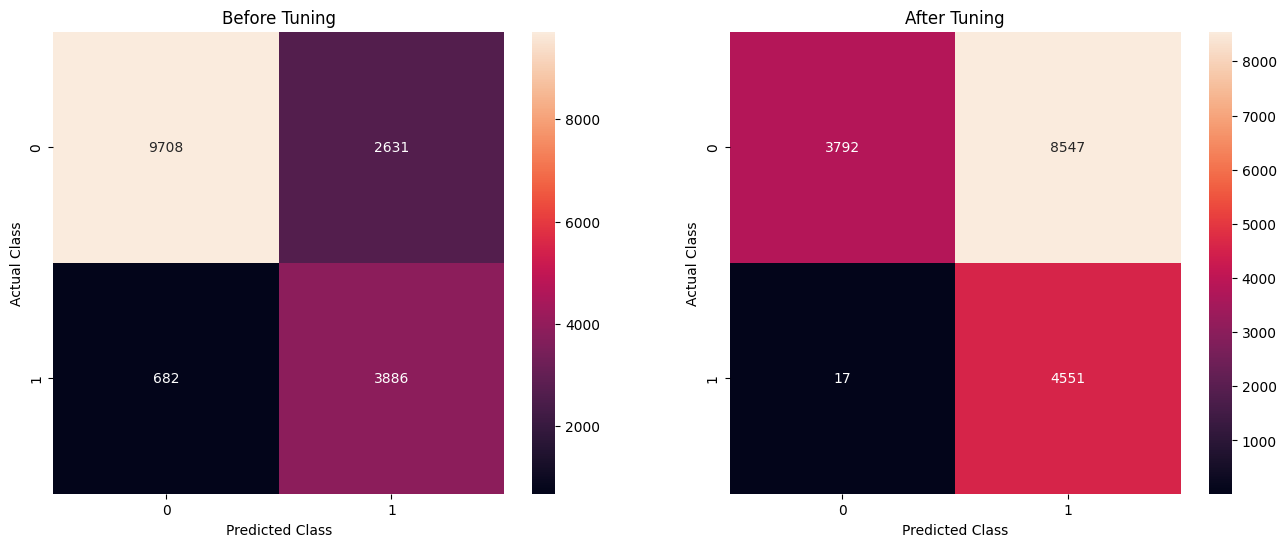

In [169]:
plt.figure(figsize=(16, 6))
plt.subplot(121)
sns.heatmap(confusion_matrix(y_test, y_pred_default), annot=True, fmt='g').set_title('Before Tuning')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.subplot(122)
sns.heatmap(confusion_matrix(y_test, y_pred_tuned), annot=True, fmt='g').set_title('After Tuning')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class');

- TN = 3792 diprediksi tidak cancel dan aktualnya memang tidak cancel 
- TP = 4551 diprediksi cancel dan aktualnya memang cancel
- FP = 8547 diprediksi cancel padahal aktualnya tidak cancel 
- FN = 17 diprediksi tidak cancel padahal aktualnya cancel

Type 1 error : False Positive  
Konsekuensi: mismanagement hotel service karena diprediksi cancel padahal aktualnya tidak cancel

Skenario:
Jika model memprediksi pemesanan kamar hotel dibatalkan dan sudah menjual kamar ke customer lain, tetapi kemudian customer asli tidak membatalkan dan datang ke hotel di tanggal mereka check in, lalu tidak ada kamar yang tersedia pada saat itu untuk customer asli atau ada kamar yang tersedia tetapi dengan kelas lebih rendah, maka reputasi hotel akan rusak. Namun jika kamar yang tersedia adalah kelas yang lebih tinggi dengan harga yang lebih mahal, maka hotel akan mengalami kerugian revenue dari menjual kamar yang lebih mahal itu dengan harga yang lebih murah.


Type 2 error : False Negative  
Konsekuensi: Revenue hotel akan hilang karena diprediksi tidak cancel padahal aktualnya cancel

Skenario:
Jika model memprediksi pemesanan kamar hotel tidak dibatalkan, tetapi customer tidak datang, maka hotel akan mengalami kerugian berupa revenue yang hilang karena hotel tidak menjual kamar kepada customer potensial lainnya dan hotel tidak akan mendapatkan revenue penjualan dari hotel service berupa F&B dan revenue dari hotel service lainnya.

# Model Limitation

Kita harus berhati-hati ketika melakukan interpretasi di luar interval independen variabel. Model ini hanya berlaku pada rentang data yang digunakan pada pemodelan ini yaitu :
- lead time yaitu range antara 0-300
- arrival date week number range antara 1-53
- adults range dari 1-4
- children range dari 0-3
- babies range dari 0-2
- previous cancellations range dari 0-6
- previous bookings not canceled range antara 0-72
- booking_changes range antara 0-17
- days_in_waiting_list range antara 0-121
- adr range antara 0-510
- required_car_parking_spaces range antara 0-3
- total_of_special_requests range antara 0-5
- in_weekend : 0-no dan 1-yes
- total_stays range antara 0-30

# Feature Importance

In [170]:
onehot_cols = list(transformer.transformers_[0][1].get_feature_names_out())
binary_cols = list(transformer.transformers_[1][1].get_feature_names())
remainder_cols = list(X.columns[transformer.transformers_[2][2]])

feature_name = onehot_cols + binary_cols + remainder_cols

In [171]:
feature_importances = pd.DataFrame({
    'features' : feature_name,
    'importances':best_model['model'].feature_importances_
})

feature_importances.sort_values('importances', ascending=False).head(10)

features  importances
35                  lead_time           37
44                        adr           24
46  total_of_special_requests           21
12                  country_4           16
18           market_segment_2           14
40     previous_cancellations           14
36   arrival_date_week_number           13
15                  country_7           13
13                  country_5           13
6     customer_type_Transient           12

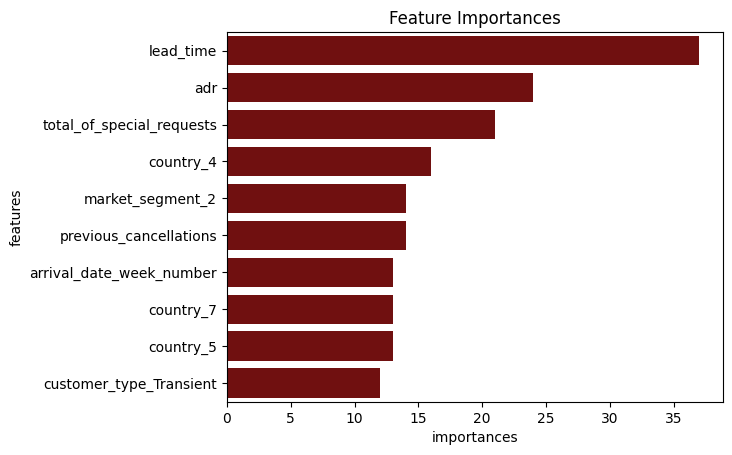

In [172]:
top10_features = feature_importances.sort_values('importances', ascending=False).head(10)

sns.barplot(data = top10_features, y= 'features', x='importances', ci=0, color='maroon')
plt.title('Feature Importances')


plt.show()

Top 3 fitur paling penting berdasarkan model Light GBM ini, yaitu lead time, adr, dan total special request. Hal ini cukup sesuai dengan EDA sebelumnya, yang mana ketiga fitur tersebut memang memiliki hubungan dengan target sebagai berikut:

- lead time : target cenderung cancel di selisih hari pada saat pemesanan hingga tanggal kedatangan antara selisih 0-5 hari .
- adr : target cenderung cancel di ADR atau tarif harian rata-rata 100 euro.
- total special request : target cenderung cancel jika tidak ada special request.

# SHAPLEY VALUE OF EXPLANATIONS (SHAP)


In [173]:
X_train_prep = transformer.fit_transform(X_train)


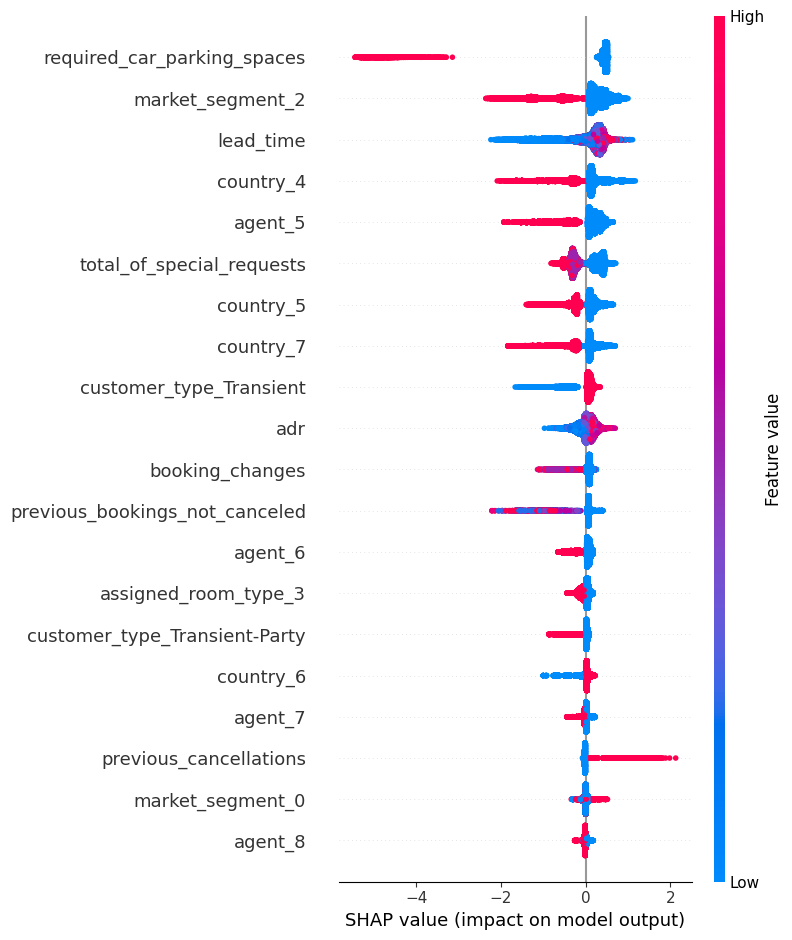

In [174]:
import shap

explainer = shap.TreeExplainer(best_model['model'])
shap_values = explainer.shap_values(X_train_prep)

shap.summary_plot(shap_values[1], X_train_prep, feature_names = feature_name)

biru= tidak cancel, merah = cancel



Berdasarkan SHAP value, dapat terlihat bahwa fitur yang paling penting diantaranya:

- required parking spaces
- lead time
- total of special request

Interpretasi

- Semakin tinggi required parking space, semakin besar kemungkinan customer untuk tidak cancel.
- Semakin rendah lead time, semakin besar kemungkinan customer untuk tidak cancel.
- Semakin tinggi total of special request, semakin besar kemungkinan customer untuk tidak cancel.

Hasil ini cukup konsisten dengan hasil analisa pada bagian EDA.



In [178]:

report_default = classification_report(y_test, y_pred_default)
report_tuned = classification_report(y_test, y_pred_tuned)

print('Classification Report Default LGBM : \n', report_default)
print('Classification Report Tuned LGBM : \n', report_tuned)


Classification Report Default LGBM : 
               precision    recall  f1-score   support

           0       0.93      0.79      0.85     12339
           1       0.60      0.85      0.70      4568

    accuracy                           0.80     16907
   macro avg       0.77      0.82      0.78     16907
weighted avg       0.84      0.80      0.81     16907

Classification Report Tuned LGBM : 
               precision    recall  f1-score   support

           0       1.00      0.31      0.47     12339
           1       0.35      1.00      0.52      4568

    accuracy                           0.49     16907
   macro avg       0.67      0.65      0.49     16907
weighted avg       0.82      0.49      0.48     16907



# Conclusion and Recommendation


## Conclusion

Berdasarkan hasil classification report dari model, saya dapat menyimpulkan bahwa bila seandainya nanti menggunakan model ini untuk memfilter reservasi yang akan nanti coba dialihkan kepada customer lain untuk meningkatkan pendapatan, maka model ini dapat mengurangi 31% reservasi yang tidak cancel untuk tidak dialihkan kepada customer lain, dan model ini dapat mendapatkan 100% reservasi yang akan cancel dari seluruh reservasi yang cancel. (semua ini berdasarkan recallnya)

Model ini memiliki ketepatan prediksi reservasi yang akan cancel sebesar 35% (precisionnya), jadi setiap model ini memprediksi bahwa reservasi itu cancel, maka kemungkinan tebakannya benar itu sebesar 35% kurang lebih. Maka masih akan ada reservasi yang sebenarnya tidak akan cancel tetapi di prediksi sebagai reservasi yang cancel sekitar 69% dari keseluruhan reservasi yang tidak cancel (berdasarkan recall).

Statistik Cancel menggunakan y_test (20%):

- 0: 3.809
- 1: 13.098
- Total data: 16.907

Tanpa model:

Apabila pada periode tertentu ada 16.907 customer yang melakukan reservasi dengan tarif rata-rata harian 100 euro. Dan ada 4.568 akan cancel dan 12.339 tidak akan cancel. Maka tanpa model, kita tidak akan tahu mana yang akan cancel dan yang tidak cancel. Maka perhitungannya:
- Total pendapatan reservasi = 16.907 x 100 euro = 1.690.700 euro (apabila semua reservasi terjadi)
- Total kerugian = 4.568 customer x 100 euro = 456.800 euro (karena tidak dialihkan kepada customer lain)
- Total pendapatan ADR = 1.690.700 - 456.800 = **1.233.900 euro** (setelah dikurangi kerugian)

Dengan model:
- TP = 4.551 reservasi akan dialihkan kepada customer lain maka 4.551 x 100 euro = 455.100 euro (pendapatan)
- TN = 3.792 reservasi terjadi maka 3.792 x 100 euro = 379.200 euro (pendapatan)
- FP = 8.547 reservasi terjadi namun mismanagement service karena reservasi dialihkan kepada customer baru dan customer asli bisa dapat kamar lebih mahal atau lebih murah. Namun hotel masih untung. Maka 8.547 x 100 euro = 854.700 euro (pendapatan)
- FN = 17 reservasi tidak terjadi karena cancel dan tidak dialihkan kepada customer lain, maka 17 x 100 euro = 17.100 euro (kerugian)
- Total pendapatan ADR = **1.689.000 euro**




Dengan model, kita bisa meningkatkan pendapatan sebesar **455.100 euro**

% Kenaikan = 455.100 / 1.233.900 x 100 = **37%**

# Saving model with pickle


In [179]:
# save
import pickle

In [180]:
# Model Akhir
lgbm_best_model = random_lgbm.best_estimator_
beami_cancel_model = lgbm_best_model.fit(X, y)
pickle.dump(beami_cancel_model, open('LGBM_machine_learning_beami.sav', 'wb'))

[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76


# Recommendation for Hotel

1. Untuk City hotel maupun Resort hotel, Paling banyak kamar terjual yaitu antara bulan Mei-Oktober. Di Eropa pada bulan Mei-Juli adalah musim panas dan bulan Agustus-Oktober adalah musim gugur. Pada kedua musim itu adalah waktu dengan suhu yang cocok untuk keluar rumah dan pergi berlibur menginap di hotel dibandingkan dengan musim dingin dan musim semi yang suhunya kurang mendukung. Musim semi sendiri suhunya masih terlalu dingin yaitu antara 6-13°C. Staff management hotel dapat menentukan perencanaan anggaran untuk departemen personalia dalam merekrut karyawan magang untuk bagian housekeeping dan front office di bulan Mei-Oktober selama 6 bulan. Budget pengeluaran dalam bentuk gaji untuk karyawan magang sendiri lebih sedikit dibandingkan merekrut karyawan tetap. Sehingga hal tersebut bisa meningkatkan pendapatan hotel.
2. Paling banyak kamar terjual yaitu di bulan Mei-Oktober, Staff management hotel dapat berkoordinasi dengan staff departemen housekeeping untuk pengecekan alat dan bahan untuk kebersihan kamar hotel maupun area hotel. Apabila ada alat yang rusak, staff management hotel dapat menetapkan pembuatan anggaran operasional dan pengadaan barang hotel untuk departemen housekeeping pada bulan-bulan ramai pengunjung tersebut. Namun apabila tidak ada, penetapan pembuatan anggaran operasional dan pengadaan barang hotel untuk departemen housekeeping dapat diturunkan. Namun untuk bahan-bahan pembersih tentu saja staff management hotel harus menentukan budget lebih banyak untuk departemen housekeeping di bulan Mei-Oktober. Staff management hotel dapat mengontrol pembelian yang mana pelaksanaannya dilakukan oleh purchasing staff sehingga akan terhindar dari pengeluaran yang berlebihan, dengan kontrol yang baik akan terjadinya keseimbangan antara pembelian dengan pemasukan sehingga target pendapatan tercapai. 
3. Penjualan tipe meal yang terbanyak dari bulan ke bulan selalu tipe meal BB (sarapan saja). Asal tamu yang menginap paling banyak adalah dari benua Eropa. Informasi mengenai asal tamu hotel dapat membantu departemen F&B service untuk menyiapkan jenis masakan yang dapat disiapkan agar dapat menyesuaikan dengan lidah tamu dan dapat membuat anggaran pembelian bahan baku makanan untuk masakan yang cocok dengan lidah tamu. Maka staff management hotel dapat membuat penentuan anggaran pembelian bahan baku makanan untuk masakan yang cocok dengan lidah orang Eropa karena tamu hotel kebanyakan berasal dari benua Eropa. Serta Budgetnya bisa dikontrol agar tidak berlebihan karena tamu kebanyakan memesan tipe meal BB (sarapan saja). Penentuan budget untuk F&B service bisa ditingkatkan di bulan Juli-Agustus karena lebih ramai pengunjung di bulan-bulan tersebut serta dapat disesuaikan dengan tipe makanan untuk musim panas dan musim gugur.
4. Batasi tenggat waktu pembatalan maksimal 5 hari dari tanggal kedatangan dan berikan notifikasi melalui email/platform/aplikasi untuk mengonfirmasi kedatangan/tidak.
5. Buat kebijakan uang deposit tidak kembali apabila tidak mengonfirmasi pembatalan H-15 kedatangan dan bisa hapus sistem no deposit
6. Jika reservasi diperkirakan akan dibatalkan dan kamar telah terjual ke customer lain, namun customer asli tetap datang. Maka bisa geser jam check in untuk customer asli atau geser jam check out untuk tamu yang akan check out. Sehingga akan kebagian kamar.
7. Jika customer reservasi kamar kelas lebih tinggi namun yang tersedia kamar kelas yang lebih rendah maka coba tawarkan cashback sebesar selisih harga kamar yang dipesan/ voucher selisih harga kamar
8. Bulan ramai tamu menginap adalah Juli-Agustus, pada bulan tersebut bisa membuat event menarik di hotel atau menyewakan area hotel untuk bazar misalnya. Hal tersebut juga bisa meningkatkan revenue hotel.

# Recommendation for Model

1. menggunakan algoritma boosting lainnya yang belum dicoba.
2. Menganalisa data-data yang model yang masih salah tebak (False Negative dan terutama False Positive) untuk mengetahui alasan dan karakteristiknya.
3. Menambahkan jumlah data terutama pada kategori cancel agar memperoleh informasi yang lebih akurat.
4. Menerapkan threshold